In [1]:
from google.colab import drive
drive.mount('/content/drive')


import os

import torch
os.chdir('/content/drive/MyDrive/ImitationLearning/Invariant-Causal-Imitation-Learning-main/')


Mounted at /content/drive


# load

In [2]:
!pip install mpi4py 
!pip install box2d-py
!pip install box2d 
!pip3 install gym[Box_2D] 
!pip install gym==0.17.2 -qqq
!pip install numpy~=1.18.2 -qqq
!pip install pandas~=1.0.4 -qqq
!pip install PyYAML~=5.4.1 -qqq
!pip install scikit-learn~=0.22.2 -qqq
!pip install scipy~=1.1.0 -qqq
!pip install stable-baselines~=2.10.1 -qqq
!pip install tensorflow~=1.15.0 -qqq
!pip install torch>=1.6.0 -qqq
!pip install tqdm~=4.32.1 -qqq


     |████████████████████████████████| 2.5 MB 7.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185284 sha256=7afc49097a43dd53b3d511417240cb1f991c1d23fe095bc7d80acc48c5a136a3
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
     |████████████████████████████████| 448 kB 7.1 MB/s 
     |████████████████████████████████| 1.3 MB 6.9 MB/s 
     |████████████████████████████████| 1.6 MB 7.4 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 require

#config

In [3]:

config = {
    "ALG": "NFiVAE_IRMStudent_Apr28",
    "NUM_TRAJS_GIVEN": 20, #
    "NUM_TRAINING_ENVS": 2,
    "NOISE_DIM": 4,
    "REP_SIZE": 16,
    "TRAJ_SHIFT": 20, # 20,
    "SAMPLING_RATE": 5,
    "NUM_STEPS_TRAIN": 10000,
    "NUM_TRAJS_VALID": 100,
    "NUM_REPETITIONS": 15,
    "BATCH_SIZE": 64,
    "MLP_WIDTHS": 64,
    "ADAM_ALPHA": 1e-3,
    "SGLD_BUFFER_SIZE": 10000,
    "SGLD_LEARN_RATE": 0.01,
    "SGLD_NOISE_COEF": 0.01,
    "SGLD_NUM_STEPS": 100,
    "SGLD_REINIT_FREQ": 0.05,
    "NUM_STEPS_TRAIN_ENERGY_MODEL": 1000,
    'TRIAL': 0
}


#config['ENV'] = "LunarLander-v2"
config['ENV'] = "CartPole-v1"

#config['METHOD'] = "BC"
config['METHOD'] = "iVAE_IRM"



if config['METHOD'] == 'BCIRM':
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10000
    config['penalty_anneal_iters'] = 2500
elif config['METHOD'] == "iVAE_IRM":
    config["NUM_STEPS_TRAIN_VAE_MODEL"] = 1500 # phase1
    config["NUM_STEPS_TRAIN"] = 10000 # phase 3
    config['PHASE2_SAMPLES'] = 25000 # phase 2
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10
    config['BATCH_SIZE'] = 50000
    config['MODEL_TYPE'] = 'NFiVAE'
    config['SELECT_PARENTS'] = True
    config['PARENT_THRESHOLD'] = -1
   



config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

config['METHOD'] = "iVAE_IRM"



#testing/il

In [4]:
import argparse
import os
import pickle

import gym
import numpy as np
import pandas as pd
import yaml
import numpy as np

from testing.paths import get_model_path, get_trajs_path  # pylint: disable=reimported

from contrib.energy_model import EnergyModel
from contrib.env_wrapper import EnvWrapper, get_test_mult_factors
from network import EnvDiscriminator
from network import FeaturesDecoder
from network import FeaturesEncoder
from network import MineNetwork 
from network import ObservationsDecoder
from network import StudentNetwork, StudentNetwork_2hidden


from student import ICILStudent, BCStudent, BCIRMStudent, iVAE_IRMStudent, NFiVAE_IRMStudent
from testing.train_utils import fill_buffer, make_agent, save_results
from vae.ivae_wrapper import VAE_wrapper
from vae.nfivae_wrapper import NFiVAE_wrapper
  
from torch import nn

/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


#NFiVAE

In [ ]:
from numbers import Number

import numpy as np
import torch
from torch import distributions as dist
from torch import nn
from torch.nn import functional as F
from torch import autograd
import copy


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, activation='none', slope=.1, device='cpu'):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.device = device
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
            else:
                #print("c", c)
                #print("self.fc", self.fc[c])
                #print("h", h)
                #print("self.act_f", self._act_f[c])
                
                h = self._act_f[c](self.fc[c](h))
        return h


class Dist:
    def __init__(self):
        pass

    def sample(self, *args):
        pass

    def log_pdf(self, *args, **kwargs):
        pass


class Normal(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.c = 2 * np.pi * torch.ones(1).to(self.device)
        self._dist = dist.normal.Normal(torch.zeros(1).to(self.device), torch.ones(1).to(self.device))
        self.name = 'gauss'

    def sample(self, mu, v):
        eps = self._dist.sample(mu.size()).squeeze()
        scaled = eps.mul(v.sqrt())
        return scaled.add(mu)

    def log_pdf(self, x, mu, v, reduce=True, param_shape=None):
        """compute the log-pdf of a normal distribution with diagonal covariance"""
        if param_shape is not None:
            mu, v = mu.view(param_shape), v.view(param_shape)
        lpdf = -0.5 * (torch.log(self.c) + v.log() + (x - mu).pow(2).div(v))
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf

    def log_pdf_full(self, x, mu, v):
        """
        compute the log-pdf of a normal distribution with full covariance
        v is a batch of "pseudo sqrt" of covariance matrices of shape (batch_size, d_latent, d_latent)
        mu is batch of means of shape (batch_size, d_latent)
        """
        batch_size, d = mu.size()
        cov = torch.einsum('bik,bjk->bij', v, v)  # compute batch cov from its "pseudo sqrt"
        assert cov.size() == (batch_size, d, d)
        inv_cov = torch.inverse(cov)  # works on batches
        c = d * torch.log(self.c)
        # matrix log det doesn't work on batches!
        _, logabsdets = self._batch_slogdet(cov)
        xmu = x - mu
        return -0.5 * (c + logabsdets + torch.einsum('bi,bij,bj->b', [xmu, inv_cov, xmu]))

    def _batch_slogdet(self, cov_batch: torch.Tensor):
        """
        compute the log of the absolute value of determinants for a batch of 2D matrices. Uses torch.slogdet
        this implementation is just a for loop, but that is what's suggested in torch forums
        gpu compatible
        """
        batch_size = cov_batch.size(0)
        signs = torch.empty(batch_size, requires_grad=False).to(self.device)
        logabsdets = torch.empty(batch_size, requires_grad=False).to(self.device)
        for i, cov in enumerate(cov_batch):
            signs[i], logabsdets[i] = torch.slogdet(cov)
        return signs, logabsdets


class Laplace(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self._dist = dist.laplace.Laplace(torch.zeros(1).to(self.device), torch.ones(1).to(self.device) / np.sqrt(2))
        self.name = 'laplace'

    def sample(self, mu, b):
        eps = self._dist.sample(mu.size())
        scaled = eps.mul(b)
        return scaled.add(mu)

    def log_pdf(self, x, mu, b, reduce=True, param_shape=None):
        """compute the log-pdf of a laplace distribution with diagonal covariance"""
        if param_shape is not None:
            mu, b = mu.view(param_shape), b.view(param_shape)
        lpdf = -torch.log(2 * b) - (x - mu).abs().div(b)
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf


class Bernoulli(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self._dist = dist.bernoulli.Bernoulli(0.5 * torch.ones(1).to(self.device))
        self.name = 'bernoulli'

    def sample(self, p):
        eps = self._dist.sample(p.size())
        return eps

    def log_pdf(self, x, f, reduce=True, param_shape=None):
        """compute the log-pdf of a laplace distribution with diagonal covariance"""
        if param_shape is not None:
            f = f.view(param_shape)
        lpdf = x * torch.log(f) + (1 - x) * torch.log(1 - f)
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf






class NFiVAE(nn.Module):
    def __init__(self, latent_dim, data_dim, aux_dim, prior=None, decoder=None, encoder=None,
                 n_layers=3, hidden_dim=50, activation='lrelu', slope=.1, device='cpu', anneal=False, 
                 NF_priors_output_dim=20, NF_priors_n_layers=3, NF_priors_hidden_dim=50, ):
        super().__init__()

        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.aux_dim = aux_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.activation = activation
        self.slope = slope
        self.anneal_params = anneal

        if prior is None:
            self.prior_dist = Normal(device=device)
        else:
            self.prior_dist = prior

        if decoder is None:
            self.decoder_dist = Normal(device=device)
        else:
            self.decoder_dist = decoder

        if encoder is None:
            self.encoder_dist = Normal(device=device)
        else:
            self.encoder_dist = encoder

        
        self.logl = MLP(aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope, device=device)
        # decoder params
        self.f = MLP(latent_dim, data_dim, hidden_dim, n_layers, activation=activation, slope=slope, device=device)
        self.decoder_var = .01 * torch.ones(1).to(device)
        # encoder params
        self.g = MLP(data_dim + aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope,
                     device=device)
        self.logv = MLP(data_dim + aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope,
                        device=device)

        self.device = device

        # prior_params
        self.prior_mean = torch.zeros(1).to(device)
        
        # 1.1 T_NN(x)
        self.T_NN_x = MLP(latent_dim, NF_priors_output_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        # 1.2 lambda_NN(Y,E)
        self.lambda_NN_YE = MLP(aux_dim, NF_priors_output_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        
        # 2. T_f(x) and lambda_f(Y,E) are in the second dot product term
          # 2.1 T_f(x) = concat([X, X^2]). This is data dependent, we will define it later during training/evaluation process
          # 2.2 lambda_f(Y,E)
        self.lambda_f_YE = MLP(aux_dim, 2*latent_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        #self.T_f_x = torch.hstack([z, z**2])



        self.apply(weights_init)

        self._training_hyperparams = [1., 1., 1., 1., 1]
        
        print("\n***** VAE wrapper created with NFiVAE *****\n")

    def encoder_params(self, x, u):
        xu = torch.cat((x, u), 1)
        g = self.g(xu)
        logv = self.logv(xu)
        return g, logv.exp()

    def decoder_params(self, s):
        f = self.f(s)
        return f, self.decoder_var

    def prior_params(self, z, u):
        T_NN_x = self.T_NN_x(z)
        lambda_NN_YE = self.lambda_NN_YE(u)
        T_f_x = torch.hstack([z, z**2])
        lambda_f_YE = self.lambda_f_YE(u)

        log_x_ye = torch.sum(T_NN_x * lambda_NN_YE, axis = 1) + torch.sum(T_f_x * lambda_f_YE, axis = 1)
        #p_x_ye = log_x_ye.exp()
        #grad = autograd.grad(p_x_ye, [z], create_graph=True)[0]

        return log_x_ye.exp()

    def forward(self, x, u):
        
        encoder_params = self.encoder_params(x, u)
        z = self.encoder_dist.sample(*encoder_params)
        decoder_params = self.decoder_params(z)
        prior_params = self.prior_params(z, u)
        #return decoder_params, encoder_params, z, prior_params
        return decoder_params, encoder_params, z, prior_params

    def prior_1st_derivative_matching(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = copy.deepcopy(z.detach()) - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz

            derivative_of_log_encoder = ( self.encoder_params(z_plus_new, u) - self.encoder_params(z_minus_new, u) ) / (2*dz)
            derivative_of_log_prior = ( self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u) ) / (2*dz)
            

            
            #sum_derivative += 0.5 * ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
            sum_derivative += ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
            
        
        #print("self.prior_params(z_plus_new, u)", self.prior_params(z_plus_new, u))
        #print("self.prior_params(z_minus_new, u)", self.prior_params(z_minus_new, u))
      
        return sum_derivative
    
    def prior_2nd_derivative(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = z.detach() - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz
            
            sum_derivative += (self.prior_params(z_plus_new, u) - 2*self.prior_params(z, u) + self.prior_params(z_minus_new, u)) / dz / dz

        return sum_derivative
        

    def prior_1st_derivative(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = copy.deepcopy(z.detach()) - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz

            #print("z_plus_new", z_plus_new)
            #print("z_minus_new", z_minus_new)
            
            sum_derivative += 0.5* ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
        
        #print("self.prior_params(z_plus_new, u)", self.prior_params(z_plus_new, u))
        #print("self.prior_params(z_minus_new, u)", self.prior_params(z_minus_new, u))
      
        return sum_derivative





    def elbo(self, x, u):
        decoder_params, (g, v), z, prior_params = self.forward(x, u)
        log_px_z = self.decoder_dist.log_pdf(x, *decoder_params)
        log_qz_xu = self.encoder_dist.log_pdf(z, g, v)
        #log_pz_u = self.prior_dist.log_pdf(z, *prior_params)
        log_pz_u = torch.log(prior_params[1])
        
        #####
        #weight_norm = torch.tensor(0.).cuda()
        #for w in self.T_NN_x.parameters():
        #    weight_norm += w.norm().pow(2)    
        #for w in self.lambda_NN_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #for w in self.lambda_f_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #for w in self.lambda_f_YE.parameters():
        #    weight_norm += w.norm().pow(2)  
        #####
        
        
        if self.anneal_params:
            a, b, c, d, N = self._training_hyperparams
            M = z.size(0)
            log_qz_tmp = self.encoder_dist.log_pdf(z.view(M, 1, self.latent_dim), g.view(1, M, self.latent_dim),
                                                   v.view(1, M, self.latent_dim), reduce=False)
            log_qz = torch.logsumexp(log_qz_tmp.sum(dim=-1), dim=1, keepdim=False) - np.log(M * N)
            log_qz_i = (torch.logsumexp(log_qz_tmp, dim=1, keepdim=False) - np.log(M * N)).sum(dim=-1)

            return (a * log_px_z - b * (log_qz_xu - log_qz) - c * (log_qz - log_qz_i) - d * (
                    log_qz_i - log_pz_u)).mean(), z

        else:
            print("part1 & 2 = ", (log_px_z + log_pz_u.detach() - log_qz_xu).mean().detach().cpu().numpy(), 
                                  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean().detach().cpu().numpy(),
                                  z.norm().detach().cpu().numpy() )
            #print("       part2 = ", (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean())
            #return (log_px_z + log_pz_u.detach() - log_qz_xu).mean() - self.prior_1st_derivative(z, u).mean() , z 
            #return (log_px_z + log_pz_u.detach() - log_qz_xu).mean(),  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean(), z 
            return (log_px_z + log_pz_u.detach() - log_qz_xu).mean() -  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean(), z 
            
            


    def anneal(self, N, max_iter, it):
        thr = int(max_iter / 1.6)
        a = 0.5 / self.decoder_var.item()
        self._training_hyperparams[-1] = N
        self._training_hyperparams[0] = min(2 * a, a + a * it / thr)
        self._training_hyperparams[1] = max(1, a * .3 * (1 - it / thr))
        self._training_hyperparams[2] = min(1, it / thr)
        self._training_hyperparams[3] = max(1, a * .5 * (1 - it / thr))
        if it > thr:
            self.anneal_params = False


#NFiVAE-*wrapper*

In [ ]:
import torch
import torch.optim as optim
from torch import autograd, nn
from tqdm import tqdm
from fcit import fcit
import pickle
import numpy as np
#from vae.ivae import iVAE
#from vae.nfivae import NFiVAE
from torch._C import dtype
import torch.nn.functional as F
import random 


class NFiVAE_wrapper:
    def __init__(
        self,
        buffer, 
        data_dim,
        action_dim,
        env_dim = 2,
        latent_dim = 8,
        activation = 'lrelu',
        n_layers = 3,
        hidden_dim = 32,
        lr = 1e-3,
        seed = 0,
        #max_iter = 7e4,
        use_a = True, 
        use_e = False,
        num_updates = 1000,
        ckpt_file = './vae/nfivae_ckpt.pt',
        pa_dict_file = './vae/nfivae_padict.pkl',
        model_type = 'NFiVAE',
        parents_threshold = 2,
        ):
      
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        torch.manual_seed(seed)
        np.random.seed(seed)

        self.state_dim = data_dim
        self.action_dim = action_dim 
        self.latent_dim = latent_dim

        self.buffer = buffer

        if use_a and use_e:
            aux_dim = action_dim + env_dim 
            print("use both actions and env as aux variables")
        elif use_e == False:
            aux_dim = action_dim
            print("use only actions as aux variable")
        
        if model_type == 'iVAE':
            self.model = iVAE(latent_dim, data_dim, aux_dim, activation='lrelu', device=self.device,
                     n_layers=n_layers, hidden_dim=hidden_dim)
        elif model_type == 'NFiVAE':
            self.model = NFiVAE(latent_dim, data_dim, aux_dim, activation='lrelu', device=self.device,
                     n_layers=n_layers, hidden_dim=hidden_dim)
            
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        #self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.1, patience=100, verbose=True)
        self.ckpt_file = ckpt_file
        self.pa_dict_file = pa_dict_file

        self.use_a = use_a 
        self.use_e = use_e

        self.env_dim = env_dim
        print("learning rate of NFiVAE in phase 1:", lr)
        
        self.parents_threshold = parents_threshold


    def train(self, num_updates = 10000):
        
        print("NFiVAE wrapper train buffer sample size = ", self.buffer.sample()['state'].shape)
        
        loss_list = []
        best_window_loss = np.inf
        best_window_loss_num = 0
        self.model.train()
        for update_index in (range(num_updates)):
            loss = self._update_vae_model()
            loss_list.append(loss.detach().cpu())
            
            #if np.mean(loss_list[-100:]) < best_window_loss:
            if loss < best_window_loss:
                #best_window_loss = np.mean(loss_list[-100:])
                best_window_loss = loss
                best_window_loss_num = update_index
                torch.save(self.model.state_dict(), self.ckpt_file)
            """
            if len(loss_list) > 150: # train at least 150 epochs
                if np.mean(loss_list[-100:]) > best_window_loss:
                    self.model.load_state_dict(torch.load(self.ckpt_file))
                    return loss_list
            """
        
            if update_index % 100 ==0:
                print('\repoch {}/{} \tloss: {}'.format(update_index, num_updates, loss), end="")
                #print(update_index, loss)
        #torch.save(self.model.state_dict(), self.ckpt_file)
        
        self.model.load_state_dict(torch.load(self.ckpt_file))
        
        print("best loss model loaded, stored at update #", best_window_loss_num, "with loss", best_window_loss.detach().cpu().numpy())
        
        return loss_list


    def _update_vae_model(self):
        samples = self.buffer.sample()

        x = torch.FloatTensor(samples["state"]).to(self.device)

        a = F.one_hot(torch.LongTensor(samples['action']), num_classes = self.action_dim)#.to(self.device)
        
        if self.use_a and self.use_e:
            e = F.one_hot(torch.LongTensor(samples['env']), num_classes = self.env_dim)#.to(self.device)
            ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
        elif self.use_e == False:
            ae = a.to(torch.float32).to(self.device)

        self.optimizer.zero_grad()
        #elbo_VAE, elbo_SM, z_est = self.model.elbo(x, ae)
        elbo, z_est = self.model.elbo(x, ae)
        #elbo = elbo_VAE - elbo_SM
        elbo.mul(-1).backward() #loss.backward()
        
        self.optimizer.step()

        #return elbo_VAE.mul(-1)
        return elbo.mul(-1)
        


    def predict_latent(self, samples):
        self.model.eval()
        x = torch.FloatTensor(samples["state"]).to(self.device)

        a = F.one_hot(torch.LongTensor(samples['action']), num_classes = self.action_dim)#.to(self.device)
        
        if self.use_a and self.use_e:
            e = F.one_hot(torch.LongTensor(samples['env']), num_classes = self.env_dim)#.to(self.device)
            ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
        elif self.use_e == False:
            ae = a.to(torch.float32).to(self.device)

        _, _, z, _ = self.model(x, ae)
        return z


    def _get_random_states(self, num_states):
        return torch.FloatTensor(num_states, self.in_dim).uniform_(-1, 1)








    ############################        phase 2.       #########################
    ############################        phase 2.       #########################
    ############################        phase 2.       #########################


    def phase2_sampled_data(self, n_samples = 1000):

        
        n_queries = n_samples // self.buffer.batch_size + 1
      
        actions = []
        states = []
        latents = []

        for i in range(n_queries):
            samples = self.buffer.sample()
            actions.append(samples['action'].reshape(-1,1))
            states.append(samples['state'])
            z = self.predict_latent(samples)
            latents.append(z.detach().cpu().numpy())

        actions = np.concatenate(np.vstack(actions))[:n_samples].reshape(-1,1).astype(int)
        states = np.concatenate((states), axis = 0)[:n_samples]
        latents = np.concatenate((latents), axis = 0)[:n_samples]

        actions = np.eye(actions.max()+1)[actions][:,0,:] # convert to one-hoc encoding
        
        
        """
        samples = self.buffer.sample_all()
        actions = (samples['action'].reshape(-1,1)).astype(int)
        states = (samples['state'])
        z = self.predict_latent(samples)
        latents = (z.detach().cpu().numpy())

        actions = np.eye(actions.max()+1)[actions][:,0,:] # convert to one-hoc encoding
        """

        return states, latents, actions

        
    def phase2_find_parents(self, latents, actions):

        parents = []

        num_vars = latents.shape[1]

        for i in range(num_vars-1):
            for j in range(i+1, num_vars):
                pval_d = fcit.test(latents[:,i].reshape(-1,1), latents[:,j].reshape(-1,1))
                pval_i = fcit.test(latents[:,i].reshape(-1,1), latents[:,j].reshape(-1,1), actions)
                if pval_d < pval_i:
                    print('{} and {} are independent with pval_d={} and pval_i={}'.format(i, j, pval_d, pval_i))
                else:
                    print('{} and {} are DEPENDENT with pval_d={} and pval_i={}'.format(i, j, pval_d, pval_i))
                    parents.append(i)
                    parents.append(j)

        parents_set = set(parents)

        parents_dict = {}
        for p in parents_set:
            parents_dict[p] = parents.count(p)
            
        for i in range(num_vars):
            if i not in parents_set:
                parents_dict[i] = 0

        parents_dict_sorted = {}
        for w in sorted(parents_dict, key=parents_dict.get, reverse=True):
            print(w, parents_dict[w])
            if parents_dict[w]>self.parents_threshold:
                parents_dict_sorted[w] = parents_dict[w]

        return list(parents_dict_sorted.keys()), parents_dict_sorted


    def start_phase2(self, n_samples = 50000, save = True):

        print("\n***** Starts Phase 2 *****")
        
        #n_samples = self.buffer.sample_all()['state'].shape[0] * 2
        
        print("phase 2: n_samples = ", n_samples)
        
        states, latents, actions = self.phase2_sampled_data(n_samples)
        pa_list, pa_dict = self.phase2_find_parents(latents, actions)

        self.pa_list = sorted(pa_list)
        self.pa_dict = pa_dict 
        
        print("parent list:", self.pa_list)

        if save:
            pickle.dump(self.pa_dict, open(self.pa_dict_file, "wb"))

        return pa_list, pa_dict


    
    

# tests

In [ ]:
traj_num = 5

config["NUM_TRAJS_GIVEN"] = traj_num
config["TRAJ_SHIFT"] = traj_num


config['ALG'] = "May1_phase1test2_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


###############.  settings   ###############

#if config['METHOD'] == 'iVAE_IRM':


all_results_trail = []


trail = 0

config['TRIAL'] = trail 

print("batch size = ", config['BATCH_SIZE'])


###############.  start a trail   ###############

config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
print("Config: %s" % config)

TRIAL = config["TRIAL"] #args.trial
print("Trial number %s" % TRIAL)

results_dir_base = "testing/results/"
results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
results_file_path = os.path.join(results_dir, results_file_name)

if os.path.exists(os.path.join(results_dir, config_file)):
    raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




###############.  10 runs for each trail   ###############

print("config method = ", config['METHOD'])
print("config env = ", config['ENV'])

run_seed = 0

batch size =  50000
Config: {'ALG': 'May1_phase1test2_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 7}
Trial number 0


NameError: ignored

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  7
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -234.15903 -0.065635875
epoch 0/1500 	loss: 234.15902709960938part1 & 2 =  -232.07784 -0.10449472
part1 & 2 =  -213.53918 -0.13542148
part1 & 2 =  -198.97205 -0.2082406
part1 & 2 =  -190.21495 -0.21051423
part1 & 2 =  -183.44409 -0.2906936
part1 & 2 =  -168.40103 -0.32147142
part1 & 2 =  -161.33516 -0.39985627
part1 & 2 =  -154.46866 -0.4934607
part1 & 2 =  -145.35278 -0.41092926
part1 & 2 =  -137.98218 -0.5486948
part1 & 2 =  -131.62706 -0.59489137
part1 & 2 =  -121.45851 -0.62815565
part1 & 2 =  -120.165085 -0.6230617
part1 & 2 =  -111.8159 -1.1225668
part1 & 2 =  -110.54225 -1.0398219
part1 & 2 =  -103.63931 -0.8955945
part1 & 2 =  -100.426094 -1.1335027
part1 & 2 =  -93.425934 -0.8055814
part1 & 2 =  -89.670654 -1.3318288
part1 & 2 =

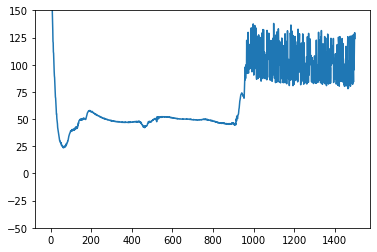

In [ ]:
env = gym.make(config["ENV"])
trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
action_dim = env.action_space.n
num_training_envs = config["NUM_TRAINING_ENVS"]

# run_seed = run_seed
batch_size = config["BATCH_SIZE"]
teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
teacher.load_pretrained()

buffer = fill_buffer(
    trajs_path=teacher.trajs_paths,
    batch_size=batch_size,
    run_seed=run_seed,
    traj_shift=config["TRAJ_SHIFT"],
    buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
    sampling_rate=config["SAMPLING_RATE"],
)

if buffer.total_size < batch_size:
    batch_size = buffer.total_size



##########################      COMMON      ##########################

print("state_dim", state_dim)

causal_features_encoder = FeaturesEncoder(
    input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
)

policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])




##########################       iVAE IRM       #######################


print("\n ***** Start Phase 1 ***** \n")

config['LATENT_DIM'] = state_dim  -1 # - 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

print("latent dim = ", config['LATENT_DIM'] )


ckpt_file = './vae/' + 'CartPole_partA_nfivae_ckpt.pt' #'./vae/' + config['ENV'] +'nfivae_ckpt.pt',
pa_dict_file =  './vae/' + 'CartPole_partA_nfivae_padict.pkl' #'./vae/' + config['ENV'] +'nfivae_padict.pkl',

vae_wrapper =  NFiVAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                            use_e = True, model_type= config['MODEL_TYPE'], lr = 1e-3, pa_dict_file = pa_dict_file, ckpt_file = ckpt_file, parents_threshold = config['PARENT_THRESHOLD'])

loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])#.cpu()

import matplotlib.pyplot as plt
plt.plot((np.array(loss_list)))
plt.ylim(-50,150)
plt.show()



# make student

In [5]:
config['MODEL_TYPE'] = 'NFiVAE'

In [6]:


# pylint: disable=redefined-outer-name
def make_student(run_seed, config):
    env = gym.make(config["ENV"])
    trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
    model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

    state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
    action_dim = env.action_space.n
    num_training_envs = config["NUM_TRAINING_ENVS"]

    # run_seed = run_seed
    batch_size = config["BATCH_SIZE"]
    teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
    teacher.load_pretrained()

    buffer = fill_buffer(
        trajs_path=teacher.trajs_paths,
        batch_size=batch_size,
        run_seed=run_seed,
        traj_shift=config["TRAJ_SHIFT"],
        buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
        sampling_rate=config["SAMPLING_RATE"],
    )

    if buffer.total_size < batch_size:
        batch_size = buffer.total_size



    ##########################      COMMON      ##########################

    print("state_dim", state_dim)

    causal_features_encoder = FeaturesEncoder(
        input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
    )

    policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])



    ##########################       BC       #######################

    if config['METHOD'] == 'BC':

        return BCStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


    ##########################       BC IRM       #######################


    elif config['METHOD'] == 'BCIRM':

        return BCIRMStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )



    ##########################       iVAE IRM       #######################

    elif config['METHOD'] == 'iVAE_IRM':


        print("\n ***** Start Phase 1 ***** \n")

        config['LATENT_DIM'] = state_dim  #- 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

        print("latent dim = ", config['LATENT_DIM'] )


        ckpt_file = './vae/' + 'CartPole_partB_nfivae_ckpt.pt' #'./vae/' + config['ENV'] +'nfivae_ckpt.pt',
        pa_dict_file =  './vae/' + 'CartPole_partB_nfivae_padict.pkl' #'./vae/' + config['ENV'] +'nfivae_padict.pkl',

        vae_wrapper =  NFiVAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                                   use_e = True, model_type= config['MODEL_TYPE'], lr = 1e-3, pa_dict_file = pa_dict_file, ckpt_file = ckpt_file, parents_threshold = config['PARENT_THRESHOLD'])
 
        loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])#.cpu()

        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot((np.array(loss_list)))
        plt.yscale("log")
        #plt.ylim(-50,150)
        plt.show()


        plt.figure()
        plt.plot((np.array(loss_list)))
        #plt.yscale("log")
        plt.ylim(-50,150)
        plt.show()




        ########################################

        print("\n ***** Start Phase 2 ***** \n")
        if config['SELECT_PARENTS'] == True:
            vae_wrapper.start_phase2(n_samples = config['PHASE2_SAMPLES'])
        else:
            vae_wrapper.pa_list = [0,1,2,3,4,5,6,7] #, 8, 9, 10, 11]
        
        policy_network = StudentNetwork(in_dim=len(vae_wrapper.pa_list), out_dim=action_dim, width=config["MLP_WIDTHS"])
        
        #phase3_obs_to_latent_encoder = Phase3ObstoLatentEncoder(obs_size = state_dim, latent_size = len(vae_wrapper.pa_list))
            #input_size=state_dim, representation_size=len(vae_wrapper.pa_list), width=config["MLP_WIDTHS"] )
        
        
        return NFiVAE_IRMStudent(
            env=env,
            vae_wrapper = vae_wrapper,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            #phase3_obs_to_latent_encoder = phase3_obs_to_latent_encoder,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )
        


    ##########################       ICIL        #######################

    elif config['METHOD'] == 'ICIL':
        energy_model = EnergyModel(
            in_dim=state_dim,
            width=config["MLP_WIDTHS"],
            batch_size=batch_size,
            adam_alpha=config["ADAM_ALPHA"],
            buffer=buffer,
            sgld_buffer_size=config["SGLD_BUFFER_SIZE"],
            sgld_learn_rate=config["SGLD_LEARN_RATE"],
            sgld_noise_coef=config["SGLD_NOISE_COEF"],
            sgld_num_steps=config["SGLD_NUM_STEPS"],
            sgld_reinit_freq=config["SGLD_REINIT_FREQ"],
        )
        energy_model.train(num_updates=config["NUM_STEPS_TRAIN_ENERGY_MODEL"])

        causal_features_decoder = FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        observations_decoder = ObservationsDecoder(representation_size=config["REP_SIZE"], out_size=state_dim, width=config["MLP_WIDTHS"] )

        env_discriminator = EnvDiscriminator(representation_size=config["REP_SIZE"], num_envs=config["NUM_TRAINING_ENVS"], width=config["MLP_WIDTHS"])

        noise_features_encoders = [FeaturesEncoder(input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])  
            for i in range(num_training_envs)]
        
        noise_features_decoders = [FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])
            for i in range(num_training_envs)]

        mine_network = MineNetwork(x_dim=config["REP_SIZE"], z_dim=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        return ICILStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            noise_features_encoders=noise_features_encoders,
            causal_features_decoder=causal_features_decoder,
            noise_features_decoders=noise_features_decoders,
            observations_decoder=observations_decoder,
            env_discriminator=env_discriminator,
            policy_network=policy_network,
            energy_model=energy_model,
            mine_network=mine_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--env_name", default="CartPole-v1")
    parser.add_argument("--num_trajectories", default=20, type=int)
    parser.add_argument("--trial", default=0, type=int)
    return parser.parse_args()


# iVAE [threshold = 1]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 1

batch size =  50000
Config: {'ALG': 'May2_iVAE_test1_th1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'iVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 1, 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.903217792510986best loss model loaded, stored at update # 1467


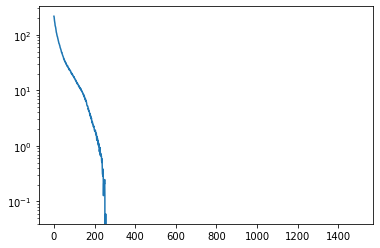

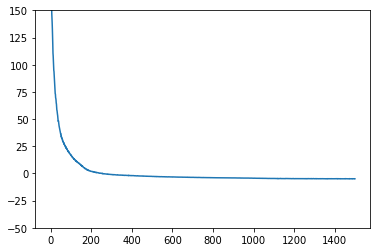


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.046704164426871676 and pval_i=0.9071061269692335
0 and 2 are independent with pval_d=0.4887607265114926 and pval_i=0.979764728057732
0 and 3 are DEPENDENT with pval_d=5.501862872926743e-05 and pval_i=2.616639180500179e-05
0 and 4 are independent with pval_d=0.7761200986502068 and pval_i=0.9997628796493164
0 and 5 are independent with pval_d=0.012681522498423185 and pval_i=0.9997165177490143
0 and 6 are independent with pval_d=0.7808529873326449 and pval_i=0.9778039130931143
0 and 7 are independent with pval_d=0.9933030403062958 and pval_i=0.9997911035095013
1 and 2 are DEPENDENT with pval_d=1.7562725408267027e-05 and pval_i=9.446384980668296e-08
1 and 3 are independent with pval_d=1.2019000578502023e-09 and pval_i=1.3478502239971365e-09
1 and 4 are independent with pval_d=0.029613677313365453 and pval_i=0.7335336422541004
1 and 5 are independent with pval_d=0.0002

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/student/nfivae_irm_student.py:287: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  x = torch.FloatTensor(all_states).to(self.device)


generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:02<03:31,  2.14s/it]

0 96.40484091639519


  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

1 91.08942840993404


  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

2 90.97139924764633


  4%|▍         | 4/100 [00:08<03:25,  2.14s/it]

3 90.90979181230068


  5%|▌         | 5/100 [00:10<03:21,  2.12s/it]

4 90.85547505319118


  6%|▌         | 6/100 [00:12<03:18,  2.11s/it]

5 90.84287630021572


  7%|▋         | 7/100 [00:14<03:16,  2.11s/it]

6 90.83834651112556


  8%|▊         | 8/100 [00:16<03:15,  2.12s/it]

7 90.79152649641037


  9%|▉         | 9/100 [00:19<03:13,  2.13s/it]

8 90.63685055077076


 10%|█         | 10/100 [00:21<03:11,  2.13s/it]

9 90.68296597898006


 11%|█         | 11/100 [00:23<03:10,  2.14s/it]

10 90.65597888827324


 12%|█▏        | 12/100 [00:25<03:07,  2.13s/it]

11 90.69404019415379


 13%|█▎        | 13/100 [00:27<03:06,  2.15s/it]

12 90.59841699898243


 14%|█▍        | 14/100 [00:29<03:03,  2.14s/it]

13 90.56237033009529


 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

14 90.52711322903633


 16%|█▌        | 16/100 [00:34<02:58,  2.12s/it]

15 90.57345992326736


 17%|█▋        | 17/100 [00:36<02:55,  2.12s/it]

16 90.50301702320576


 18%|█▊        | 18/100 [00:38<02:54,  2.12s/it]

17 90.49876345694065


 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

18 90.48681400716305


 20%|██        | 20/100 [00:42<02:50,  2.13s/it]

19 90.46434792876244


 21%|██        | 21/100 [00:44<02:48,  2.13s/it]

20 90.50620241463184


 22%|██▏       | 22/100 [00:46<02:45,  2.13s/it]

21 90.4684968739748


 23%|██▎       | 23/100 [00:48<02:44,  2.13s/it]

22 90.50244557857513


 24%|██▍       | 24/100 [00:51<02:41,  2.12s/it]

23 90.39305485785007


 25%|██▌       | 25/100 [00:53<02:39,  2.13s/it]

24 90.41697360575199


 26%|██▌       | 26/100 [00:55<02:37,  2.13s/it]

25 90.43089807033539


 27%|██▋       | 27/100 [00:57<02:35,  2.13s/it]

26 90.39093978703022


 28%|██▊       | 28/100 [00:59<02:33,  2.13s/it]

27 90.36807265877724


 29%|██▉       | 29/100 [01:01<02:31,  2.13s/it]

28 90.41278478503227


 30%|███       | 30/100 [01:03<02:29,  2.14s/it]

29 90.39538110792637


 31%|███       | 31/100 [01:05<02:26,  2.13s/it]

30 90.4064394980669


 32%|███▏      | 32/100 [01:08<02:25,  2.13s/it]

31 90.39852902293205


 33%|███▎      | 33/100 [01:10<02:22,  2.12s/it]

32 90.39986965060234


 34%|███▍      | 34/100 [01:12<02:20,  2.12s/it]

33 90.34121251106262


 35%|███▌      | 35/100 [01:14<02:17,  2.12s/it]

34 90.32451336085796


 36%|███▌      | 36/100 [01:16<02:15,  2.11s/it]

35 90.40374663472176


 37%|███▋      | 37/100 [01:18<02:13,  2.12s/it]

36 90.34113450348377


 38%|███▊      | 38/100 [01:20<02:11,  2.12s/it]

37 90.3598011136055


 39%|███▉      | 39/100 [01:22<02:09,  2.13s/it]

38 90.37964133918285


 40%|████      | 40/100 [01:25<02:07,  2.13s/it]

39 90.39377804100513


 41%|████      | 41/100 [01:27<02:05,  2.13s/it]

40 90.33839198946953


 42%|████▏     | 42/100 [01:29<02:03,  2.13s/it]

41 90.31451070308685


 43%|████▎     | 43/100 [01:31<02:01,  2.13s/it]

42 90.32118239998817


 44%|████▍     | 44/100 [01:33<01:59,  2.13s/it]

43 90.34704524278641


 45%|████▌     | 45/100 [01:35<01:57,  2.14s/it]

44 90.34029886126518


 46%|████▌     | 46/100 [01:37<01:55,  2.15s/it]

45 90.32760941982269


 47%|████▋     | 47/100 [01:40<01:53,  2.13s/it]

46 90.3227728009224


 48%|████▊     | 48/100 [01:42<01:50,  2.13s/it]

47 90.4133003950119


 49%|████▉     | 49/100 [01:44<01:48,  2.13s/it]

48 90.34222657978535


 50%|█████     | 50/100 [01:46<01:46,  2.13s/it]

49 90.35194118320942


 51%|█████     | 51/100 [01:48<01:44,  2.12s/it]

50 90.26477354764938


 52%|█████▏    | 52/100 [01:50<01:41,  2.12s/it]

51 90.31952422857285


 53%|█████▎    | 53/100 [01:52<01:40,  2.13s/it]

52 90.33106236159801


 54%|█████▍    | 54/100 [01:54<01:37,  2.13s/it]

53 90.31433236598969


 55%|█████▌    | 55/100 [01:57<01:35,  2.12s/it]

54 90.34037679433823


 56%|█████▌    | 56/100 [01:59<01:33,  2.11s/it]

55 90.31278674304485


 57%|█████▋    | 57/100 [02:01<01:31,  2.12s/it]

56 90.3016811311245


 58%|█████▊    | 58/100 [02:03<01:29,  2.14s/it]

57 90.33435483276844


 59%|█████▉    | 59/100 [02:05<01:27,  2.13s/it]

58 90.36573176085949


 60%|██████    | 60/100 [02:07<01:25,  2.14s/it]

59 90.34087350964546


 61%|██████    | 61/100 [02:09<01:23,  2.13s/it]

60 90.31139999628067


 62%|██████▏   | 62/100 [02:11<01:20,  2.13s/it]

61 90.36068895459175


 63%|██████▎   | 63/100 [02:14<01:18,  2.12s/it]

62 90.28298312425613


 64%|██████▍   | 64/100 [02:16<01:16,  2.13s/it]

63 90.2963756620884


 65%|██████▌   | 65/100 [02:18<01:14,  2.12s/it]

64 90.34661346673965


 66%|██████▌   | 66/100 [02:20<01:11,  2.12s/it]

65 90.28521928191185


 67%|██████▋   | 67/100 [02:22<01:09,  2.12s/it]

66 90.32887177169323


 68%|██████▊   | 68/100 [02:24<01:07,  2.11s/it]

67 90.31701222062111


 69%|██████▉   | 69/100 [02:26<01:05,  2.11s/it]

68 90.33077220618725


 70%|███████   | 70/100 [02:28<01:03,  2.12s/it]

69 90.27521003782749


 71%|███████   | 71/100 [02:30<01:01,  2.11s/it]

70 90.27960985898972


 72%|███████▏  | 72/100 [02:33<00:59,  2.12s/it]

71 90.31637914478779


 73%|███████▎  | 73/100 [02:35<00:57,  2.13s/it]

72 90.2961019128561


 74%|███████▍  | 74/100 [02:37<00:55,  2.13s/it]

73 90.30509127676487


 75%|███████▌  | 75/100 [02:39<00:53,  2.13s/it]

74 90.34216704964638


 76%|███████▌  | 76/100 [02:41<00:50,  2.12s/it]

75 90.29134692251682


 77%|███████▋  | 77/100 [02:43<00:48,  2.11s/it]

76 90.30562463402748


 78%|███████▊  | 78/100 [02:45<00:46,  2.11s/it]

77 90.3065720051527


 79%|███████▉  | 79/100 [02:47<00:44,  2.12s/it]

78 90.31922556459904


 80%|████████  | 80/100 [02:50<00:42,  2.12s/it]

79 90.32333563268185


 81%|████████  | 81/100 [02:52<00:40,  2.12s/it]

80 90.293068125844


 82%|████████▏ | 82/100 [02:54<00:38,  2.12s/it]

81 90.30429916083813


 83%|████████▎ | 83/100 [02:56<00:36,  2.12s/it]

82 90.30695196986198


 84%|████████▍ | 84/100 [02:58<00:34,  2.13s/it]

83 90.285973533988


 85%|████████▌ | 85/100 [03:00<00:31,  2.13s/it]

84 90.32085989415646


 86%|████████▌ | 86/100 [03:02<00:29,  2.12s/it]

85 90.2753042280674


 87%|████████▋ | 87/100 [03:05<00:27,  2.14s/it]

86 90.29505056142807


 88%|████████▊ | 88/100 [03:07<00:25,  2.13s/it]

87 90.30682767927647


 89%|████████▉ | 89/100 [03:09<00:23,  2.13s/it]

88 90.28272946178913


 90%|█████████ | 90/100 [03:11<00:21,  2.13s/it]

89 90.28553974628448


 91%|█████████ | 91/100 [03:13<00:19,  2.13s/it]

90 90.31311900913715


 92%|█████████▏| 92/100 [03:15<00:16,  2.12s/it]

91 90.33539009094238


 93%|█████████▎| 93/100 [03:17<00:14,  2.14s/it]

92 90.3080422282219


 94%|█████████▍| 94/100 [03:19<00:12,  2.14s/it]

93 90.2726783901453


 95%|█████████▌| 95/100 [03:22<00:10,  2.13s/it]

94 90.30861128866673


 96%|█████████▌| 96/100 [03:24<00:08,  2.11s/it]

95 90.26310162246227


 97%|█████████▋| 97/100 [03:26<00:06,  2.12s/it]

96 90.32840000092983


 98%|█████████▊| 98/100 [03:28<00:04,  2.12s/it]

97 90.2822800129652


 99%|█████████▉| 99/100 [03:30<00:02,  2.13s/it]

98 90.31310719251633


100%|██████████| 100/100 [03:32<00:00,  2.13s/it]

99 90.27418404817581

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.0755009576678276	

epoch 9000/10000, policy loss 0.05427476763725281	
***** test student *****
epoch 0/100 return: 74.0
epoch 1/100 return: 57.0
epoch 2/100 return: 38.0
epoch 3/100 return: 33.0
epoch 4/100 return: 34.0
epoch 5/100 return: 56.0
epoch 6/100 return: 56.0
epoch 7/100 return: 100.0
epoch 8/100 return: 56.0
epoch 9/100 return: 55.0
epoch 10/100 return: 38.0
epoch 11/100 return: 71.0
epoch 12/100 return: 69.0
epoch 13/100 return: 61.0
epoch 14/100 return: 38.0
epoch 15/100 return: 34.0
epoch 16/100 return: 78.0
epoch 17/100 return: 54.0
epoch 18/100 return: 50.0
epoch 19/100 return: 44.0
epoch 20/100 return: 40.0
epoch 21/100 return: 36.0
epoch 22/100 return: 53.0
epoch 23/100 return: 28.0
epoch 24/100 return: 27.0
epoch 25/100 return: 33.0
epoch 26/100 return: 146.0
epoch 27/100 return: 33.0
epoch 28/100 return: 44.0
epoch 29/100 return: 43.0
epoch 30/100 return: 52.0
epoch 31/100 return: 103.0
epoch 32/100 return: 53.0
epoch 33/100 return: 40.0
epoch 34/100 return: 30.0
epoch 35/100 return: 

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May2_iVAE_test1_th1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_iVAE_1 = policy_loss_list

In [ ]:
return_std

21.828465360624875

In [ ]:
return_mean

53.59

In [ ]:
policy_loss_list_iVAE_1[-1]

tensor(0.0540, device='cuda:0')

# iVAE [threshold = -1]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

batch size =  50000
Config: {'ALG': 'May2_iVAE_test1_thneg1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'iVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.903217792510986best loss model loaded, stored at update # 1467


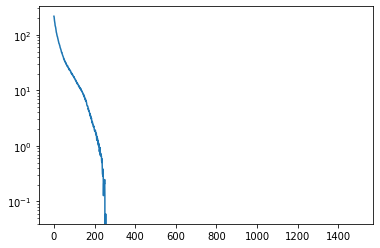

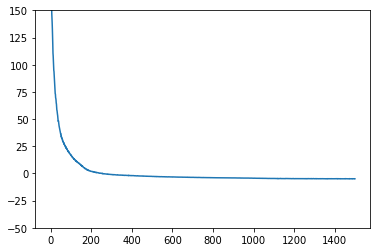


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.046704164426871676 and pval_i=0.9071061269692335
0 and 2 are independent with pval_d=0.4887607265114926 and pval_i=0.979764728057732
0 and 3 are DEPENDENT with pval_d=5.501862872926743e-05 and pval_i=2.616639180500179e-05
0 and 4 are independent with pval_d=0.7761200986502068 and pval_i=0.9997628796493164
0 and 5 are independent with pval_d=0.012681522498423185 and pval_i=0.9997165177490143
0 and 6 are independent with pval_d=0.7808529873326449 and pval_i=0.9778039130931143
0 and 7 are independent with pval_d=0.9933030403062958 and pval_i=0.9997911035095013
1 and 2 are DEPENDENT with pval_d=1.7562725408267027e-05 and pval_i=9.446384980668296e-08
1 and 3 are independent with pval_d=1.2019000578502023e-09 and pval_i=1.3478502239971365e-09
1 and 4 are independent with pval_d=0.029613677313365453 and pval_i=0.7335336422541004
1 and 5 are independent with pval_d=0.0002

  1%|          | 1/100 [00:02<03:30,  2.12s/it]

0 77.70198053121567


  2%|▏         | 2/100 [00:04<03:29,  2.14s/it]

1 73.64874278008938


  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]

2 73.51651705801487


  4%|▍         | 4/100 [00:08<03:24,  2.14s/it]

3 73.51286640763283


  5%|▌         | 5/100 [00:10<03:21,  2.13s/it]

4 73.3567329198122


  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

5 73.388192653656


  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

6 73.33570994436741


  8%|▊         | 8/100 [00:17<03:17,  2.14s/it]

7 73.35791347920895


  9%|▉         | 9/100 [00:19<03:14,  2.14s/it]

8 73.24770650267601


 10%|█         | 10/100 [00:21<03:12,  2.14s/it]

9 73.2988345772028


 11%|█         | 11/100 [00:23<03:09,  2.13s/it]

10 73.25163233280182


 12%|█▏        | 12/100 [00:25<03:08,  2.14s/it]

11 73.28201705217361


 13%|█▎        | 13/100 [00:27<03:06,  2.14s/it]

12 73.22592125833035


 14%|█▍        | 14/100 [00:29<03:02,  2.13s/it]

13 73.18857015669346


 15%|█▌        | 15/100 [00:32<03:00,  2.13s/it]

14 73.17984180152416


 16%|█▌        | 16/100 [00:34<02:58,  2.13s/it]

15 73.22220854461193


 17%|█▋        | 17/100 [00:36<02:58,  2.15s/it]

16 73.16138136386871


 18%|█▊        | 18/100 [00:38<02:56,  2.15s/it]

17 73.17533530294895


 19%|█▉        | 19/100 [00:41<03:06,  2.31s/it]

18 73.14808867871761


 20%|██        | 20/100 [00:43<03:01,  2.27s/it]

19 73.15825229883194


 21%|██        | 21/100 [00:45<02:56,  2.23s/it]

20 73.15757627785206


 22%|██▏       | 22/100 [00:47<02:52,  2.21s/it]

21 73.12468186020851


 23%|██▎       | 23/100 [00:49<02:48,  2.19s/it]

22 73.14448295533657


 24%|██▍       | 24/100 [00:51<02:44,  2.17s/it]

23 73.05365233123302


 25%|██▌       | 25/100 [00:54<02:42,  2.16s/it]

24 73.09940895438194


 26%|██▌       | 26/100 [00:56<02:40,  2.17s/it]

25 73.08753074705601


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

26 73.0389820933342


 28%|██▊       | 28/100 [01:00<02:35,  2.16s/it]

27 73.05198606848717


 29%|██▉       | 29/100 [01:02<02:32,  2.15s/it]

28 73.06413424015045


 30%|███       | 30/100 [01:04<02:30,  2.15s/it]

29 73.0539824962616


 31%|███       | 31/100 [01:06<02:28,  2.16s/it]

30 73.05616727471352


 32%|███▏      | 32/100 [01:09<02:26,  2.15s/it]

31 73.05598402023315


 33%|███▎      | 33/100 [01:11<02:23,  2.15s/it]

32 73.04672683775425


 34%|███▍      | 34/100 [01:13<02:21,  2.14s/it]

33 73.0061661452055


 35%|███▌      | 35/100 [01:15<02:18,  2.14s/it]

34 73.03076849877834


 36%|███▌      | 36/100 [01:17<02:17,  2.15s/it]

35 73.01734054088593


 37%|███▋      | 37/100 [01:19<02:15,  2.14s/it]

36 73.02621525526047


 38%|███▊      | 38/100 [01:21<02:13,  2.15s/it]

37 73.03702665865421


 39%|███▉      | 39/100 [01:24<02:10,  2.14s/it]

38 73.02706995606422


 40%|████      | 40/100 [01:26<02:08,  2.14s/it]

39 73.05595462024212


 41%|████      | 41/100 [01:28<02:06,  2.15s/it]

40 73.04135946929455


 42%|████▏     | 42/100 [01:30<02:03,  2.13s/it]

41 72.99617789685726


 43%|████▎     | 43/100 [01:32<02:01,  2.13s/it]

42 73.02713380753994


 44%|████▍     | 44/100 [01:34<01:59,  2.13s/it]

43 73.0144769847393


 45%|████▌     | 45/100 [01:36<01:57,  2.14s/it]

44 73.01446445286274


 46%|████▌     | 46/100 [01:39<01:55,  2.14s/it]

45 72.98642462491989


 47%|████▋     | 47/100 [01:41<01:53,  2.15s/it]

46 72.99292147159576


 48%|████▊     | 48/100 [01:43<01:52,  2.16s/it]

47 73.03878849744797


 49%|████▉     | 49/100 [01:45<01:50,  2.16s/it]

48 73.03404362499714


 50%|█████     | 50/100 [01:47<01:48,  2.16s/it]

49 73.00815892219543


 51%|█████     | 51/100 [01:49<01:45,  2.16s/it]

50 72.98202301561832


 52%|█████▏    | 52/100 [01:51<01:43,  2.15s/it]

51 73.00417396426201


 53%|█████▎    | 53/100 [01:54<01:40,  2.13s/it]

52 73.01707774400711


 54%|█████▍    | 54/100 [01:56<01:38,  2.14s/it]

53 72.99288067221642


 55%|█████▌    | 55/100 [01:58<01:36,  2.15s/it]

54 73.00671960413456


 56%|█████▌    | 56/100 [02:00<01:34,  2.15s/it]

55 72.99864400923252


 57%|█████▋    | 57/100 [02:02<01:32,  2.14s/it]

56 72.99801695346832


 58%|█████▊    | 58/100 [02:04<01:29,  2.14s/it]

57 72.99585400521755


 59%|█████▉    | 59/100 [02:06<01:27,  2.13s/it]

58 73.02445970475674


 60%|██████    | 60/100 [02:09<01:25,  2.14s/it]

59 73.01795701682568


 61%|██████    | 61/100 [02:11<01:23,  2.15s/it]

60 72.98838020861149


 62%|██████▏   | 62/100 [02:13<01:21,  2.14s/it]

61 73.0191356241703


 63%|██████▎   | 63/100 [02:15<01:19,  2.14s/it]

62 72.97391989827156


 64%|██████▍   | 64/100 [02:17<01:17,  2.14s/it]

63 72.9742775708437


 65%|██████▌   | 65/100 [02:19<01:14,  2.14s/it]

64 73.00185486674309


 66%|██████▌   | 66/100 [02:21<01:12,  2.14s/it]

65 72.99005328118801


 67%|██████▋   | 67/100 [02:24<01:10,  2.14s/it]

66 73.00004084408283


 68%|██████▊   | 68/100 [02:26<01:07,  2.12s/it]

67 72.98088431358337


 69%|██████▉   | 69/100 [02:28<01:06,  2.14s/it]

68 73.02037200331688


 70%|███████   | 70/100 [02:30<01:03,  2.13s/it]

69 72.97301986813545


 71%|███████   | 71/100 [02:32<01:01,  2.12s/it]

70 72.98698130249977


 72%|███████▏  | 72/100 [02:34<00:59,  2.11s/it]

71 72.98636223375797


 73%|███████▎  | 73/100 [02:36<00:56,  2.10s/it]

72 72.98177383840084


 74%|███████▍  | 74/100 [02:38<00:54,  2.11s/it]

73 73.0111813545227


 75%|███████▌  | 75/100 [02:40<00:52,  2.12s/it]

74 73.00441633164883


 76%|███████▌  | 76/100 [02:43<00:50,  2.12s/it]

75 72.98573340475559


 77%|███████▋  | 77/100 [02:45<00:48,  2.12s/it]

76 72.99796915054321


 78%|███████▊  | 78/100 [02:47<00:46,  2.13s/it]

77 72.9801077246666


 79%|███████▉  | 79/100 [02:49<00:44,  2.14s/it]

78 72.99438385665417


 80%|████████  | 80/100 [02:51<00:42,  2.14s/it]

79 73.00757250189781


 81%|████████  | 81/100 [02:53<00:40,  2.13s/it]

80 72.97995983064175


 82%|████████▏ | 82/100 [02:55<00:38,  2.13s/it]

81 72.98324857652187


 83%|████████▎ | 83/100 [02:58<00:36,  2.13s/it]

82 72.98525284230709


 84%|████████▍ | 84/100 [03:00<00:34,  2.14s/it]

83 72.97875614464283


 85%|████████▌ | 85/100 [03:02<00:32,  2.14s/it]

84 73.00525312125683


 86%|████████▌ | 86/100 [03:04<00:29,  2.13s/it]

85 72.98099833726883


 87%|████████▋ | 87/100 [03:06<00:27,  2.12s/it]

86 72.99144540727139


 88%|████████▊ | 88/100 [03:08<00:25,  2.12s/it]

87 72.9906819164753


 89%|████████▉ | 89/100 [03:10<00:23,  2.13s/it]

88 72.95707976818085


 90%|█████████ | 90/100 [03:12<00:21,  2.13s/it]

89 72.99086448550224


 91%|█████████ | 91/100 [03:15<00:19,  2.13s/it]

90 72.98477932810783


 92%|█████████▏| 92/100 [03:17<00:17,  2.13s/it]

91 72.99440525472164


 93%|█████████▎| 93/100 [03:19<00:14,  2.13s/it]

92 73.00109349191189


 94%|█████████▍| 94/100 [03:21<00:12,  2.12s/it]

93 72.97699296474457


 95%|█████████▌| 95/100 [03:23<00:10,  2.13s/it]

94 72.9883026778698


 96%|█████████▌| 96/100 [03:25<00:08,  2.12s/it]

95 72.9872899800539


 97%|█████████▋| 97/100 [03:27<00:06,  2.12s/it]

96 72.97911715507507


 98%|█████████▊| 98/100 [03:29<00:04,  2.12s/it]

97 72.97057622671127


 99%|█████████▉| 99/100 [03:32<00:02,  2.11s/it]

98 72.96374003589153


100%|██████████| 100/100 [03:34<00:00,  2.14s/it]

99 72.96535517275333

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.08412966132164001	

epoch 9000/10000, policy loss 0.048820480704307556	
***** test student *****
epoch 0/100 return: 19.0
epoch 1/100 return: 16.0
epoch 2/100 return: 19.0
epoch 3/100 return: 14.0
epoch 4/100 return: 16.0
epoch 5/100 return: 16.0
epoch 6/100 return: 15.0
epoch 7/100 return: 16.0
epoch 8/100 return: 14.0
epoch 9/100 return: 16.0
epoch 10/100 return: 18.0
epoch 11/100 return: 18.0
epoch 12/100 return: 17.0
epoch 13/100 return: 19.0
epoch 14/100 return: 19.0
epoch 15/100 return: 17.0
epoch 16/100 return: 17.0
epoch 17/100 return: 16.0
epoch 18/100 return: 17.0
epoch 19/100 return: 17.0
epoch 20/100 return: 18.0
epoch 21/100 return: 16.0
epoch 22/100 return: 15.0
epoch 23/100 return: 16.0
epoch 24/100 return: 13.0
epoch 25/100 return: 16.0
epoch 26/100 return: 16.0
epoch 27/100 return: 14.0
epoch 28/100 return: 19.0
epoch 29/100 return: 19.0
epoch 30/100 return: 16.0
epoch 31/100 return: 18.0
epoch 32/100 return: 19.0
epoch 33/100 return: 14.0
epoch 34/100 return: 18.0
epoch 35/100 return: 16

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May2_iVAE_test1_thneg1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_iVAE_neg1 = policy_loss_list

In [ ]:
return_std

21.828465360624875

In [ ]:
return_mean

53.59

# iVAE [threshold = -1, state_dim = 5]

In [ ]:
config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

batch size =  50000
Config: {'ALG': 'May2_iVAE_test1_thneg1_statedim5_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'iVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 1 out of 10

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****


***** VAE wrapper created with iVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -4.977195739746094best loss model loaded, stored at update # 1498


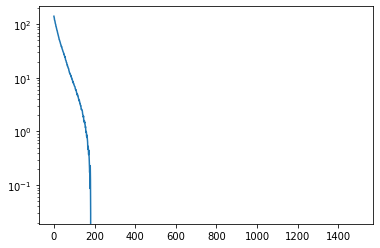

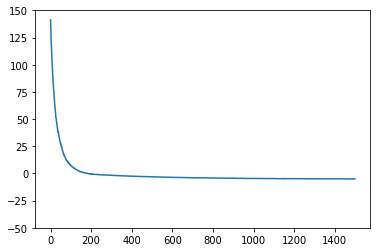


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000


In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May2_iVAE_test1_thneg1_statedim5_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_iVAE_neg1 = policy_loss_list

In [ ]:
return_std

21.828465360624875

In [ ]:
return_mean

53.59

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = -1, state_dim = 5]

In [7]:
config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

batch size =  50000
Config: {'ALG': 'May1_test2_thneg1_state5_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 1 out of 10

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 150.20611572265625best loss model loaded, stored at update # 458


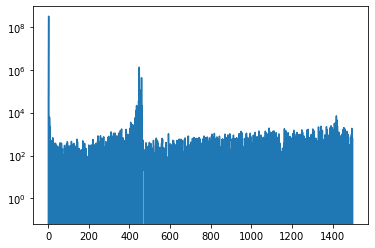

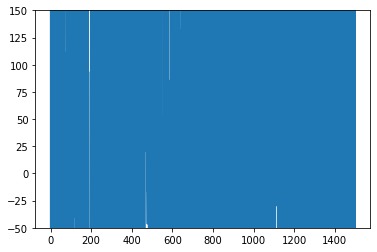


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=1.3787124415744157e-09 and pval_i=5.085897621768859e-07
0 and 2 are independent with pval_d=2.811000252990323e-08 and pval_i=1.5569337549731526e-05
0 and 3 are independent with pval_d=0.00010433374625935107 and pval_i=0.11897184660759194
0 and 4 are DEPENDENT with pval_d=0.002789548999436798 and pval_i=3.279852135897419e-05
1 and 2 are independent with pval_d=6.167230529668239e-11 and pval_i=7.833824400889825e-11
1 and 3 are DEPENDENT with pval_d=0.00032072691262220374 and pval_i=2.9458531747116545e-05
1 and 4 are independent with pval_d=4.34917160218254e-05 and pval_i=0.004023113133540474
2 and 3 are DEPENDENT with pval_d=3.5900782669523896e-05 and pval_i=5.124300397510558e-07
2 and 4 are independent with pval_d=1.8213921318501757e-08 and pval_i=4.3715423790957334e-06
3 and 4 are independent with pval_d=1.3724570034889618e-05 and pval_i=0.00019063791965964687
3 2
0

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/student/nfivae_irm_student.py:287: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  x = torch.FloatTensor(all_states).to(self.device)
  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:23,  1.45s/it]

0 264.50001752376556


  2%|▏         | 2/100 [00:02<02:21,  1.44s/it]

1 252.0811649262905


  3%|▎         | 3/100 [00:04<02:20,  1.45s/it]

2 251.641377389431


  4%|▍         | 4/100 [00:05<02:18,  1.44s/it]

3 251.49230307340622


  5%|▌         | 5/100 [00:07<02:17,  1.45s/it]

4 251.45245054364204


  6%|▌         | 6/100 [00:08<02:16,  1.45s/it]

5 251.39607763290405


  7%|▋         | 7/100 [00:10<02:14,  1.44s/it]

6 251.40640172362328


  8%|▊         | 8/100 [00:11<02:12,  1.44s/it]

7 251.23473450541496


  9%|▉         | 9/100 [00:13<02:11,  1.45s/it]

8 251.18318438529968


 10%|█         | 10/100 [00:14<02:10,  1.45s/it]

9 251.21763834357262


 11%|█         | 11/100 [00:15<02:08,  1.44s/it]

10 251.2044937312603


 12%|█▏        | 12/100 [00:17<02:06,  1.44s/it]

11 251.1066212952137


 13%|█▎        | 13/100 [00:18<02:05,  1.45s/it]

12 251.0867304801941


 14%|█▍        | 14/100 [00:20<02:04,  1.45s/it]

13 250.99868071079254


 15%|█▌        | 15/100 [00:21<02:02,  1.44s/it]

14 251.06580677628517


 16%|█▌        | 16/100 [00:23<02:02,  1.46s/it]

15 251.0767121911049


 17%|█▋        | 17/100 [00:24<02:00,  1.46s/it]

16 250.90884491801262


 18%|█▊        | 18/100 [00:26<01:59,  1.45s/it]

17 250.8852516412735


 19%|█▉        | 19/100 [00:27<01:57,  1.45s/it]

18 250.9113785326481


 20%|██        | 20/100 [00:28<01:56,  1.45s/it]

19 250.87603923678398


 21%|██        | 21/100 [00:30<01:54,  1.45s/it]

20 250.94014117121696


 22%|██▏       | 22/100 [00:31<01:53,  1.45s/it]

21 250.95193204283714


 23%|██▎       | 23/100 [00:33<01:51,  1.44s/it]

22 250.8671877682209


 24%|██▍       | 24/100 [00:34<01:50,  1.45s/it]

23 250.85193020105362


 25%|██▌       | 25/100 [00:36<01:48,  1.45s/it]

24 250.84526565670967


 26%|██▌       | 26/100 [00:37<01:47,  1.45s/it]

25 250.77760261297226


 27%|██▋       | 27/100 [00:39<01:46,  1.46s/it]

26 250.85075974464417


 28%|██▊       | 28/100 [00:40<01:45,  1.47s/it]

27 250.8552165031433


 29%|██▉       | 29/100 [00:42<01:44,  1.48s/it]

28 250.78544226288795


 30%|███       | 30/100 [00:43<01:43,  1.48s/it]

29 250.77492463588715


 31%|███       | 31/100 [00:45<01:41,  1.48s/it]

30 250.87971875071526


 32%|███▏      | 32/100 [00:46<01:40,  1.48s/it]

31 250.81901210546494


 33%|███▎      | 33/100 [00:48<01:39,  1.48s/it]

32 250.77130544185638


 34%|███▍      | 34/100 [00:49<01:38,  1.49s/it]

33 250.8044834136963


 35%|███▌      | 35/100 [00:50<01:35,  1.47s/it]

34 250.82370901107788


 36%|███▌      | 36/100 [00:52<01:34,  1.47s/it]

35 250.6898949444294


 37%|███▋      | 37/100 [00:53<01:31,  1.46s/it]

36 250.80003237724304


 38%|███▊      | 38/100 [00:55<01:37,  1.58s/it]

37 250.7599103152752


 39%|███▉      | 39/100 [00:57<01:34,  1.55s/it]

38 250.7354687154293


 40%|████      | 40/100 [00:58<01:31,  1.53s/it]

39 250.76494240760803


 41%|████      | 41/100 [01:00<01:28,  1.50s/it]

40 250.7582222521305


 42%|████▏     | 42/100 [01:01<01:25,  1.48s/it]

41 250.80086609721184


 43%|████▎     | 43/100 [01:02<01:23,  1.46s/it]

42 250.7120944261551


 44%|████▍     | 44/100 [01:04<01:21,  1.46s/it]

43 250.7658827006817


 45%|████▌     | 45/100 [01:05<01:19,  1.45s/it]

44 250.7176770567894


 46%|████▌     | 46/100 [01:07<01:18,  1.45s/it]

45 250.72889098525047


 47%|████▋     | 47/100 [01:08<01:16,  1.45s/it]

46 250.74603936076164


 48%|████▊     | 48/100 [01:10<01:15,  1.45s/it]

47 250.74642622470856


 49%|████▉     | 49/100 [01:11<01:14,  1.45s/it]

48 250.7384496629238


 50%|█████     | 50/100 [01:13<01:12,  1.45s/it]

49 250.7156094610691


 51%|█████     | 51/100 [01:14<01:11,  1.45s/it]

50 250.64526414871216


 52%|█████▏    | 52/100 [01:16<01:09,  1.45s/it]

51 250.73519924283028


 53%|█████▎    | 53/100 [01:17<01:08,  1.46s/it]

52 250.63282942771912


 54%|█████▍    | 54/100 [01:18<01:06,  1.45s/it]

53 250.68815430998802


 55%|█████▌    | 55/100 [01:20<01:05,  1.46s/it]

54 250.70483005046844


 56%|█████▌    | 56/100 [01:21<01:04,  1.46s/it]

55 250.63275507092476


 57%|█████▋    | 57/100 [01:23<01:02,  1.46s/it]

56 250.72343483567238


 58%|█████▊    | 58/100 [01:24<01:01,  1.46s/it]

57 250.75390070676804


 59%|█████▉    | 59/100 [01:26<00:59,  1.45s/it]

58 250.73697260022163


 60%|██████    | 60/100 [01:27<00:57,  1.45s/it]

59 250.6912522315979


 61%|██████    | 61/100 [01:29<00:56,  1.45s/it]

60 250.66158133745193


 62%|██████▏   | 62/100 [01:30<00:55,  1.45s/it]

61 250.70503067970276


 63%|██████▎   | 63/100 [01:32<00:53,  1.46s/it]

62 250.69138568639755


 64%|██████▍   | 64/100 [01:33<00:52,  1.45s/it]

63 250.74280086159706


 65%|██████▌   | 65/100 [01:34<00:50,  1.45s/it]

64 250.721905708313


 66%|██████▌   | 66/100 [01:36<00:48,  1.44s/it]

65 250.70942559838295


 67%|██████▋   | 67/100 [01:37<00:47,  1.44s/it]

66 250.642522752285


 68%|██████▊   | 68/100 [01:39<00:46,  1.44s/it]

67 250.71238747239113


 69%|██████▉   | 69/100 [01:40<00:44,  1.44s/it]

68 250.70048713684082


 70%|███████   | 70/100 [01:42<00:43,  1.44s/it]

69 250.73829206824303


 71%|███████   | 71/100 [01:43<00:41,  1.45s/it]

70 250.60388931632042


 72%|███████▏  | 72/100 [01:45<00:41,  1.49s/it]

71 250.6959373652935


 73%|███████▎  | 73/100 [01:46<00:42,  1.59s/it]

72 250.66941663622856


 74%|███████▍  | 74/100 [01:48<00:40,  1.54s/it]

73 250.68872648477554


 75%|███████▌  | 75/100 [01:49<00:38,  1.53s/it]

74 250.6769463121891


 76%|███████▌  | 76/100 [01:51<00:36,  1.51s/it]

75 250.64458853006363


 77%|███████▋  | 77/100 [01:52<00:34,  1.49s/it]

76 250.64933159947395


 78%|███████▊  | 78/100 [01:54<00:32,  1.48s/it]

77 250.698916554451


 79%|███████▉  | 79/100 [01:55<00:30,  1.47s/it]

78 250.6983136832714


 80%|████████  | 80/100 [01:57<00:29,  1.46s/it]

79 250.67700695991516


 81%|████████  | 81/100 [01:58<00:27,  1.47s/it]

80 250.65533554553986


 82%|████████▏ | 82/100 [02:00<00:26,  1.46s/it]

81 250.6306023299694


 83%|████████▎ | 83/100 [02:01<00:24,  1.47s/it]

82 250.63237756490707


 84%|████████▍ | 84/100 [02:02<00:23,  1.46s/it]

83 250.67966678738594


 85%|████████▌ | 85/100 [02:04<00:21,  1.46s/it]

84 250.65369188785553


 86%|████████▌ | 86/100 [02:05<00:20,  1.47s/it]

85 250.72728112339973


 87%|████████▋ | 87/100 [02:07<00:19,  1.47s/it]

86 250.67885652184486


 88%|████████▊ | 88/100 [02:08<00:17,  1.47s/it]

87 250.70838251709938


 89%|████████▉ | 89/100 [02:10<00:16,  1.47s/it]

88 250.68673676252365


 90%|█████████ | 90/100 [02:11<00:14,  1.48s/it]

89 250.70437064766884


 91%|█████████ | 91/100 [02:13<00:13,  1.47s/it]

90 250.63688400387764


 92%|█████████▏| 92/100 [02:14<00:11,  1.47s/it]

91 250.58417457342148


 93%|█████████▎| 93/100 [02:16<00:10,  1.48s/it]

92 250.6624400615692


 94%|█████████▍| 94/100 [02:17<00:08,  1.48s/it]

93 250.60589757561684


 95%|█████████▌| 95/100 [02:19<00:07,  1.47s/it]

94 250.69150203466415


 96%|█████████▌| 96/100 [02:20<00:05,  1.48s/it]

95 250.62956422567368


 97%|█████████▋| 97/100 [02:22<00:04,  1.48s/it]

96 250.6368273794651


 98%|█████████▊| 98/100 [02:23<00:02,  1.48s/it]

97 250.64262548089027


 99%|█████████▉| 99/100 [02:25<00:01,  1.47s/it]

98 250.5938374698162


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]

99 250.65998539328575

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.08929790556430817	

epoch 9000/10000, policy loss 0.0327724926173687	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 429.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 479.0
epoch 10/100 return: 71.0
epoch 11/100 return: 500.0
epoch 12/100 return: 342.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 421.0
epoch 19/100 return: 403.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 373.0
epoch 25/100 return: 500.0
epoch 26/100 return: 326.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 115.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 retur

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -57.70680618286133best loss model loaded, stored at update # 221


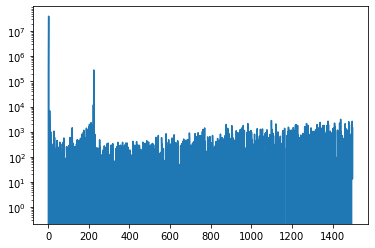

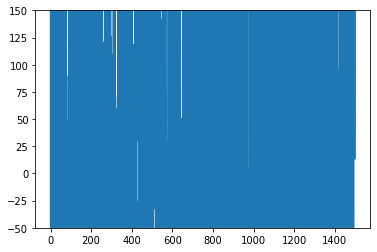


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=7.657314382700128e-06 and pval_i=0.6444198739027773
0 and 2 are DEPENDENT with pval_d=0.0002152170234450965 and pval_i=3.326392075962325e-06
0 and 3 are independent with pval_d=0.5668835109227746 and pval_i=0.582186919509959
0 and 4 are independent with pval_d=0.00011750666245454232 and pval_i=0.0004979891831499803
1 and 2 are independent with pval_d=0.186778973526971 and pval_i=0.6457510477027102
1 and 3 are independent with pval_d=0.0301175318485539 and pval_i=0.9860757825025842
1 and 4 are DEPENDENT with pval_d=0.9691170535056385 and pval_i=0.928840588332417
2 and 3 are DEPENDENT with pval_d=0.008102478150664881 and pval_i=5.4847949028868626e-05
2 and 4 are DEPENDENT with pval_d=4.339003692655282e-06 and pval_i=8.789339597349698e-07
3 and 4 are independent with pval_d=0.006871112733819522 and pval_i=0.015481339031663783
2 3
4 2
0 1
1 1
3 1
parent list: [0, 1, 2, 

  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:27,  1.49s/it]

0 344.9130963087082


  2%|▏         | 2/100 [00:02<02:26,  1.49s/it]

1 343.6304263472557


  3%|▎         | 3/100 [00:04<02:25,  1.50s/it]

2 343.3844956755638


  4%|▍         | 4/100 [00:06<02:24,  1.50s/it]

3 343.35007244348526


  5%|▌         | 5/100 [00:07<02:22,  1.50s/it]

4 343.3047538995743


  6%|▌         | 6/100 [00:09<02:21,  1.50s/it]

5 343.2984391450882


  7%|▋         | 7/100 [00:10<02:19,  1.50s/it]

6 343.3062711954117


  8%|▊         | 8/100 [00:12<02:17,  1.50s/it]

7 343.26017266511917


  9%|▉         | 9/100 [00:13<02:15,  1.49s/it]

8 343.1999121904373


 10%|█         | 10/100 [00:14<02:13,  1.49s/it]

9 343.285610973835


 11%|█         | 11/100 [00:16<02:11,  1.48s/it]

10 343.19934260845184


 12%|█▏        | 12/100 [00:17<02:10,  1.48s/it]

11 343.256733417511


 13%|█▎        | 13/100 [00:19<02:08,  1.47s/it]

12 343.19847053289413


 14%|█▍        | 14/100 [00:20<02:07,  1.48s/it]

13 343.2342298030853


 15%|█▌        | 15/100 [00:22<02:05,  1.47s/it]

14 343.22127717733383


 16%|█▌        | 16/100 [00:23<02:03,  1.47s/it]

15 343.1882755160332


 17%|█▋        | 17/100 [00:25<02:01,  1.47s/it]

16 343.23664116859436


 18%|█▊        | 18/100 [00:26<02:00,  1.46s/it]

17 343.157601416111


 19%|█▉        | 19/100 [00:28<01:59,  1.47s/it]

18 343.1928222179413


 20%|██        | 20/100 [00:29<01:57,  1.47s/it]

19 343.20805382728577


 21%|██        | 21/100 [00:31<01:56,  1.47s/it]

20 343.1827669739723


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]

21 343.1345522403717


 23%|██▎       | 23/100 [00:34<01:54,  1.49s/it]

22 343.1602998971939


 24%|██▍       | 24/100 [00:35<01:52,  1.48s/it]

23 343.1597257256508


 25%|██▌       | 25/100 [00:37<01:50,  1.47s/it]

24 343.21048814058304


 26%|██▌       | 26/100 [00:38<01:49,  1.47s/it]

25 343.15039110183716


 27%|██▋       | 27/100 [00:39<01:47,  1.47s/it]

26 343.1414749622345


 28%|██▊       | 28/100 [00:41<01:46,  1.47s/it]

27 343.16002863645554


 29%|██▉       | 29/100 [00:42<01:44,  1.47s/it]

28 343.1443989276886


 30%|███       | 30/100 [00:44<01:42,  1.47s/it]

29 343.1385015845299


 31%|███       | 31/100 [00:45<01:41,  1.47s/it]

30 343.1847530603409


 32%|███▏      | 32/100 [00:47<01:39,  1.46s/it]

31 343.1837218403816


 33%|███▎      | 33/100 [00:48<01:38,  1.47s/it]

32 343.1564973592758


 34%|███▍      | 34/100 [00:50<01:36,  1.47s/it]

33 343.17625349760056


 35%|███▌      | 35/100 [00:51<01:35,  1.47s/it]

34 343.16758662462234


 36%|███▌      | 36/100 [00:53<01:34,  1.47s/it]

35 343.1584599018097


 37%|███▋      | 37/100 [00:54<01:32,  1.48s/it]

36 343.14605736732483


 38%|███▊      | 38/100 [00:56<01:31,  1.47s/it]

37 343.17369627952576


 39%|███▉      | 39/100 [00:57<01:30,  1.48s/it]

38 343.14979869127274


 40%|████      | 40/100 [00:59<01:28,  1.47s/it]

39 343.1533060669899


 41%|████      | 41/100 [01:00<01:27,  1.48s/it]

40 343.15072286129


 42%|████▏     | 42/100 [01:02<01:25,  1.47s/it]

41 343.1383193731308


 43%|████▎     | 43/100 [01:03<01:24,  1.48s/it]

42 343.16035574674606


 44%|████▍     | 44/100 [01:05<01:23,  1.49s/it]

43 343.14223712682724


 45%|████▌     | 45/100 [01:06<01:21,  1.49s/it]

44 343.12303936481476


 46%|████▌     | 46/100 [01:08<01:20,  1.48s/it]

45 343.18732023239136


 47%|████▋     | 47/100 [01:09<01:19,  1.50s/it]

46 343.1013991832733


 48%|████▊     | 48/100 [01:11<01:17,  1.49s/it]

47 343.1558800339699


 49%|████▉     | 49/100 [01:12<01:15,  1.48s/it]

48 343.14790028333664


 50%|█████     | 50/100 [01:13<01:13,  1.48s/it]

49 343.14659482240677


 51%|█████     | 51/100 [01:15<01:12,  1.47s/it]

50 343.11476558446884


 52%|█████▏    | 52/100 [01:16<01:10,  1.47s/it]

51 343.1487514972687


 53%|█████▎    | 53/100 [01:18<01:09,  1.48s/it]

52 343.12141078710556


 54%|█████▍    | 54/100 [01:19<01:07,  1.47s/it]

53 343.13041174411774


 55%|█████▌    | 55/100 [01:21<01:06,  1.48s/it]

54 343.2116812467575


 56%|█████▌    | 56/100 [01:22<01:04,  1.48s/it]

55 343.11210441589355


 57%|█████▋    | 57/100 [01:24<01:03,  1.48s/it]

56 343.1590483188629


 58%|█████▊    | 58/100 [01:25<01:02,  1.48s/it]

57 343.1535350084305


 59%|█████▉    | 59/100 [01:27<01:01,  1.49s/it]

58 343.18554240465164


 60%|██████    | 60/100 [01:28<00:59,  1.49s/it]

59 343.10741913318634


 61%|██████    | 61/100 [01:30<00:58,  1.50s/it]

60 343.12426722049713


 62%|██████▏   | 62/100 [01:31<00:56,  1.49s/it]

61 343.1889607310295


 63%|██████▎   | 63/100 [01:33<00:55,  1.49s/it]

62 343.17244136333466


 64%|██████▍   | 64/100 [01:34<00:53,  1.49s/it]

63 343.17393136024475


 65%|██████▌   | 65/100 [01:36<00:52,  1.50s/it]

64 343.1795996427536


 66%|██████▌   | 66/100 [01:37<00:50,  1.50s/it]

65 343.1243881583214


 67%|██████▋   | 67/100 [01:39<00:49,  1.49s/it]

66 343.11187613010406


 68%|██████▊   | 68/100 [01:40<00:47,  1.48s/it]

67 343.1722050309181


 69%|██████▉   | 69/100 [01:42<00:45,  1.47s/it]

68 343.1453155875206


 70%|███████   | 70/100 [01:43<00:44,  1.47s/it]

69 343.13201957941055


 71%|███████   | 71/100 [01:45<00:42,  1.46s/it]

70 343.11693865060806


 72%|███████▏  | 72/100 [01:46<00:40,  1.46s/it]

71 343.18254721164703


 73%|███████▎  | 73/100 [01:47<00:39,  1.46s/it]

72 343.1344605088234


 74%|███████▍  | 74/100 [01:49<00:38,  1.47s/it]

73 343.14987176656723


 75%|███████▌  | 75/100 [01:50<00:36,  1.47s/it]

74 343.15294617414474


 76%|███████▌  | 76/100 [01:52<00:35,  1.47s/it]

75 343.1760728955269


 77%|███████▋  | 77/100 [01:53<00:33,  1.47s/it]

76 343.1605871319771


 78%|███████▊  | 78/100 [01:55<00:32,  1.46s/it]

77 343.09311670064926


 79%|███████▉  | 79/100 [01:56<00:30,  1.47s/it]

78 343.1464684009552


 80%|████████  | 80/100 [01:58<00:29,  1.48s/it]

79 343.13180351257324


 81%|████████  | 81/100 [01:59<00:28,  1.48s/it]

80 343.15576738119125


 82%|████████▏ | 82/100 [02:01<00:26,  1.47s/it]

81 343.14330595731735


 83%|████████▎ | 83/100 [02:02<00:25,  1.47s/it]

82 343.1320791244507


 84%|████████▍ | 84/100 [02:04<00:23,  1.47s/it]

83 343.1511355638504


 85%|████████▌ | 85/100 [02:05<00:22,  1.47s/it]

84 343.1450055837631


 86%|████████▌ | 86/100 [02:07<00:20,  1.47s/it]

85 343.1667181253433


 87%|████████▋ | 87/100 [02:08<00:19,  1.47s/it]

86 343.17410600185394


 88%|████████▊ | 88/100 [02:10<00:17,  1.48s/it]

87 343.1259216070175


 89%|████████▉ | 89/100 [02:11<00:16,  1.47s/it]

88 343.1411378979683


 90%|█████████ | 90/100 [02:13<00:14,  1.47s/it]

89 343.15311777591705


 91%|█████████ | 91/100 [02:14<00:13,  1.48s/it]

90 343.1618435382843


 92%|█████████▏| 92/100 [02:15<00:11,  1.48s/it]

91 343.1375161409378


 93%|█████████▎| 93/100 [02:17<00:10,  1.48s/it]

92 343.150088429451


 94%|█████████▍| 94/100 [02:18<00:08,  1.47s/it]

93 343.13939744234085


 95%|█████████▌| 95/100 [02:20<00:07,  1.47s/it]

94 343.16684579849243


 96%|█████████▌| 96/100 [02:21<00:05,  1.48s/it]

95 343.1566849350929


 97%|█████████▋| 97/100 [02:23<00:04,  1.47s/it]

96 343.18253433704376


 98%|█████████▊| 98/100 [02:24<00:02,  1.46s/it]

97 343.14122927188873


 99%|█████████▉| 99/100 [02:26<00:01,  1.46s/it]

98 343.12160301208496


100%|██████████| 100/100 [02:27<00:00,  1.46s/it]

99 343.1679848432541

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07776233553886414	

epoch 9000/10000, policy loss 0.05774656683206558	
***** test student *****
epoch 0/100 return: 12.0
epoch 1/100 return: 10.0
epoch 2/100 return: 11.0
epoch 3/100 return: 13.0
epoch 4/100 return: 11.0
epoch 5/100 return: 11.0
epoch 6/100 return: 10.0
epoch 7/100 return: 12.0
epoch 8/100 return: 11.0
epoch 9/100 return: 10.0
epoch 10/100 return: 13.0
epoch 11/100 return: 11.0
epoch 12/100 return: 12.0
epoch 13/100 return: 10.0
epoch 14/100 return: 13.0
epoch 15/100 return: 11.0
epoch 16/100 return: 13.0
epoch 17/100 return: 12.0
epoch 18/100 return: 13.0
epoch 19/100 return: 11.0
epoch 20/100 return: 14.0
epoch 21/100 return: 14.0
epoch 22/100 return: 9.0
epoch 23/100 return: 11.0
epoch 24/100 return: 12.0
epoch 25/100 return: 11.0
epoch 26/100 return: 13.0
epoch 27/100 return: 11.0
epoch 28/100 return: 13.0
epoch 29/100 return: 11.0
epoch 30/100 return: 11.0
epoch 31/100 return: 10.0
epoch 32/100 return: 12.0
epoch 33/100 return: 11.0
epoch 34/100 return: 14.0
epoch 35/100 return: 13.0

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -110.18004608154297best loss model loaded, stored at update # 128


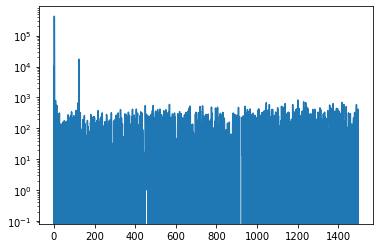

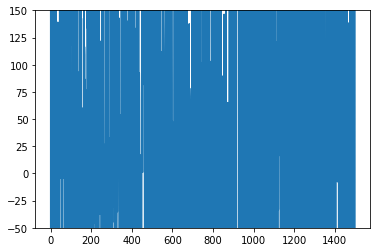


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.00055214593136981 and pval_i=0.03333948415155489
0 and 2 are independent with pval_d=0.12482810451678655 and pval_i=0.15882174745388175
0 and 3 are independent with pval_d=0.09366201125409547 and pval_i=0.9810857764470281
0 and 4 are independent with pval_d=0.038986527835721096 and pval_i=0.8878881381998793
1 and 2 are independent with pval_d=0.16422957342446606 and pval_i=0.9657892137954308
1 and 3 are independent with pval_d=0.03154190870504745 and pval_i=0.9937148978352136
1 and 4 are independent with pval_d=0.06405789392956111 and pval_i=0.9769601775156971
2 and 3 are independent with pval_d=0.9891451824830859 and pval_i=0.9989788958929309
2 and 4 are independent with pval_d=0.006336612872036393 and pval_i=0.2736906703652836
3 and 4 are independent with pval_d=0.8336058916268254 and pval_i=0.9965266160416842
0 0
1 0
2 0
3 0
4 0
parent list: [0, 1, 2, 3, 4]
pol

  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:28,  1.50s/it]

0 352.48407250642776


  2%|▏         | 2/100 [00:03<02:27,  1.50s/it]

1 351.45666259527206


  3%|▎         | 3/100 [00:04<02:26,  1.51s/it]

2 351.28221011161804


  4%|▍         | 4/100 [00:06<02:24,  1.51s/it]

3 351.28440141677856


  5%|▌         | 5/100 [00:07<02:23,  1.51s/it]

4 351.19924902915955


  6%|▌         | 6/100 [00:09<02:23,  1.52s/it]

5 351.1981400847435


  7%|▋         | 7/100 [00:10<02:20,  1.51s/it]

6 351.1745231747627


  8%|▊         | 8/100 [00:12<02:18,  1.50s/it]

7 351.14448750019073


  9%|▉         | 9/100 [00:13<02:16,  1.50s/it]

8 351.10344076156616


 10%|█         | 10/100 [00:15<02:13,  1.49s/it]

9 351.2040042877197


 11%|█         | 11/100 [00:16<02:11,  1.48s/it]

10 351.0928084254265


 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]

11 351.1085786819458


 13%|█▎        | 13/100 [00:19<02:09,  1.48s/it]

12 351.0963362455368


 14%|█▍        | 14/100 [00:20<02:08,  1.49s/it]

13 351.1068040728569


 15%|█▌        | 15/100 [00:22<02:06,  1.49s/it]

14 351.08353275060654


 16%|█▌        | 16/100 [00:23<02:05,  1.49s/it]

15 351.04320430755615


 17%|█▋        | 17/100 [00:25<02:04,  1.50s/it]

16 351.1145638823509


 18%|█▊        | 18/100 [00:26<02:02,  1.50s/it]

17 351.02251094579697


 19%|█▉        | 19/100 [00:28<02:02,  1.51s/it]

18 351.09223586320877


 20%|██        | 20/100 [00:30<02:01,  1.52s/it]

19 351.10761946439743


 21%|██        | 21/100 [00:31<01:59,  1.52s/it]

20 351.0337546467781


 22%|██▏       | 22/100 [00:33<01:57,  1.50s/it]

21 351.0230761170387


 23%|██▎       | 23/100 [00:34<01:55,  1.50s/it]

22 351.04168540239334


 24%|██▍       | 24/100 [00:36<01:54,  1.50s/it]

23 351.0654796361923


 25%|██▌       | 25/100 [00:37<01:52,  1.50s/it]

24 351.0942104458809


 26%|██▌       | 26/100 [00:39<01:52,  1.52s/it]

25 351.01478785276413


 27%|██▋       | 27/100 [00:40<01:51,  1.52s/it]

26 351.04994851350784


 28%|██▊       | 28/100 [00:42<01:49,  1.52s/it]

27 351.03228276968


 29%|██▉       | 29/100 [00:43<01:47,  1.51s/it]

28 351.0506988167763


 30%|███       | 30/100 [00:45<01:45,  1.50s/it]

29 351.0008591413498


 31%|███       | 31/100 [00:46<01:42,  1.49s/it]

30 351.04557275772095


 32%|███▏      | 32/100 [00:48<01:40,  1.48s/it]

31 351.08460253477097


 33%|███▎      | 33/100 [00:49<01:38,  1.47s/it]

32 351.04141050577164


 34%|███▍      | 34/100 [00:50<01:37,  1.47s/it]

33 351.04770958423615


 35%|███▌      | 35/100 [00:52<01:35,  1.47s/it]

34 351.0479821562767


 36%|███▌      | 36/100 [00:53<01:33,  1.47s/it]

35 351.0646924972534


 37%|███▋      | 37/100 [00:55<01:32,  1.47s/it]

36 351.0203645825386


 38%|███▊      | 38/100 [00:56<01:30,  1.46s/it]

37 351.04149490594864


 39%|███▉      | 39/100 [00:58<01:29,  1.46s/it]

38 351.0240105986595


 40%|████      | 40/100 [00:59<01:27,  1.46s/it]

39 351.00006926059723


 41%|████      | 41/100 [01:01<01:26,  1.47s/it]

40 351.04862958192825


 42%|████▏     | 42/100 [01:02<01:26,  1.48s/it]

41 351.0320662856102


 43%|████▎     | 43/100 [01:04<01:24,  1.48s/it]

42 351.0379250049591


 44%|████▍     | 44/100 [01:05<01:22,  1.48s/it]

43 351.03286987543106


 45%|████▌     | 45/100 [01:07<01:21,  1.48s/it]

44 350.997072994709


 46%|████▌     | 46/100 [01:08<01:19,  1.47s/it]

45 351.04656291007996


 47%|████▋     | 47/100 [01:10<01:18,  1.47s/it]

46 350.9973703622818


 48%|████▊     | 48/100 [01:11<01:16,  1.47s/it]

47 351.0171504020691


 49%|████▉     | 49/100 [01:12<01:14,  1.47s/it]

48 351.002760887146


 50%|█████     | 50/100 [01:14<01:13,  1.47s/it]

49 351.04799288511276


 51%|█████     | 51/100 [01:15<01:12,  1.47s/it]

50 350.9912769794464


 52%|█████▏    | 52/100 [01:17<01:10,  1.47s/it]

51 351.0332618355751


 53%|█████▎    | 53/100 [01:18<01:08,  1.47s/it]

52 351.00534039735794


 54%|█████▍    | 54/100 [01:20<01:07,  1.47s/it]

53 351.01284152269363


 55%|█████▌    | 55/100 [01:21<01:06,  1.47s/it]

54 351.0617325305939


 56%|█████▌    | 56/100 [01:23<01:04,  1.47s/it]

55 350.99044877290726


 57%|█████▋    | 57/100 [01:24<01:03,  1.47s/it]

56 351.00243800878525


 58%|█████▊    | 58/100 [01:26<01:01,  1.47s/it]

57 351.0485106110573


 59%|█████▉    | 59/100 [01:27<01:00,  1.47s/it]

58 351.0736851096153


 60%|██████    | 60/100 [01:29<00:58,  1.47s/it]

59 350.98307579755783


 61%|██████    | 61/100 [01:30<00:57,  1.48s/it]

60 351.01852893829346


 62%|██████▏   | 62/100 [01:32<00:56,  1.48s/it]

61 351.02674889564514


 63%|██████▎   | 63/100 [01:33<00:55,  1.49s/it]

62 351.04238975048065


 64%|██████▍   | 64/100 [01:35<00:53,  1.49s/it]

63 351.03258687257767


 65%|██████▌   | 65/100 [01:36<00:52,  1.49s/it]

64 351.04160392284393


 66%|██████▌   | 66/100 [01:38<00:50,  1.49s/it]

65 351.00488501787186


 67%|██████▋   | 67/100 [01:39<00:48,  1.48s/it]

66 351.02318572998047


 68%|██████▊   | 68/100 [01:41<00:47,  1.48s/it]

67 351.0382686853409


 69%|██████▉   | 69/100 [01:42<00:45,  1.47s/it]

68 351.01714181900024


 70%|███████   | 70/100 [01:44<00:44,  1.47s/it]

69 351.0137839317322


 71%|███████   | 71/100 [01:45<00:42,  1.47s/it]

70 350.9924339056015


 72%|███████▏  | 72/100 [01:46<00:41,  1.47s/it]

71 351.0171458721161


 73%|███████▎  | 73/100 [01:48<00:39,  1.47s/it]

72 350.99771881103516


 74%|███████▍  | 74/100 [01:49<00:38,  1.47s/it]

73 351.0466651916504


 75%|███████▌  | 75/100 [01:51<00:36,  1.47s/it]

74 351.0020846128464


 76%|███████▌  | 76/100 [01:52<00:35,  1.46s/it]

75 351.04674512147903


 77%|███████▋  | 77/100 [01:54<00:33,  1.46s/it]

76 350.9929597377777


 78%|███████▊  | 78/100 [01:55<00:32,  1.46s/it]

77 350.98722952604294


 79%|███████▉  | 79/100 [01:57<00:30,  1.47s/it]

78 351.05925661325455


 80%|████████  | 80/100 [01:58<00:29,  1.47s/it]

79 350.9930730462074


 81%|████████  | 81/100 [02:00<00:27,  1.47s/it]

80 350.9775246977806


 82%|████████▏ | 82/100 [02:01<00:26,  1.47s/it]

81 351.04114043712616


 83%|████████▎ | 83/100 [02:03<00:24,  1.46s/it]

82 350.9916126728058


 84%|████████▍ | 84/100 [02:04<00:23,  1.46s/it]

83 351.00453674793243


 85%|████████▌ | 85/100 [02:06<00:22,  1.48s/it]

84 351.01176804304123


 86%|████████▌ | 86/100 [02:07<00:20,  1.47s/it]

85 350.99713188409805


 87%|████████▋ | 87/100 [02:08<00:19,  1.47s/it]

86 351.01357477903366


 88%|████████▊ | 88/100 [02:10<00:17,  1.47s/it]

87 351.006735265255


 89%|████████▉ | 89/100 [02:11<00:16,  1.46s/it]

88 351.04496055841446


 90%|█████████ | 90/100 [02:13<00:14,  1.46s/it]

89 350.9942424297333


 91%|█████████ | 91/100 [02:14<00:13,  1.46s/it]

90 351.022752225399


 92%|█████████▏| 92/100 [02:16<00:11,  1.46s/it]

91 351.011471927166


 93%|█████████▎| 93/100 [02:17<00:10,  1.46s/it]

92 351.03179717063904


 94%|█████████▍| 94/100 [02:19<00:08,  1.47s/it]

93 351.01424276828766


 95%|█████████▌| 95/100 [02:20<00:07,  1.47s/it]

94 350.9911457300186


 96%|█████████▌| 96/100 [02:22<00:05,  1.47s/it]

95 351.03417509794235


 97%|█████████▋| 97/100 [02:23<00:04,  1.47s/it]

96 351.07581263780594


 98%|█████████▊| 98/100 [02:25<00:02,  1.47s/it]

97 350.99232709407806


 99%|█████████▉| 99/100 [02:26<00:01,  1.47s/it]

98 350.9674292206764


100%|██████████| 100/100 [02:28<00:00,  1.47s/it]

99 351.08588802814484

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07765620201826096	

epoch 9000/10000, policy loss 0.06407447904348373	
***** test student *****
epoch 0/100 return: 34.0
epoch 1/100 return: 22.0
epoch 2/100 return: 30.0
epoch 3/100 return: 28.0
epoch 4/100 return: 17.0
epoch 5/100 return: 17.0
epoch 6/100 return: 25.0
epoch 7/100 return: 17.0
epoch 8/100 return: 23.0
epoch 9/100 return: 34.0
epoch 10/100 return: 27.0
epoch 11/100 return: 22.0
epoch 12/100 return: 28.0
epoch 13/100 return: 39.0
epoch 14/100 return: 13.0
epoch 15/100 return: 23.0
epoch 16/100 return: 30.0
epoch 17/100 return: 30.0
epoch 18/100 return: 30.0
epoch 19/100 return: 32.0
epoch 20/100 return: 20.0
epoch 21/100 return: 37.0
epoch 22/100 return: 23.0
epoch 23/100 return: 17.0
epoch 24/100 return: 34.0
epoch 25/100 return: 31.0
epoch 26/100 return: 20.0
epoch 27/100 return: 23.0
epoch 28/100 return: 25.0
epoch 29/100 return: 23.0
epoch 30/100 return: 24.0
epoch 31/100 return: 31.0
epoch 32/100 return: 38.0
epoch 33/100 return: 21.0
epoch 34/100 return: 18.0
epoch 35/100 return: 28.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 4.304178237915039best loss model loaded, stored at update # 727


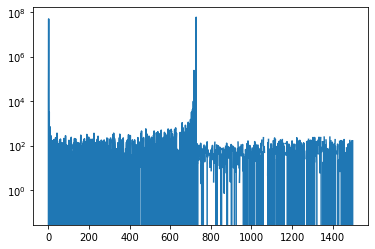

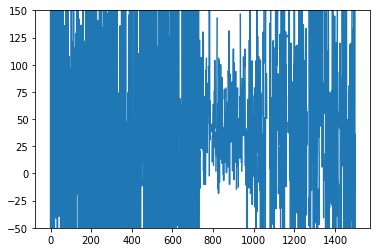


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=2.964399583457112e-10 and pval_i=1.573038777241226e-07
0 and 2 are independent with pval_d=5.088714864147469e-09 and pval_i=9.958568110759272e-09
0 and 3 are DEPENDENT with pval_d=7.223405952427078e-05 and pval_i=1.814777668562339e-06
0 and 4 are independent with pval_d=1.689834766310859e-05 and pval_i=7.59352759385033e-05
1 and 2 are independent with pval_d=1.0399463924172197e-11 and pval_i=9.227598432317588e-11
1 and 3 are DEPENDENT with pval_d=2.2602668319804674e-07 and pval_i=4.963811109189901e-08
1 and 4 are independent with pval_d=2.1045174757558008e-08 and pval_i=0.06717054591109033
2 and 3 are independent with pval_d=2.4195322280947825e-08 and pval_i=3.576536633995342e-08
2 and 4 are independent with pval_d=3.053006852202222e-08 and pval_i=4.6284708566304856e-06
3 and 4 are independent with pval_d=1.9866464744661692e-07 and pval_i=0.015053152374500221
3 2
0 

  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:26,  1.48s/it]

0 253.81575533747673


  2%|▏         | 2/100 [00:02<02:26,  1.49s/it]

1 245.2315697968006


  3%|▎         | 3/100 [00:04<02:24,  1.49s/it]

2 244.95707899332047


  4%|▍         | 4/100 [00:05<02:22,  1.48s/it]

3 244.78605684638023


  5%|▌         | 5/100 [00:07<02:21,  1.49s/it]

4 244.8362529873848


  6%|▌         | 6/100 [00:08<02:19,  1.49s/it]

5 244.7433478832245


  7%|▋         | 7/100 [00:10<02:18,  1.49s/it]

6 244.7809218466282


  8%|▊         | 8/100 [00:11<02:16,  1.48s/it]

7 244.59141036868095


  9%|▉         | 9/100 [00:13<02:15,  1.49s/it]

8 244.59600687026978


 10%|█         | 10/100 [00:14<02:14,  1.50s/it]

9 244.59356302022934


 11%|█         | 11/100 [00:16<02:14,  1.51s/it]

10 244.54284217953682


 12%|█▏        | 12/100 [00:17<02:12,  1.50s/it]

11 244.46124878525734


 13%|█▎        | 13/100 [00:19<02:10,  1.50s/it]

12 244.43464055657387


 14%|█▍        | 14/100 [00:20<02:09,  1.50s/it]

13 244.46657925844193


 15%|█▌        | 15/100 [00:22<02:07,  1.50s/it]

14 244.39650243520737


 16%|█▌        | 16/100 [00:23<02:06,  1.50s/it]

15 244.45831125974655


 17%|█▋        | 17/100 [00:25<02:05,  1.51s/it]

16 244.43639227747917


 18%|█▊        | 18/100 [00:26<02:02,  1.49s/it]

17 244.38368019461632


 19%|█▉        | 19/100 [00:28<02:00,  1.49s/it]

18 244.35308656096458


 20%|██        | 20/100 [00:29<01:58,  1.49s/it]

19 244.3077167570591


 21%|██        | 21/100 [00:31<01:57,  1.49s/it]

20 244.46915265917778


 22%|██▏       | 22/100 [00:32<01:56,  1.49s/it]

21 244.36218547821045


 23%|██▎       | 23/100 [00:34<01:54,  1.48s/it]

22 244.34395492076874


 24%|██▍       | 24/100 [00:35<01:52,  1.48s/it]

23 244.3273857831955


 25%|██▌       | 25/100 [00:37<01:50,  1.47s/it]

24 244.30415576696396


 26%|██▌       | 26/100 [00:38<01:49,  1.48s/it]

25 244.29456517100334


 27%|██▋       | 27/100 [00:40<01:48,  1.49s/it]

26 244.3235241472721


 28%|██▊       | 28/100 [00:41<01:47,  1.49s/it]

27 244.28452628850937


 29%|██▉       | 29/100 [00:43<01:45,  1.49s/it]

28 244.27210059762


 30%|███       | 30/100 [00:44<01:43,  1.48s/it]

29 244.24700239300728


 31%|███       | 31/100 [00:46<01:42,  1.48s/it]

30 244.3615842461586


 32%|███▏      | 32/100 [00:47<01:40,  1.47s/it]

31 244.22867232561111


 33%|███▎      | 33/100 [00:49<01:39,  1.49s/it]

32 244.21607545018196


 34%|███▍      | 34/100 [00:50<01:37,  1.48s/it]

33 244.27782320976257


 35%|███▌      | 35/100 [00:52<01:36,  1.48s/it]

34 244.22560930252075


 36%|███▌      | 36/100 [00:53<01:34,  1.47s/it]

35 244.18644154071808


 37%|███▋      | 37/100 [00:55<01:33,  1.48s/it]

36 244.22737669944763


 38%|███▊      | 38/100 [00:56<01:31,  1.47s/it]

37 244.21435895562172


 39%|███▉      | 39/100 [00:58<01:30,  1.48s/it]

38 244.24596306681633


 40%|████      | 40/100 [00:59<01:28,  1.47s/it]

39 244.22607585787773


 41%|████      | 41/100 [01:00<01:26,  1.47s/it]

40 244.23554441332817


 42%|████▏     | 42/100 [01:02<01:25,  1.47s/it]

41 244.23044312000275


 43%|████▎     | 43/100 [01:03<01:23,  1.47s/it]

42 244.1404565870762


 44%|████▍     | 44/100 [01:05<01:22,  1.47s/it]

43 244.21831756830215


 45%|████▌     | 45/100 [01:06<01:20,  1.47s/it]

44 244.1439356803894


 46%|████▌     | 46/100 [01:08<01:18,  1.46s/it]

45 244.15950301289558


 47%|████▋     | 47/100 [01:09<01:17,  1.47s/it]

46 244.24482235312462


 48%|████▊     | 48/100 [01:11<01:16,  1.47s/it]

47 244.2027406990528


 49%|████▉     | 49/100 [01:12<01:14,  1.47s/it]

48 244.21692755818367


 50%|█████     | 50/100 [01:14<01:13,  1.46s/it]

49 244.1813606619835


 51%|█████     | 51/100 [01:15<01:12,  1.48s/it]

50 244.18989086151123


 52%|█████▏    | 52/100 [01:17<01:11,  1.48s/it]

51 244.16382890939713


 53%|█████▎    | 53/100 [01:18<01:09,  1.48s/it]

52 244.21318995952606


 54%|█████▍    | 54/100 [01:20<01:07,  1.48s/it]

53 244.16180405020714


 55%|█████▌    | 55/100 [01:21<01:06,  1.47s/it]

54 244.1734955906868


 56%|█████▌    | 56/100 [01:22<01:04,  1.47s/it]

55 244.12403312325478


 57%|█████▋    | 57/100 [01:24<01:03,  1.47s/it]

56 244.12221211194992


 58%|█████▊    | 58/100 [01:25<01:01,  1.48s/it]

57 244.21061685681343


 59%|█████▉    | 59/100 [01:27<01:00,  1.48s/it]

58 244.18653190135956


 60%|██████    | 60/100 [01:28<00:59,  1.48s/it]

59 244.16691336035728


 61%|██████    | 61/100 [01:30<00:57,  1.47s/it]

60 244.1157652437687


 62%|██████▏   | 62/100 [01:31<00:56,  1.48s/it]

61 244.18069410324097


 63%|██████▎   | 63/100 [01:33<00:54,  1.48s/it]

62 244.15990975499153


 64%|██████▍   | 64/100 [01:34<00:53,  1.48s/it]

63 244.1739776134491


 65%|██████▌   | 65/100 [01:36<00:51,  1.48s/it]

64 244.18537282943726


 66%|██████▌   | 66/100 [01:37<00:50,  1.48s/it]

65 244.13898876309395


 67%|██████▋   | 67/100 [01:39<00:48,  1.48s/it]

66 244.136520922184


 68%|██████▊   | 68/100 [01:40<00:47,  1.48s/it]

67 244.18964168429375


 69%|██████▉   | 69/100 [01:42<00:45,  1.48s/it]

68 244.1326236128807


 70%|███████   | 70/100 [01:43<00:44,  1.47s/it]

69 244.1430413722992


 71%|███████   | 71/100 [01:45<00:42,  1.47s/it]

70 244.13740518689156


 72%|███████▏  | 72/100 [01:46<00:41,  1.47s/it]

71 244.14236053824425


 73%|███████▎  | 73/100 [01:48<00:39,  1.47s/it]

72 244.12538436055183


 74%|███████▍  | 74/100 [01:49<00:38,  1.47s/it]

73 244.18368211388588


 75%|███████▌  | 75/100 [01:51<00:36,  1.47s/it]

74 244.12482354044914


 76%|███████▌  | 76/100 [01:52<00:35,  1.47s/it]

75 244.12331235408783


 77%|███████▋  | 77/100 [01:53<00:33,  1.48s/it]

76 244.12252962589264


 78%|███████▊  | 78/100 [01:55<00:32,  1.47s/it]

77 244.1113322675228


 79%|███████▉  | 79/100 [01:56<00:31,  1.48s/it]

78 244.16376346349716


 80%|████████  | 80/100 [01:58<00:29,  1.49s/it]

79 244.14013412594795


 81%|████████  | 81/100 [01:59<00:27,  1.47s/it]

80 244.16613066196442


 82%|████████▏ | 82/100 [02:01<00:26,  1.47s/it]

81 244.14166274666786


 83%|████████▎ | 83/100 [02:02<00:25,  1.47s/it]

82 244.0762642621994


 84%|████████▍ | 84/100 [02:04<00:23,  1.47s/it]

83 244.13226261734962


 85%|████████▌ | 85/100 [02:05<00:21,  1.46s/it]

84 244.14034843444824


 86%|████████▌ | 86/100 [02:07<00:20,  1.46s/it]

85 244.1697632074356


 87%|████████▋ | 87/100 [02:08<00:18,  1.46s/it]

86 244.15163198113441


 88%|████████▊ | 88/100 [02:10<00:17,  1.46s/it]

87 244.07443863153458


 89%|████████▉ | 89/100 [02:11<00:16,  1.46s/it]

88 244.18861138820648


 90%|█████████ | 90/100 [02:13<00:14,  1.47s/it]

89 244.13177210092545


 91%|█████████ | 91/100 [02:14<00:13,  1.47s/it]

90 244.13137343525887


 92%|█████████▏| 92/100 [02:16<00:11,  1.47s/it]

91 244.1369479894638


 93%|█████████▎| 93/100 [02:17<00:10,  1.48s/it]

92 244.14674744009972


 94%|█████████▍| 94/100 [02:18<00:08,  1.47s/it]

93 244.13257983326912


 95%|█████████▌| 95/100 [02:20<00:07,  1.47s/it]

94 244.12814217805862


 96%|█████████▌| 96/100 [02:21<00:05,  1.46s/it]

95 244.11250987648964


 97%|█████████▋| 97/100 [02:23<00:04,  1.47s/it]

96 244.17581230401993


 98%|█████████▊| 98/100 [02:24<00:02,  1.46s/it]

97 244.1018706560135


 99%|█████████▉| 99/100 [02:26<00:01,  1.46s/it]

98 244.1259460747242


100%|██████████| 100/100 [02:27<00:00,  1.46s/it]

99 244.14501789212227

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.0858733281493187	

epoch 9000/10000, policy loss 0.0267499927431345	
***** test student *****
epoch 0/100 return: 10.0
epoch 1/100 return: 9.0
epoch 2/100 return: 10.0
epoch 3/100 return: 9.0
epoch 4/100 return: 10.0
epoch 5/100 return: 9.0
epoch 6/100 return: 11.0
epoch 7/100 return: 10.0
epoch 8/100 return: 9.0
epoch 9/100 return: 9.0
epoch 10/100 return: 9.0
epoch 11/100 return: 8.0
epoch 12/100 return: 8.0
epoch 13/100 return: 10.0
epoch 14/100 return: 10.0
epoch 15/100 return: 10.0
epoch 16/100 return: 9.0
epoch 17/100 return: 8.0
epoch 18/100 return: 10.0
epoch 19/100 return: 10.0
epoch 20/100 return: 10.0
epoch 21/100 return: 11.0
epoch 22/100 return: 9.0
epoch 23/100 return: 10.0
epoch 24/100 return: 10.0
epoch 25/100 return: 10.0
epoch 26/100 return: 10.0
epoch 27/100 return: 8.0
epoch 28/100 return: 10.0
epoch 29/100 return: 9.0
epoch 30/100 return: 10.0
epoch 31/100 return: 9.0
epoch 32/100 return: 9.0
epoch 33/100 return: 9.0
epoch 34/100 return: 9.0
epoch 35/100 return: 11.0
epoch 36/100 ret

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -207.4812469482422best loss model loaded, stored at update # 270


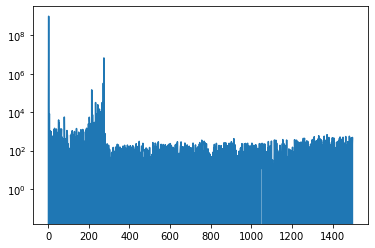

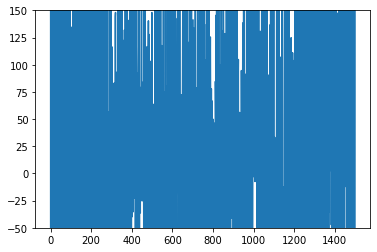


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=5.295111259647482e-05 and pval_i=0.6282681133540856
0 and 2 are independent with pval_d=1.8162567967828188e-05 and pval_i=0.008276198025380663
0 and 3 are DEPENDENT with pval_d=0.2560251395437604 and pval_i=0.003105324155175144
0 and 4 are independent with pval_d=0.00016729539998970952 and pval_i=0.7621964737604066
1 and 2 are independent with pval_d=3.934621996201545e-06 and pval_i=0.9630158666332999
1 and 3 are independent with pval_d=0.1627668269783089 and pval_i=0.9984713903538907
1 and 4 are independent with pval_d=0.0002714758579475395 and pval_i=0.9912259861825456
2 and 3 are DEPENDENT with pval_d=0.0022099358457454347 and pval_i=0.0005752501632516257
2 and 4 are independent with pval_d=6.619939872385093e-06 and pval_i=2.641898816294693e-05
3 and 4 are independent with pval_d=0.0005278765845533168 and pval_i=0.013171325055915228
3 2
0 1
2 1
1 0
4 0
parent lis

  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:25,  1.47s/it]

0 407.09545135498047


  2%|▏         | 2/100 [00:02<02:24,  1.47s/it]

1 405.46244382858276


  3%|▎         | 3/100 [00:04<02:23,  1.48s/it]

2 405.30130964517593


  4%|▍         | 4/100 [00:05<02:21,  1.48s/it]

3 405.26814889907837


  5%|▌         | 5/100 [00:07<02:20,  1.48s/it]

4 405.23998296260834


  6%|▌         | 6/100 [00:08<02:18,  1.48s/it]

5 405.19471687078476


  7%|▋         | 7/100 [00:10<02:17,  1.48s/it]

6 405.2065991163254


  8%|▊         | 8/100 [00:11<02:15,  1.47s/it]

7 405.1664297580719


  9%|▉         | 9/100 [00:13<02:13,  1.47s/it]

8 405.1080669760704


 10%|█         | 10/100 [00:14<02:12,  1.47s/it]

9 405.20105147361755


 11%|█         | 11/100 [00:16<02:10,  1.46s/it]

10 405.11273568868637


 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]

11 405.10582131147385


 13%|█▎        | 13/100 [00:19<02:08,  1.48s/it]

12 405.1220762729645


 14%|█▍        | 14/100 [00:20<02:07,  1.48s/it]

13 405.08995896577835


 15%|█▌        | 15/100 [00:22<02:05,  1.48s/it]

14 405.0547446012497


 16%|█▌        | 16/100 [00:23<02:03,  1.47s/it]

15 405.0757681131363


 17%|█▋        | 17/100 [00:25<02:02,  1.47s/it]

16 405.0772802233696


 18%|█▊        | 18/100 [00:26<02:00,  1.47s/it]

17 405.0320990681648


 19%|█▉        | 19/100 [00:28<01:59,  1.47s/it]

18 405.07025068998337


 20%|██        | 20/100 [00:29<01:57,  1.47s/it]

19 405.10294193029404


 21%|██        | 21/100 [00:30<01:56,  1.48s/it]

20 405.02176785469055


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]

21 404.98073506355286


 23%|██▎       | 23/100 [00:33<01:53,  1.47s/it]

22 405.0481997728348


 24%|██▍       | 24/100 [00:35<01:51,  1.47s/it]

23 405.01240199804306


 25%|██▌       | 25/100 [00:36<01:50,  1.47s/it]

24 405.03536850214005


 26%|██▌       | 26/100 [00:38<01:48,  1.47s/it]

25 405.0109986066818


 27%|██▋       | 27/100 [00:39<01:47,  1.47s/it]

26 405.03068590164185


 28%|██▊       | 28/100 [00:41<01:46,  1.47s/it]

27 405.03902834653854


 29%|██▉       | 29/100 [00:42<01:44,  1.47s/it]

28 405.0020532608032


 30%|███       | 30/100 [00:44<01:43,  1.47s/it]

29 404.99427646398544


 31%|███       | 31/100 [00:45<01:41,  1.47s/it]

30 405.05379712581635


 32%|███▏      | 32/100 [00:47<01:40,  1.48s/it]

31 405.0731637477875


 33%|███▎      | 33/100 [00:48<01:38,  1.47s/it]

32 405.0482150912285


 34%|███▍      | 34/100 [00:50<01:37,  1.47s/it]

33 405.022341966629


 35%|███▌      | 35/100 [00:51<01:35,  1.47s/it]

34 405.05331629514694


 36%|███▌      | 36/100 [00:53<01:34,  1.47s/it]

35 405.05458641052246


 37%|███▋      | 37/100 [00:54<01:32,  1.47s/it]

36 405.0074528455734


 38%|███▊      | 38/100 [00:55<01:31,  1.47s/it]

37 405.0261262655258


 39%|███▉      | 39/100 [00:57<01:29,  1.47s/it]

38 405.016255736351


 40%|████      | 40/100 [00:58<01:27,  1.46s/it]

39 404.9955940246582


 41%|████      | 41/100 [01:00<01:26,  1.47s/it]

40 405.016747713089


 42%|████▏     | 42/100 [01:01<01:25,  1.48s/it]

41 405.0170524716377


 43%|████▎     | 43/100 [01:03<01:24,  1.48s/it]

42 405.00724601745605


 44%|████▍     | 44/100 [01:04<01:22,  1.48s/it]

43 405.00089144706726


 45%|████▌     | 45/100 [01:06<01:21,  1.48s/it]

44 405.0128675699234


 46%|████▌     | 46/100 [01:07<01:19,  1.48s/it]

45 405.0647406578064


 47%|████▋     | 47/100 [01:09<01:18,  1.48s/it]

46 404.95467698574066


 48%|████▊     | 48/100 [01:10<01:16,  1.47s/it]

47 405.035332262516


 49%|████▉     | 49/100 [01:12<01:15,  1.48s/it]

48 405.0002537369728


 50%|█████     | 50/100 [01:13<01:14,  1.50s/it]

49 404.99508994817734


 51%|█████     | 51/100 [01:15<01:13,  1.51s/it]

50 405.00322818756104


 52%|█████▏    | 52/100 [01:16<01:12,  1.52s/it]

51 404.9621938467026


 53%|█████▎    | 53/100 [01:18<01:11,  1.52s/it]

52 404.96933072805405


 54%|█████▍    | 54/100 [01:19<01:10,  1.53s/it]

53 405.0018352866173


 55%|█████▌    | 55/100 [01:21<01:09,  1.54s/it]

54 405.06189554929733


 56%|█████▌    | 56/100 [01:22<01:07,  1.54s/it]

55 404.96183782815933


 57%|█████▋    | 57/100 [01:24<01:05,  1.52s/it]

56 405.02050346136093


 58%|█████▊    | 58/100 [01:25<01:03,  1.51s/it]

57 405.00713407993317


 59%|█████▉    | 59/100 [01:27<01:01,  1.50s/it]

58 405.0678961277008


 60%|██████    | 60/100 [01:28<00:59,  1.49s/it]

59 404.95538836717606


 61%|██████    | 61/100 [01:30<00:57,  1.49s/it]

60 405.00009071826935


 62%|██████▏   | 62/100 [01:31<00:56,  1.48s/it]

61 405.0002427101135


 63%|██████▎   | 63/100 [01:33<00:54,  1.48s/it]

62 405.0248847603798


 64%|██████▍   | 64/100 [01:34<00:53,  1.48s/it]

63 405.0005670785904


 65%|██████▌   | 65/100 [01:36<00:51,  1.47s/it]

64 405.0513594150543


 66%|██████▌   | 66/100 [01:37<00:50,  1.47s/it]

65 404.9822906255722


 67%|██████▋   | 67/100 [01:39<00:48,  1.47s/it]

66 404.97795754671097


 68%|██████▊   | 68/100 [01:40<00:47,  1.47s/it]

67 405.03612184524536


 69%|██████▉   | 69/100 [01:42<00:45,  1.47s/it]

68 404.98771142959595


 70%|███████   | 70/100 [01:43<00:44,  1.48s/it]

69 404.9672420024872


 71%|███████   | 71/100 [01:45<00:42,  1.48s/it]

70 404.98976069688797


 72%|███████▏  | 72/100 [01:46<00:41,  1.48s/it]

71 405.01974391937256


 73%|███████▎  | 73/100 [01:48<00:39,  1.48s/it]

72 404.99243235588074


 74%|███████▍  | 74/100 [01:49<00:38,  1.47s/it]

73 405.03391456604004


 75%|███████▌  | 75/100 [01:51<00:36,  1.48s/it]

74 404.9802669286728


 76%|███████▌  | 76/100 [01:52<00:35,  1.47s/it]

75 405.00560081005096


 77%|███████▋  | 77/100 [01:53<00:34,  1.48s/it]

76 405.0035428404808


 78%|███████▊  | 78/100 [01:55<00:32,  1.48s/it]

77 404.96352314949036


 79%|███████▉  | 79/100 [01:56<00:30,  1.47s/it]

78 404.98793971538544


 80%|████████  | 80/100 [01:58<00:29,  1.47s/it]

79 404.99158561229706


 81%|████████  | 81/100 [01:59<00:27,  1.47s/it]

80 405.00343841314316


 82%|████████▏ | 82/100 [02:01<00:26,  1.47s/it]

81 404.982363820076


 83%|████████▎ | 83/100 [02:02<00:24,  1.47s/it]

82 404.9845778942108


 84%|████████▍ | 84/100 [02:04<00:23,  1.47s/it]

83 404.9953917860985


 85%|████████▌ | 85/100 [02:05<00:22,  1.47s/it]

84 405.01312738657


 86%|████████▌ | 86/100 [02:07<00:20,  1.47s/it]

85 405.0084159374237


 87%|████████▋ | 87/100 [02:08<00:18,  1.46s/it]

86 405.0189790725708


 88%|████████▊ | 88/100 [02:10<00:17,  1.46s/it]

87 404.93561071157455


 89%|████████▉ | 89/100 [02:11<00:16,  1.47s/it]

88 405.00642520189285


 90%|█████████ | 90/100 [02:13<00:14,  1.47s/it]

89 404.9891617298126


 91%|█████████ | 91/100 [02:14<00:13,  1.47s/it]

90 405.00945115089417


 92%|█████████▏| 92/100 [02:15<00:11,  1.47s/it]

91 404.98199170827866


 93%|█████████▎| 93/100 [02:17<00:10,  1.47s/it]

92 405.0156487226486


 94%|█████████▍| 94/100 [02:18<00:08,  1.47s/it]

93 405.0267468094826


 95%|█████████▌| 95/100 [02:20<00:07,  1.46s/it]

94 404.9550629258156


 96%|█████████▌| 96/100 [02:21<00:05,  1.47s/it]

95 404.99041724205017


 97%|█████████▋| 97/100 [02:23<00:04,  1.47s/it]

96 405.05485141277313


 98%|█████████▊| 98/100 [02:24<00:02,  1.47s/it]

97 404.98147678375244


 99%|█████████▉| 99/100 [02:26<00:01,  1.48s/it]

98 404.9899248480797


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]

99 405.02138352394104

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07817750424146652	

epoch 9000/10000, policy loss 0.041459377855062485	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 1114.5064697265625best loss model loaded, stored at update # 100


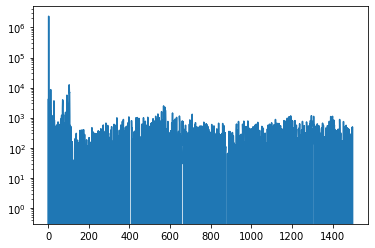

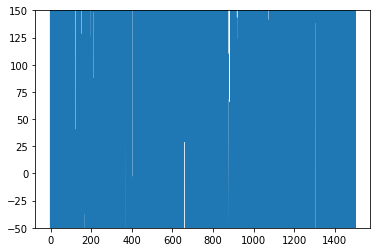


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=6.11241792308684e-05 and pval_i=0.9775028614246808
0 and 2 are independent with pval_d=0.0013275427093556679 and pval_i=0.921332882337377
0 and 3 are independent with pval_d=0.3591008696106799 and pval_i=0.9996514839048156
0 and 4 are DEPENDENT with pval_d=0.0623721395131161 and pval_i=0.030443199111481082
1 and 2 are independent with pval_d=0.02768068986577831 and pval_i=0.9660614362740273
1 and 3 are independent with pval_d=0.1374253516084166 and pval_i=0.7923536765235819
1 and 4 are independent with pval_d=0.014814778906194839 and pval_i=0.7781505976978391
2 and 3 are independent with pval_d=0.001231774851691586 and pval_i=0.43085752339755357
2 and 4 are DEPENDENT with pval_d=0.030990575112632236 and pval_i=0.021162101609809695
3 and 4 are independent with pval_d=0.21815207421470695 and pval_i=0.5973261916757029
4 2
0 1
2 1
1 0
3 0
parent list: [0, 1, 2, 3, 4]
po

  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:22,  1.44s/it]

0 389.6756461262703


  2%|▏         | 2/100 [00:02<02:21,  1.45s/it]

1 388.3590370416641


  3%|▎         | 3/100 [00:04<02:21,  1.46s/it]

2 388.19165217876434


  4%|▍         | 4/100 [00:05<02:20,  1.46s/it]

3 388.21569043397903


  5%|▌         | 5/100 [00:07<02:18,  1.46s/it]

4 388.13078516721725


  6%|▌         | 6/100 [00:08<02:17,  1.46s/it]

5 388.1373420357704


  7%|▋         | 7/100 [00:10<02:16,  1.46s/it]

6 388.1111718416214


  8%|▊         | 8/100 [00:11<02:14,  1.47s/it]

7 388.0779992341995


  9%|▉         | 9/100 [00:13<02:13,  1.47s/it]

8 388.00968927145004


 10%|█         | 10/100 [00:14<02:12,  1.47s/it]

9 388.11264938116074


 11%|█         | 11/100 [00:16<02:11,  1.47s/it]

10 388.00317603349686


 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]

11 388.03741413354874


 13%|█▎        | 13/100 [00:19<02:07,  1.47s/it]

12 388.01447516679764


 14%|█▍        | 14/100 [00:20<02:07,  1.48s/it]

13 388.0188820362091


 15%|█▌        | 15/100 [00:22<02:05,  1.48s/it]

14 388.0134502053261


 16%|█▌        | 16/100 [00:23<02:04,  1.48s/it]

15 387.9718273282051


 17%|█▋        | 17/100 [00:24<02:02,  1.48s/it]

16 387.9820627570152


 18%|█▊        | 18/100 [00:26<02:01,  1.48s/it]

17 387.94694006443024


 19%|█▉        | 19/100 [00:27<01:59,  1.47s/it]

18 387.9963726401329


 20%|██        | 20/100 [00:29<01:58,  1.48s/it]

19 387.9764015674591


 21%|██        | 21/100 [00:30<01:56,  1.48s/it]

20 387.94038915634155


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]

21 387.9078866839409


 23%|██▎       | 23/100 [00:33<01:53,  1.47s/it]

22 387.94709211587906


 24%|██▍       | 24/100 [00:35<01:52,  1.48s/it]

23 387.95231676101685


 25%|██▌       | 25/100 [00:36<01:50,  1.47s/it]

24 387.98597180843353


 26%|██▌       | 26/100 [00:38<01:48,  1.47s/it]

25 387.9218997955322


 27%|██▋       | 27/100 [00:39<01:47,  1.47s/it]

26 387.9418145418167


 28%|██▊       | 28/100 [00:41<01:45,  1.47s/it]

27 387.9317633509636


 29%|██▉       | 29/100 [00:42<01:44,  1.47s/it]

28 387.94182628393173


 30%|███       | 30/100 [00:44<01:43,  1.47s/it]

29 387.9094906449318


 31%|███       | 31/100 [00:45<01:41,  1.47s/it]

30 387.9217575788498


 32%|███▏      | 32/100 [00:47<01:40,  1.47s/it]

31 388.00104159116745


 33%|███▎      | 33/100 [00:48<01:38,  1.47s/it]

32 387.96828520298004


 34%|███▍      | 34/100 [00:50<01:37,  1.47s/it]

33 387.94032448530197


 35%|███▌      | 35/100 [00:51<01:35,  1.47s/it]

34 387.9729259610176


 36%|███▌      | 36/100 [00:52<01:34,  1.47s/it]

35 387.9560661315918


 37%|███▋      | 37/100 [00:54<01:32,  1.47s/it]

36 387.93998765945435


 38%|███▊      | 38/100 [00:55<01:31,  1.47s/it]

37 387.9618746638298


 39%|███▉      | 39/100 [00:57<01:29,  1.47s/it]

38 387.9143367409706


 40%|████      | 40/100 [00:58<01:29,  1.49s/it]

39 387.93560230731964


 41%|████      | 41/100 [01:00<01:27,  1.48s/it]

40 387.93901520967484


 42%|████▏     | 42/100 [01:01<01:25,  1.47s/it]

41 387.94211053848267


 43%|████▎     | 43/100 [01:03<01:24,  1.48s/it]

42 387.9739408493042


 44%|████▍     | 44/100 [01:04<01:22,  1.48s/it]

43 387.92148143053055


 45%|████▌     | 45/100 [01:06<01:21,  1.48s/it]

44 387.9037123322487


 46%|████▌     | 46/100 [01:07<01:19,  1.48s/it]

45 387.9707514643669


 47%|████▋     | 47/100 [01:09<01:18,  1.49s/it]

46 387.90193754434586


 48%|████▊     | 48/100 [01:10<01:17,  1.49s/it]

47 387.9612320661545


 49%|████▉     | 49/100 [01:12<01:16,  1.50s/it]

48 387.9070648550987


 50%|█████     | 50/100 [01:13<01:15,  1.50s/it]

49 387.93520498275757


 51%|█████     | 51/100 [01:15<01:13,  1.51s/it]

50 387.9261180758476


 52%|█████▏    | 52/100 [01:16<01:12,  1.51s/it]

51 387.9128606915474


 53%|█████▎    | 53/100 [01:18<01:11,  1.51s/it]

52 387.91927194595337


 54%|█████▍    | 54/100 [01:19<01:09,  1.51s/it]

53 387.9194397330284


 55%|█████▌    | 55/100 [01:21<01:08,  1.51s/it]

54 387.9966724514961


 56%|█████▌    | 56/100 [01:22<01:06,  1.51s/it]

55 387.9029169678688


 57%|█████▋    | 57/100 [01:24<01:04,  1.50s/it]

56 387.9119545817375


 58%|█████▊    | 58/100 [01:25<01:03,  1.50s/it]

57 387.95448511838913


 59%|█████▉    | 59/100 [01:27<01:01,  1.50s/it]

58 387.97447550296783


 60%|██████    | 60/100 [01:28<00:59,  1.50s/it]

59 387.8821284174919


 61%|██████    | 61/100 [01:30<00:58,  1.49s/it]

60 387.89673352241516


 62%|██████▏   | 62/100 [01:31<00:56,  1.49s/it]

61 387.95038187503815


 63%|██████▎   | 63/100 [01:33<00:54,  1.48s/it]

62 387.98689728975296


 64%|██████▍   | 64/100 [01:34<00:53,  1.48s/it]

63 387.91435384750366


 65%|██████▌   | 65/100 [01:36<00:51,  1.48s/it]

64 387.97110533714294


 66%|██████▌   | 66/100 [01:37<00:50,  1.48s/it]

65 387.9430474638939


 67%|██████▋   | 67/100 [01:39<00:48,  1.48s/it]

66 387.91140085458755


 68%|██████▊   | 68/100 [01:40<00:47,  1.48s/it]

67 387.92551136016846


 69%|██████▉   | 69/100 [01:42<00:45,  1.48s/it]

68 387.9423009157181


 70%|███████   | 70/100 [01:43<00:44,  1.47s/it]

69 387.9344969987869


 71%|███████   | 71/100 [01:45<00:42,  1.47s/it]

70 387.9024735689163


 72%|███████▏  | 72/100 [01:46<00:41,  1.47s/it]

71 387.94740611314774


 73%|███████▎  | 73/100 [01:48<00:39,  1.47s/it]

72 387.9117068052292


 74%|███████▍  | 74/100 [01:49<00:38,  1.47s/it]

73 387.94281005859375


 75%|███████▌  | 75/100 [01:50<00:36,  1.47s/it]

74 387.9092957377434


 76%|███████▌  | 76/100 [01:52<00:35,  1.46s/it]

75 387.96081548929214


 77%|███████▋  | 77/100 [01:53<00:33,  1.46s/it]

76 387.89191150665283


 78%|███████▊  | 78/100 [01:55<00:32,  1.46s/it]

77 387.88696575164795


 79%|███████▉  | 79/100 [01:56<00:30,  1.46s/it]

78 387.9387868642807


 80%|████████  | 80/100 [01:58<00:29,  1.47s/it]

79 387.9163794517517


 81%|████████  | 81/100 [01:59<00:27,  1.47s/it]

80 387.8947083353996


 82%|████████▏ | 82/100 [02:01<00:26,  1.47s/it]

81 387.93148124217987


 83%|████████▎ | 83/100 [02:02<00:25,  1.47s/it]

82 387.9169608950615


 84%|████████▍ | 84/100 [02:04<00:23,  1.47s/it]

83 387.9220435619354


 85%|████████▌ | 85/100 [02:05<00:22,  1.47s/it]

84 387.9349246621132


 86%|████████▌ | 86/100 [02:07<00:20,  1.47s/it]

85 387.9076563715935


 87%|████████▋ | 87/100 [02:08<00:19,  1.47s/it]

86 387.90676951408386


 88%|████████▊ | 88/100 [02:09<00:17,  1.46s/it]

87 387.90455734729767


 89%|████████▉ | 89/100 [02:11<00:16,  1.46s/it]

88 387.9411504268646


 90%|█████████ | 90/100 [02:12<00:14,  1.46s/it]

89 387.89514023065567


 91%|█████████ | 91/100 [02:14<00:13,  1.47s/it]

90 387.9483871459961


 92%|█████████▏| 92/100 [02:15<00:11,  1.46s/it]

91 387.9048647284508


 93%|█████████▎| 93/100 [02:17<00:10,  1.46s/it]

92 387.93535459041595


 94%|█████████▍| 94/100 [02:18<00:08,  1.46s/it]

93 387.91393435001373


 95%|█████████▌| 95/100 [02:20<00:07,  1.48s/it]

94 387.9103935956955


 96%|█████████▌| 96/100 [02:21<00:05,  1.48s/it]

95 387.9275881052017


 97%|█████████▋| 97/100 [02:23<00:04,  1.47s/it]

96 387.9396891593933


 98%|█████████▊| 98/100 [02:24<00:02,  1.47s/it]

97 387.9217042326927


 99%|█████████▉| 99/100 [02:26<00:01,  1.47s/it]

98 387.90170443058014


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]

99 387.9479803442955

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07715611159801483	

epoch 9000/10000, policy loss 0.05595055967569351	
***** test student *****
epoch 0/100 return: 48.0
epoch 1/100 return: 60.0
epoch 2/100 return: 30.0
epoch 3/100 return: 76.0
epoch 4/100 return: 34.0
epoch 5/100 return: 50.0
epoch 6/100 return: 45.0
epoch 7/100 return: 28.0
epoch 8/100 return: 58.0
epoch 9/100 return: 26.0
epoch 10/100 return: 32.0
epoch 11/100 return: 62.0
epoch 12/100 return: 28.0
epoch 13/100 return: 47.0
epoch 14/100 return: 30.0
epoch 15/100 return: 38.0
epoch 16/100 return: 27.0
epoch 17/100 return: 89.0
epoch 18/100 return: 32.0
epoch 19/100 return: 54.0
epoch 20/100 return: 32.0
epoch 21/100 return: 28.0
epoch 22/100 return: 36.0
epoch 23/100 return: 50.0
epoch 24/100 return: 57.0
epoch 25/100 return: 42.0
epoch 26/100 return: 46.0
epoch 27/100 return: 44.0
epoch 28/100 return: 32.0
epoch 29/100 return: 30.0
epoch 30/100 return: 40.0
epoch 31/100 return: 34.0
epoch 32/100 return: 28.0
epoch 33/100 return: 49.0
epoch 34/100 return: 81.0
epoch 35/100 return: 70.

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 134.240478515625best loss model loaded, stored at update # 1171


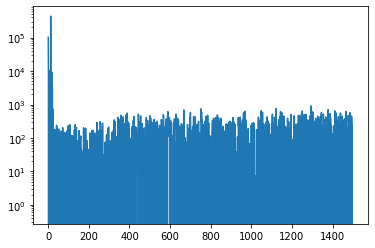

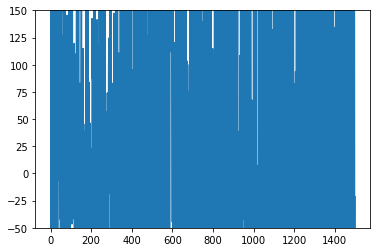


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=2.0527534191711483e-06 and pval_i=1.1702162849119284e-08
0 and 2 are DEPENDENT with pval_d=6.615036754741237e-09 and pval_i=2.453425061282643e-09
0 and 3 are independent with pval_d=3.047516555284903e-11 and pval_i=7.821356577714565e-09
0 and 4 are independent with pval_d=3.1585525712432306e-09 and pval_i=7.4296153850040534e-09
1 and 2 are independent with pval_d=1.8006366213727021e-12 and pval_i=1.0332878009604483e-09
1 and 3 are DEPENDENT with pval_d=1.3235782166535175e-10 and pval_i=1.4101760191833914e-12
1 and 4 are independent with pval_d=1.1816497983522892e-10 and pval_i=8.898980538444302e-09
2 and 3 are DEPENDENT with pval_d=2.986521002238654e-08 and pval_i=4.486866110033642e-12
2 and 4 are independent with pval_d=3.155759781699453e-11 and pval_i=1.7680973061611862e-10
3 and 4 are independent with pval_d=1.516001805713694e-08 and pval_i=2.0420527114838295e-08
0

  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:23,  1.45s/it]

0 66.99729982018471


  2%|▏         | 2/100 [00:02<02:22,  1.46s/it]

1 53.807103946805


  3%|▎         | 3/100 [00:04<02:22,  1.47s/it]

2 52.84361977875233


  4%|▍         | 4/100 [00:05<02:20,  1.47s/it]

3 52.089017264544964


  5%|▌         | 5/100 [00:07<02:18,  1.46s/it]

4 51.929643884301186


  6%|▌         | 6/100 [00:08<02:17,  1.47s/it]

5 51.687483347952366


  7%|▋         | 7/100 [00:10<02:16,  1.47s/it]

6 51.64140509068966


  8%|▊         | 8/100 [00:11<02:15,  1.47s/it]

7 51.49339208006859


  9%|▉         | 9/100 [00:13<02:13,  1.47s/it]

8 51.40019757300615


 10%|█         | 10/100 [00:14<02:12,  1.47s/it]

9 51.34450443089008


 11%|█         | 11/100 [00:16<02:10,  1.47s/it]

10 51.36425107717514


 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]

11 51.238614201545715


 13%|█▎        | 13/100 [00:19<02:07,  1.47s/it]

12 51.28215991705656


 14%|█▍        | 14/100 [00:20<02:06,  1.47s/it]

13 51.228056356310844


 15%|█▌        | 15/100 [00:22<02:05,  1.47s/it]

14 51.15923084318638


 16%|█▌        | 16/100 [00:23<02:03,  1.47s/it]

15 51.18711869418621


 17%|█▋        | 17/100 [00:24<02:01,  1.47s/it]

16 51.12726670503616


 18%|█▊        | 18/100 [00:26<02:00,  1.47s/it]

17 51.1759335398674


 19%|█▉        | 19/100 [00:27<01:58,  1.47s/it]

18 51.07880616188049


 20%|██        | 20/100 [00:29<01:56,  1.46s/it]

19 51.048165425658226


 21%|██        | 21/100 [00:30<01:55,  1.46s/it]

20 51.12182566523552


 22%|██▏       | 22/100 [00:32<01:54,  1.46s/it]

21 51.04249315708876


 23%|██▎       | 23/100 [00:33<01:52,  1.46s/it]

22 50.98833514750004


 24%|██▍       | 24/100 [00:35<01:51,  1.47s/it]

23 51.033189833164215


 25%|██▌       | 25/100 [00:36<01:49,  1.46s/it]

24 51.059939831495285


 26%|██▌       | 26/100 [00:38<01:48,  1.47s/it]

25 51.01607857644558


 27%|██▋       | 27/100 [00:39<01:47,  1.47s/it]

26 51.02547495812178


 28%|██▊       | 28/100 [00:41<01:46,  1.47s/it]

27 50.97015016525984


 29%|██▉       | 29/100 [00:42<01:44,  1.47s/it]

28 51.06131513416767


 30%|███       | 30/100 [00:44<01:43,  1.48s/it]

29 50.99943392723799


 31%|███       | 31/100 [00:45<01:42,  1.48s/it]

30 51.00020795315504


 32%|███▏      | 32/100 [00:47<01:40,  1.48s/it]

31 50.92528931051493


 33%|███▎      | 33/100 [00:48<01:38,  1.47s/it]

32 51.00446831434965


 34%|███▍      | 34/100 [00:49<01:36,  1.47s/it]

33 51.065137311816216


 35%|███▌      | 35/100 [00:51<01:35,  1.47s/it]

34 50.89604710787535


 36%|███▌      | 36/100 [00:52<01:34,  1.47s/it]

35 50.95991277694702


 37%|███▋      | 37/100 [00:54<01:32,  1.47s/it]

36 51.00113942474127


 38%|███▊      | 38/100 [00:55<01:31,  1.47s/it]

37 50.83896753191948


 39%|███▉      | 39/100 [00:57<01:30,  1.48s/it]

38 50.887121953070164


 40%|████      | 40/100 [00:58<01:28,  1.47s/it]

39 50.89543144404888


 41%|████      | 41/100 [01:00<01:26,  1.47s/it]

40 50.8378496542573


 42%|████▏     | 42/100 [01:01<01:25,  1.48s/it]

41 50.90953639894724


 43%|████▎     | 43/100 [01:03<01:24,  1.48s/it]

42 50.858782060444355


 44%|████▍     | 44/100 [01:04<01:22,  1.48s/it]

43 50.844563350081444


 45%|████▌     | 45/100 [01:06<01:21,  1.48s/it]

44 50.83434817939997


 46%|████▌     | 46/100 [01:07<01:19,  1.47s/it]

45 50.89550241082907


 47%|████▋     | 47/100 [01:09<01:17,  1.47s/it]

46 50.853905491530895


 48%|████▊     | 48/100 [01:10<01:16,  1.47s/it]

47 50.815585136413574


 49%|████▉     | 49/100 [01:12<01:14,  1.47s/it]

48 50.92514009028673


 50%|█████     | 50/100 [01:13<01:13,  1.47s/it]

49 50.80762932449579


 51%|█████     | 51/100 [01:14<01:11,  1.47s/it]

50 50.856014259159565


 52%|█████▏    | 52/100 [01:16<01:10,  1.47s/it]

51 50.816239669919014


 53%|█████▎    | 53/100 [01:17<01:09,  1.48s/it]

52 50.881003856658936


 54%|█████▍    | 54/100 [01:19<01:07,  1.47s/it]

53 50.85386814922094


 55%|█████▌    | 55/100 [01:20<01:06,  1.47s/it]

54 50.82592451572418


 56%|█████▌    | 56/100 [01:22<01:04,  1.47s/it]

55 50.810565419495106


 57%|█████▋    | 57/100 [01:23<01:03,  1.48s/it]

56 50.83821077644825


 58%|█████▊    | 58/100 [01:25<01:02,  1.48s/it]

57 50.89436523616314


 59%|█████▉    | 59/100 [01:26<01:00,  1.49s/it]

58 50.847116596996784


 60%|██████    | 60/100 [01:28<00:59,  1.48s/it]

59 50.87332137674093


 61%|██████    | 61/100 [01:29<00:57,  1.48s/it]

60 50.78254619240761


 62%|██████▏   | 62/100 [01:31<00:56,  1.48s/it]

61 50.811794593930244


 63%|██████▎   | 63/100 [01:32<00:54,  1.47s/it]

62 50.73200987279415


 64%|██████▍   | 64/100 [01:34<00:53,  1.48s/it]

63 50.86784037202597


 65%|██████▌   | 65/100 [01:35<00:51,  1.48s/it]

64 50.780136197805405


 66%|██████▌   | 66/100 [01:37<00:50,  1.47s/it]

65 50.77461887896061


 67%|██████▋   | 67/100 [01:38<00:48,  1.47s/it]

66 50.73240525275469


 68%|██████▊   | 68/100 [01:40<00:46,  1.47s/it]

67 50.83211234211922


 69%|██████▉   | 69/100 [01:41<00:45,  1.47s/it]

68 50.74897038936615


 70%|███████   | 70/100 [01:43<00:44,  1.47s/it]

69 50.73640438169241


 71%|███████   | 71/100 [01:44<00:42,  1.47s/it]

70 50.771531872451305


 72%|███████▏  | 72/100 [01:45<00:41,  1.47s/it]

71 50.75639716535807


 73%|███████▎  | 73/100 [01:47<00:39,  1.47s/it]

72 50.75078038871288


 74%|███████▍  | 74/100 [01:48<00:38,  1.47s/it]

73 50.82131914794445


 75%|███████▌  | 75/100 [01:50<00:36,  1.47s/it]

74 50.74223389476538


 76%|███████▌  | 76/100 [01:51<00:35,  1.46s/it]

75 50.76352187246084


 77%|███████▋  | 77/100 [01:53<00:33,  1.47s/it]

76 50.79042277485132


 78%|███████▊  | 78/100 [01:54<00:32,  1.47s/it]

77 50.70986147224903


 79%|███████▉  | 79/100 [01:56<00:30,  1.47s/it]

78 50.79203347861767


 80%|████████  | 80/100 [01:57<00:29,  1.46s/it]

79 50.761030584573746


 81%|████████  | 81/100 [01:59<00:27,  1.46s/it]

80 50.78200972080231


 82%|████████▏ | 82/100 [02:00<00:26,  1.47s/it]

81 50.7192661985755


 83%|████████▎ | 83/100 [02:02<00:25,  1.48s/it]

82 50.716067127883434


 84%|████████▍ | 84/100 [02:03<00:23,  1.48s/it]

83 50.709263287484646


 85%|████████▌ | 85/100 [02:05<00:22,  1.50s/it]

84 50.772978596389294


 86%|████████▌ | 86/100 [02:06<00:20,  1.49s/it]

85 50.73044481128454


 87%|████████▋ | 87/100 [02:08<00:19,  1.48s/it]

86 50.69185861945152


 88%|████████▊ | 88/100 [02:09<00:17,  1.47s/it]

87 50.70729257911444


 89%|████████▉ | 89/100 [02:11<00:16,  1.47s/it]

88 50.804285041987896


 90%|█████████ | 90/100 [02:12<00:14,  1.46s/it]

89 50.754034765064716


 91%|█████████ | 91/100 [02:13<00:13,  1.46s/it]

90 50.79196152091026


 92%|█████████▏| 92/100 [02:15<00:11,  1.47s/it]

91 50.696685165166855


 93%|█████████▎| 93/100 [02:16<00:10,  1.47s/it]

92 50.71882415562868


 94%|█████████▍| 94/100 [02:18<00:08,  1.47s/it]

93 50.76436095684767


 95%|█████████▌| 95/100 [02:19<00:07,  1.47s/it]

94 50.642713375389576


 96%|█████████▌| 96/100 [02:21<00:05,  1.47s/it]

95 50.68171864002943


 97%|█████████▋| 97/100 [02:22<00:04,  1.47s/it]

96 50.70886338502169


 98%|█████████▊| 98/100 [02:24<00:02,  1.47s/it]

97 50.734918765723705


 99%|█████████▉| 99/100 [02:25<00:01,  1.47s/it]

98 50.63953372836113


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]

99 50.797552563250065

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.0778612419962883	

epoch 9000/10000, policy loss 0.0026349180843681097	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 121.2413101196289best loss model loaded, stored at update # 496


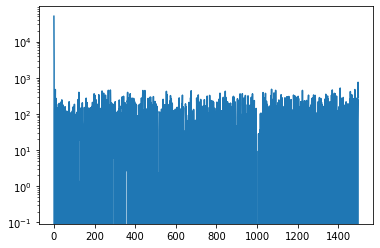

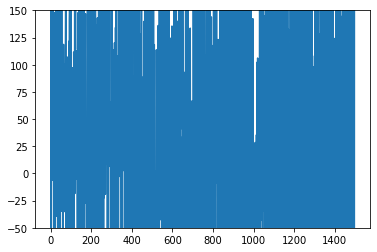


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=2.0035685851228443e-09 and pval_i=2.1140321772490154e-09
0 and 2 are independent with pval_d=1.4334780720603706e-08 and pval_i=4.9817160678126895e-08
0 and 3 are independent with pval_d=7.607866541227209e-10 and pval_i=5.123283578295388e-08
0 and 4 are independent with pval_d=5.5737994319902006e-11 and pval_i=9.354961154062435e-11
1 and 2 are DEPENDENT with pval_d=1.0495801617310023e-07 and pval_i=4.954281420058965e-09
1 and 3 are independent with pval_d=4.32019620877093e-10 and pval_i=1.2216269832601525e-07
1 and 4 are independent with pval_d=2.6921726335472385e-10 and pval_i=5.39890010778035e-10
2 and 3 are independent with pval_d=2.3173370211880407e-11 and pval_i=4.1708712863712866e-08
2 and 4 are independent with pval_d=9.573893547979998e-11 and pval_i=3.5244847196707426e-09
3 and 4 are independent with pval_d=3.5804721871666335e-08 and pval_i=3.8090309562585076

  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:26,  1.48s/it]

0 37.23341592401266


  2%|▏         | 2/100 [00:02<02:24,  1.47s/it]

1 34.43289095163345


  3%|▎         | 3/100 [00:04<02:23,  1.48s/it]

2 33.96793804317713


  4%|▍         | 4/100 [00:05<02:21,  1.48s/it]

3 33.80885515362024


  5%|▌         | 5/100 [00:07<02:20,  1.47s/it]

4 33.699637942016125


  6%|▌         | 6/100 [00:08<02:18,  1.47s/it]

5 33.6360023394227


  7%|▋         | 7/100 [00:10<02:17,  1.48s/it]

6 33.63332060724497


  8%|▊         | 8/100 [00:11<02:15,  1.48s/it]

7 33.54605735093355


  9%|▉         | 9/100 [00:13<02:14,  1.48s/it]

8 33.55195049196482


 10%|█         | 10/100 [00:14<02:13,  1.49s/it]

9 33.49562305957079


 11%|█         | 11/100 [00:16<02:12,  1.49s/it]

10 33.48854734003544


 12%|█▏        | 12/100 [00:17<02:10,  1.48s/it]

11 33.50204288214445


 13%|█▎        | 13/100 [00:19<02:08,  1.47s/it]

12 33.469861432909966


 14%|█▍        | 14/100 [00:20<02:06,  1.47s/it]

13 33.42981246113777


 15%|█▌        | 15/100 [00:22<02:04,  1.47s/it]

14 33.44020967185497


 16%|█▌        | 16/100 [00:23<02:02,  1.46s/it]

15 33.42845840007067


 17%|█▋        | 17/100 [00:25<02:01,  1.47s/it]

16 33.4006702452898


 18%|█▊        | 18/100 [00:26<02:00,  1.47s/it]

17 33.41377383470535


 19%|█▉        | 19/100 [00:27<01:59,  1.47s/it]

18 33.39610004425049


 20%|██        | 20/100 [00:29<01:57,  1.47s/it]

19 33.355213455855846


 21%|██        | 21/100 [00:30<01:55,  1.47s/it]

20 33.36053679138422


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]

21 33.371276557445526


 23%|██▎       | 23/100 [00:33<01:53,  1.47s/it]

22 33.345695454627275


 24%|██▍       | 24/100 [00:35<01:51,  1.47s/it]

23 33.352056205272675


 25%|██▌       | 25/100 [00:36<01:49,  1.46s/it]

24 33.34990331530571


 26%|██▌       | 26/100 [00:38<01:48,  1.47s/it]

25 33.33244950324297


 27%|██▋       | 27/100 [00:39<01:46,  1.46s/it]

26 33.33209204673767


 28%|██▊       | 28/100 [00:41<01:46,  1.48s/it]

27 33.30794686824083


 29%|██▉       | 29/100 [00:42<01:44,  1.47s/it]

28 33.34112921357155


 30%|███       | 30/100 [00:44<01:43,  1.47s/it]

29 33.33847949281335


 31%|███       | 31/100 [00:45<01:41,  1.47s/it]

30 33.29810005426407


 32%|███▏      | 32/100 [00:47<01:40,  1.48s/it]

31 33.305000722408295


 33%|███▎      | 33/100 [00:48<01:40,  1.50s/it]

32 33.316173017024994


 34%|███▍      | 34/100 [00:50<01:38,  1.49s/it]

33 33.33610026538372


 35%|███▌      | 35/100 [00:51<01:36,  1.49s/it]

34 33.313833352178335


 36%|███▌      | 36/100 [00:53<01:34,  1.48s/it]

35 33.30018704384565


 37%|███▋      | 37/100 [00:54<01:32,  1.48s/it]

36 33.27380285039544


 38%|███▊      | 38/100 [00:56<01:31,  1.48s/it]

37 33.30475850775838


 39%|███▉      | 39/100 [00:57<01:29,  1.47s/it]

38 33.30764830112457


 40%|████      | 40/100 [00:58<01:28,  1.47s/it]

39 33.30654065683484


 41%|████      | 41/100 [01:00<01:26,  1.47s/it]

40 33.27508422732353


 42%|████▏     | 42/100 [01:01<01:25,  1.48s/it]

41 33.30572324246168


 43%|████▎     | 43/100 [01:03<01:24,  1.49s/it]

42 33.286809634417295


 44%|████▍     | 44/100 [01:04<01:23,  1.49s/it]

43 33.264430709183216


 45%|████▌     | 45/100 [01:06<01:22,  1.49s/it]

44 33.268342450261116


 46%|████▌     | 46/100 [01:07<01:21,  1.50s/it]

45 33.27870874106884


 47%|████▋     | 47/100 [01:09<01:19,  1.50s/it]

46 33.260097935795784


 48%|████▊     | 48/100 [01:10<01:17,  1.50s/it]

47 33.28780937939882


 49%|████▉     | 49/100 [01:12<01:16,  1.50s/it]

48 33.2759529016912


 50%|█████     | 50/100 [01:13<01:15,  1.51s/it]

49 33.26959405094385


 51%|█████     | 51/100 [01:15<01:13,  1.50s/it]

50 33.280390206724405


 52%|█████▏    | 52/100 [01:16<01:11,  1.50s/it]

51 33.25929854437709


 53%|█████▎    | 53/100 [01:18<01:10,  1.50s/it]

52 33.274495020508766


 54%|█████▍    | 54/100 [01:19<01:08,  1.49s/it]

53 33.266924902796745


 55%|█████▌    | 55/100 [01:21<01:06,  1.48s/it]

54 33.2585890814662


 56%|█████▌    | 56/100 [01:22<01:05,  1.48s/it]

55 33.22939137369394


 57%|█████▋    | 57/100 [01:24<01:03,  1.48s/it]

56 33.26245868206024


 58%|█████▊    | 58/100 [01:25<01:02,  1.48s/it]

57 33.263560969382524


 59%|█████▉    | 59/100 [01:27<01:00,  1.47s/it]

58 33.247351210564375


 60%|██████    | 60/100 [01:28<00:58,  1.47s/it]

59 33.26557553932071


 61%|██████    | 61/100 [01:30<00:57,  1.47s/it]

60 33.24751875177026


 62%|██████▏   | 62/100 [01:31<00:55,  1.47s/it]

61 33.24948827549815


 63%|██████▎   | 63/100 [01:33<00:54,  1.47s/it]

62 33.23685308545828


 64%|██████▍   | 64/100 [01:34<00:52,  1.47s/it]

63 33.25612397119403


 65%|██████▌   | 65/100 [01:36<00:51,  1.47s/it]

64 33.24814347922802


 66%|██████▌   | 66/100 [01:37<00:49,  1.47s/it]

65 33.23256649821997


 67%|██████▋   | 67/100 [01:39<00:48,  1.47s/it]

66 33.24404755234718


 68%|██████▊   | 68/100 [01:40<00:47,  1.47s/it]

67 33.25061647221446


 69%|██████▉   | 69/100 [01:41<00:45,  1.47s/it]

68 33.24201036244631


 70%|███████   | 70/100 [01:43<00:44,  1.47s/it]

69 33.23425279930234


 71%|███████   | 71/100 [01:44<00:42,  1.48s/it]

70 33.22486796602607


 72%|███████▏  | 72/100 [01:46<00:41,  1.48s/it]

71 33.252770476043224


 73%|███████▎  | 73/100 [01:47<00:39,  1.47s/it]

72 33.235329657793045


 74%|███████▍  | 74/100 [01:49<00:38,  1.47s/it]

73 33.259298130869865


 75%|███████▌  | 75/100 [01:50<00:36,  1.47s/it]

74 33.24545466899872


 76%|███████▌  | 76/100 [01:52<00:35,  1.46s/it]

75 33.22758299857378


 77%|███████▋  | 77/100 [01:53<00:33,  1.46s/it]

76 33.24020428210497


 78%|███████▊  | 78/100 [01:55<00:32,  1.46s/it]

77 33.233648739755154


 79%|███████▉  | 79/100 [01:56<00:30,  1.46s/it]

78 33.22878855466843


 80%|████████  | 80/100 [01:58<00:29,  1.46s/it]

79 33.245792996138334


 81%|████████  | 81/100 [01:59<00:27,  1.46s/it]

80 33.22993515059352


 82%|████████▏ | 82/100 [02:01<00:26,  1.46s/it]

81 33.262110490351915


 83%|████████▎ | 83/100 [02:02<00:24,  1.46s/it]

82 33.20067762956023


 84%|████████▍ | 84/100 [02:03<00:23,  1.47s/it]

83 33.2170327603817


 85%|████████▌ | 85/100 [02:05<00:21,  1.47s/it]

84 33.217934757471085


 86%|████████▌ | 86/100 [02:06<00:20,  1.47s/it]

85 33.220799677073956


 87%|████████▋ | 87/100 [02:08<00:19,  1.48s/it]

86 33.22809327766299


 88%|████████▊ | 88/100 [02:09<00:17,  1.49s/it]

87 33.21598468348384


 89%|████████▉ | 89/100 [02:11<00:16,  1.48s/it]

88 33.23925866931677


 90%|█████████ | 90/100 [02:12<00:14,  1.48s/it]

89 33.209268283098936


 91%|█████████ | 91/100 [02:14<00:13,  1.49s/it]

90 33.209302861243486


 92%|█████████▏| 92/100 [02:15<00:12,  1.51s/it]

91 33.248881205916405


 93%|█████████▎| 93/100 [02:17<00:10,  1.50s/it]

92 33.22138178348541


 94%|█████████▍| 94/100 [02:18<00:08,  1.49s/it]

93 33.220763862133026


 95%|█████████▌| 95/100 [02:20<00:07,  1.48s/it]

94 33.22018026933074


 96%|█████████▌| 96/100 [02:21<00:05,  1.48s/it]

95 33.22764526680112


 97%|█████████▋| 97/100 [02:23<00:04,  1.48s/it]

96 33.21896640211344


 98%|█████████▊| 98/100 [02:24<00:02,  1.47s/it]

97 33.220638912171125


 99%|█████████▉| 99/100 [02:26<00:01,  1.47s/it]

98 33.22086530551314


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]

99 33.20164994895458

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07520651072263718	

epoch 9000/10000, policy loss 0.0071998946368694305	
***** test student *****
epoch 0/100 return: 443.0
epoch 1/100 return: 463.0
epoch 2/100 return: 441.0
epoch 3/100 return: 455.0
epoch 4/100 return: 434.0
epoch 5/100 return: 175.0
epoch 6/100 return: 445.0
epoch 7/100 return: 449.0
epoch 8/100 return: 449.0
epoch 9/100 return: 432.0
epoch 10/100 return: 451.0
epoch 11/100 return: 441.0
epoch 12/100 return: 170.0
epoch 13/100 return: 443.0
epoch 14/100 return: 163.0
epoch 15/100 return: 455.0
epoch 16/100 return: 458.0
epoch 17/100 return: 169.0
epoch 18/100 return: 177.0
epoch 19/100 return: 169.0
epoch 20/100 return: 433.0
epoch 21/100 return: 189.0
epoch 22/100 return: 431.0
epoch 23/100 return: 457.0
epoch 24/100 return: 163.0
epoch 25/100 return: 430.0
epoch 26/100 return: 428.0
epoch 27/100 return: 187.0
epoch 28/100 return: 445.0
epoch 29/100 return: 438.0
epoch 30/100 return: 180.0
epoch 31/100 return: 179.0
epoch 32/100 return: 447.0
epoch 33/100 return: 427.0
epoch 34/100 r

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 273.1382141113281best loss model loaded, stored at update # 918


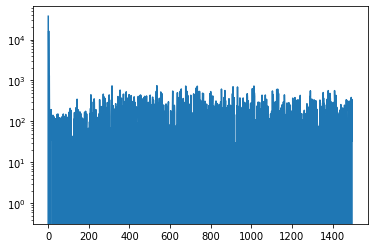

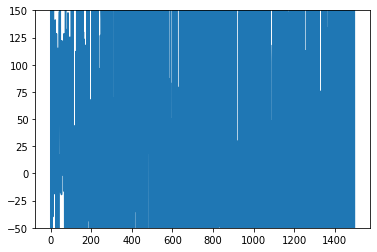


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=4.721351434835702e-11 and pval_i=6.97427368145186e-11
0 and 2 are independent with pval_d=5.376211180493875e-11 and pval_i=6.425419568056336e-09
0 and 3 are independent with pval_d=4.894867413326512e-10 and pval_i=4.297378932828799e-06
0 and 4 are independent with pval_d=1.3582240265440093e-09 and pval_i=2.542815636878481e-07
1 and 2 are independent with pval_d=5.034467224389594e-10 and pval_i=3.483609302287914e-09
1 and 3 are independent with pval_d=1.1866322884062145e-10 and pval_i=1.3675765197040672e-10
1 and 4 are independent with pval_d=4.3320131529325674e-09 and pval_i=1.0923677054636643e-08
2 and 3 are independent with pval_d=1.974434416627026e-11 and pval_i=2.41543531289504e-07
2 and 4 are independent with pval_d=1.028455825369937e-11 and pval_i=2.5502794418302264e-09
3 and 4 are independent with pval_d=9.947823159118595e-11 and pval_i=9.502627875952649e-08


  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:26,  1.48s/it]

0 26.63793732970953


  2%|▏         | 2/100 [00:02<02:25,  1.49s/it]

1 23.11880061030388


  3%|▎         | 3/100 [00:04<02:23,  1.48s/it]

2 22.48956585675478


  4%|▍         | 4/100 [00:05<02:21,  1.48s/it]

3 22.282257739454508


  5%|▌         | 5/100 [00:07<02:19,  1.47s/it]

4 22.171508137136698


  6%|▌         | 6/100 [00:08<02:18,  1.48s/it]

5 22.05467326194048


  7%|▋         | 7/100 [00:10<02:16,  1.47s/it]

6 21.98403974249959


  8%|▊         | 8/100 [00:11<02:15,  1.47s/it]

7 21.859287530183792


  9%|▉         | 9/100 [00:13<02:14,  1.48s/it]

8 21.70942598953843


 10%|█         | 10/100 [00:14<02:13,  1.48s/it]

9 21.640288040041924


 11%|█         | 11/100 [00:16<02:10,  1.47s/it]

10 21.56854721158743


 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]

11 21.527070205658674


 13%|█▎        | 13/100 [00:19<02:07,  1.47s/it]

12 21.514904651790857


 14%|█▍        | 14/100 [00:20<02:06,  1.47s/it]

13 21.436707947403193


 15%|█▌        | 15/100 [00:22<02:05,  1.47s/it]

14 21.422026872634888


 16%|█▌        | 16/100 [00:23<02:02,  1.46s/it]

15 21.35564886033535


 17%|█▋        | 17/100 [00:25<02:01,  1.46s/it]

16 21.32299941778183


 18%|█▊        | 18/100 [00:26<02:00,  1.47s/it]

17 21.29726393520832


 19%|█▉        | 19/100 [00:27<01:59,  1.47s/it]

18 21.243149992078543


 20%|██        | 20/100 [00:29<01:58,  1.49s/it]

19 21.2247317135334


 21%|██        | 21/100 [00:30<01:56,  1.47s/it]

20 21.18943826109171


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]

21 21.188075460493565


 23%|██▎       | 23/100 [00:33<01:52,  1.47s/it]

22 21.144870072603226


 24%|██▍       | 24/100 [00:35<01:52,  1.47s/it]

23 21.172700636088848


 25%|██▌       | 25/100 [00:36<01:50,  1.47s/it]

24 21.179201390594244


 26%|██▌       | 26/100 [00:38<01:49,  1.47s/it]

25 21.130361158400774


 27%|██▋       | 27/100 [00:39<01:47,  1.47s/it]

26 21.113372702151537


 28%|██▊       | 28/100 [00:41<01:45,  1.47s/it]

27 21.136678896844387


 29%|██▉       | 29/100 [00:42<01:44,  1.48s/it]

28 21.11059806495905


 30%|███       | 30/100 [00:44<01:43,  1.47s/it]

29 21.12612034380436


 31%|███       | 31/100 [00:45<01:41,  1.47s/it]

30 21.106130219995975


 32%|███▏      | 32/100 [00:47<01:39,  1.47s/it]

31 21.10403984040022


 33%|███▎      | 33/100 [00:48<01:38,  1.47s/it]

32 21.107859931886196


 34%|███▍      | 34/100 [00:50<01:36,  1.47s/it]

33 21.117318402975798


 35%|███▌      | 35/100 [00:51<01:35,  1.47s/it]

34 21.093286961317062


 36%|███▌      | 36/100 [00:52<01:33,  1.46s/it]

35 21.068042185157537


 37%|███▋      | 37/100 [00:54<01:32,  1.47s/it]

36 21.118395797908306


 38%|███▊      | 38/100 [00:55<01:32,  1.49s/it]

37 21.074261985719204


 39%|███▉      | 39/100 [00:57<01:30,  1.49s/it]

38 21.096261769533157


 40%|████      | 40/100 [00:58<01:28,  1.48s/it]

39 21.059587232768536


 41%|████      | 41/100 [01:00<01:27,  1.48s/it]

40 21.077898405492306


 42%|████▏     | 42/100 [01:01<01:25,  1.47s/it]

41 21.05811806023121


 43%|████▎     | 43/100 [01:03<01:24,  1.48s/it]

42 21.08385744318366


 44%|████▍     | 44/100 [01:04<01:22,  1.48s/it]

43 21.016043476760387


 45%|████▌     | 45/100 [01:06<01:21,  1.48s/it]

44 21.048879977315664


 46%|████▌     | 46/100 [01:07<01:19,  1.48s/it]

45 21.054487761110067


 47%|████▋     | 47/100 [01:09<01:18,  1.47s/it]

46 21.040246602147818


 48%|████▊     | 48/100 [01:10<01:16,  1.47s/it]

47 21.043114941567183


 49%|████▉     | 49/100 [01:12<01:15,  1.48s/it]

48 21.043418757617474


 50%|█████     | 50/100 [01:13<01:13,  1.48s/it]

49 21.036617524921894


 51%|█████     | 51/100 [01:15<01:12,  1.48s/it]

50 21.04488690942526


 52%|█████▏    | 52/100 [01:16<01:11,  1.48s/it]

51 21.047233998775482


 53%|█████▎    | 53/100 [01:18<01:09,  1.48s/it]

52 21.037597622722387


 54%|█████▍    | 54/100 [01:19<01:08,  1.49s/it]

53 21.009775906801224


 55%|█████▌    | 55/100 [01:21<01:06,  1.48s/it]

54 21.012260995805264


 56%|█████▌    | 56/100 [01:22<01:05,  1.48s/it]

55 21.0284767113626


 57%|█████▋    | 57/100 [01:24<01:03,  1.47s/it]

56 21.004072323441505


 58%|█████▊    | 58/100 [01:25<01:01,  1.47s/it]

57 21.02338071167469


 59%|█████▉    | 59/100 [01:26<01:00,  1.47s/it]

58 21.02334100008011


 60%|██████    | 60/100 [01:28<00:59,  1.48s/it]

59 21.307829275727272


 61%|██████    | 61/100 [01:29<00:57,  1.47s/it]

60 20.984899297356606


 62%|██████▏   | 62/100 [01:31<00:56,  1.47s/it]

61 20.997684877365828


 63%|██████▎   | 63/100 [01:32<00:54,  1.48s/it]

62 20.9861301779747


 64%|██████▍   | 64/100 [01:34<00:53,  1.48s/it]

63 20.99907708913088


 65%|██████▌   | 65/100 [01:35<00:51,  1.47s/it]

64 20.983362179249525


 66%|██████▌   | 66/100 [01:37<00:50,  1.47s/it]

65 21.004934702068567


 67%|██████▋   | 67/100 [01:38<00:48,  1.47s/it]

66 21.001591611653566


 68%|██████▊   | 68/100 [01:40<00:47,  1.47s/it]

67 20.992011599242687


 69%|██████▉   | 69/100 [01:41<00:45,  1.48s/it]

68 21.00434597954154


 70%|███████   | 70/100 [01:43<00:44,  1.47s/it]

69 20.977417923510075


 71%|███████   | 71/100 [01:44<00:42,  1.47s/it]

70 20.992387525737286


 72%|███████▏  | 72/100 [01:46<00:41,  1.47s/it]

71 20.98970489948988


 73%|███████▎  | 73/100 [01:47<00:39,  1.47s/it]

72 20.98406543955207


 74%|███████▍  | 74/100 [01:49<00:38,  1.47s/it]

73 20.98727308958769


 75%|███████▌  | 75/100 [01:50<00:36,  1.47s/it]

74 20.97605051100254


 76%|███████▌  | 76/100 [01:52<00:35,  1.47s/it]

75 20.988510835915804


 77%|███████▋  | 77/100 [01:53<00:33,  1.46s/it]

76 21.00993414223194


 78%|███████▊  | 78/100 [01:54<00:32,  1.46s/it]

77 20.98205568268895


 79%|███████▉  | 79/100 [01:56<00:30,  1.47s/it]

78 20.980765726417303


 80%|████████  | 80/100 [01:57<00:29,  1.47s/it]

79 20.969130896031857


 81%|████████  | 81/100 [01:59<00:28,  1.47s/it]

80 20.95802155137062


 82%|████████▏ | 82/100 [02:00<00:26,  1.48s/it]

81 21.000844232738018


 83%|████████▎ | 83/100 [02:02<00:24,  1.47s/it]

82 20.95882334187627


 84%|████████▍ | 84/100 [02:03<00:23,  1.47s/it]

83 20.94842755049467


 85%|████████▌ | 85/100 [02:05<00:22,  1.47s/it]

84 20.975183855742216


 86%|████████▌ | 86/100 [02:06<00:20,  1.47s/it]

85 20.975855592638254


 87%|████████▋ | 87/100 [02:08<00:19,  1.47s/it]

86 20.961237907409668


 88%|████████▊ | 88/100 [02:09<00:17,  1.47s/it]

87 21.42125067859888


 89%|████████▉ | 89/100 [02:11<00:16,  1.46s/it]

88 20.962277494370937


 90%|█████████ | 90/100 [02:12<00:14,  1.47s/it]

89 20.940885327756405


 91%|█████████ | 91/100 [02:14<00:13,  1.47s/it]

90 20.931078489869833


 92%|█████████▏| 92/100 [02:15<00:11,  1.48s/it]

91 20.95447001233697


 93%|█████████▎| 93/100 [02:17<00:10,  1.49s/it]

92 20.96204011887312


 94%|█████████▍| 94/100 [02:18<00:08,  1.49s/it]

93 20.969681181013584


 95%|█████████▌| 95/100 [02:20<00:07,  1.50s/it]

94 20.957179866731167


 96%|█████████▌| 96/100 [02:21<00:06,  1.51s/it]

95 20.960638269782066


 97%|█████████▋| 97/100 [02:23<00:04,  1.51s/it]

96 20.966773752123117


 98%|█████████▊| 98/100 [02:24<00:03,  1.50s/it]

97 20.958561681210995


 99%|█████████▉| 99/100 [02:26<00:01,  1.51s/it]

98 20.959519661962986


100%|██████████| 100/100 [02:27<00:00,  1.51s/it]

99 20.95143713057041

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07624366879463196	

epoch 9000/10000, policy loss 0.0031976071186363697	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  5
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 365.9873352050781best loss model loaded, stored at update # 254


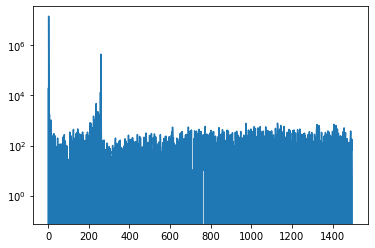

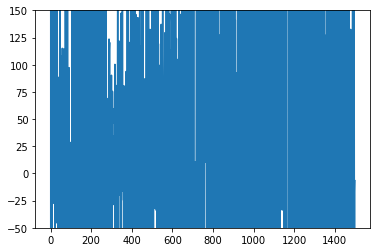


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.03623774569763051 and pval_i=0.9473575578309575
0 and 2 are independent with pval_d=1.1798201514943017e-05 and pval_i=0.00010286932380462638
0 and 3 are independent with pval_d=0.8757174375037114 and pval_i=0.9879622043446922
0 and 4 are independent with pval_d=0.00027148888289321396 and pval_i=0.02110906684187107
1 and 2 are independent with pval_d=5.845358461518428e-06 and pval_i=0.8957126024945661
1 and 3 are independent with pval_d=0.021599790408999727 and pval_i=0.6511023440167459
1 and 4 are independent with pval_d=0.0007815218971052275 and pval_i=0.9694632700942116
2 and 3 are independent with pval_d=3.2326010389004187e-05 and pval_i=6.966693815974182e-05
2 and 4 are independent with pval_d=3.929314661235083e-08 and pval_i=8.997124177393294e-08
3 and 4 are independent with pval_d=0.0020333061492035683 and pval_i=0.003044729571898961
0 0
1 0
2 0
3 0
4 0
pare

  0%|          | 0/100 [00:00<?, ?it/s]

generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:26,  1.48s/it]

0 309.1523413658142


  2%|▏         | 2/100 [00:02<02:25,  1.48s/it]

1 308.21402579545975


  3%|▎         | 3/100 [00:04<02:24,  1.49s/it]

2 307.94631642103195


  4%|▍         | 4/100 [00:05<02:23,  1.50s/it]

3 307.95679998397827


  5%|▌         | 5/100 [00:07<02:22,  1.50s/it]

4 307.91600263118744


  6%|▌         | 6/100 [00:08<02:20,  1.50s/it]

5 307.87763875722885


  7%|▋         | 7/100 [00:10<02:19,  1.50s/it]

6 307.8761982321739


  8%|▊         | 8/100 [00:11<02:17,  1.50s/it]

7 307.83321726322174


  9%|▉         | 9/100 [00:13<02:16,  1.50s/it]

8 307.80353343486786


 10%|█         | 10/100 [00:14<02:14,  1.50s/it]

9 307.8664860725403


 11%|█         | 11/100 [00:16<02:12,  1.49s/it]

10 307.78981494903564


 12%|█▏        | 12/100 [00:17<02:11,  1.50s/it]

11 307.8007798194885


 13%|█▎        | 13/100 [00:19<02:09,  1.49s/it]

12 307.7895381450653


 14%|█▍        | 14/100 [00:20<02:07,  1.48s/it]

13 307.7787905931473


 15%|█▌        | 15/100 [00:22<02:05,  1.47s/it]

14 307.77164500951767


 16%|█▌        | 16/100 [00:23<02:03,  1.47s/it]

15 307.7416605949402


 17%|█▋        | 17/100 [00:25<02:02,  1.47s/it]

16 307.7809274792671


 18%|█▊        | 18/100 [00:26<02:00,  1.47s/it]

17 307.6848393678665


 19%|█▉        | 19/100 [00:28<01:59,  1.47s/it]

18 307.7415459752083


 20%|██        | 20/100 [00:29<01:57,  1.47s/it]

19 307.76732951402664


 21%|██        | 21/100 [00:31<01:56,  1.48s/it]

20 307.72359150648117


 22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]

21 307.67128324508667


 23%|██▎       | 23/100 [00:34<01:52,  1.47s/it]

22 307.7034420967102


 24%|██▍       | 24/100 [00:35<01:51,  1.47s/it]

23 307.71777534484863


 25%|██▌       | 25/100 [00:37<01:49,  1.46s/it]

24 307.6740030646324


 26%|██▌       | 26/100 [00:38<01:48,  1.46s/it]

25 307.7038316130638


 27%|██▋       | 27/100 [00:39<01:47,  1.47s/it]

26 307.70065516233444


 28%|██▊       | 28/100 [00:41<01:45,  1.47s/it]

27 307.66119992733


 29%|██▉       | 29/100 [00:42<01:43,  1.46s/it]

28 307.6863718032837


 30%|███       | 30/100 [00:44<01:42,  1.46s/it]

29 307.7089812159538


 31%|███       | 31/100 [00:45<01:40,  1.46s/it]

30 307.7162355184555


 32%|███▏      | 32/100 [00:47<01:39,  1.47s/it]

31 307.7349178791046


 33%|███▎      | 33/100 [00:48<01:38,  1.47s/it]

32 307.6794983744621


 34%|███▍      | 34/100 [00:50<01:37,  1.48s/it]

33 307.7358728647232


 35%|███▌      | 35/100 [00:51<01:35,  1.47s/it]

34 307.73557835817337


 36%|███▌      | 36/100 [00:53<01:34,  1.48s/it]

35 307.7190121412277


 37%|███▋      | 37/100 [00:54<01:32,  1.47s/it]

36 307.69942528009415


 38%|███▊      | 38/100 [00:56<01:31,  1.47s/it]

37 307.68691247701645


 39%|███▉      | 39/100 [00:57<01:29,  1.46s/it]

38 307.6717084646225


 40%|████      | 40/100 [00:59<01:27,  1.47s/it]

39 307.6748358011246


 41%|████      | 41/100 [01:00<01:26,  1.47s/it]

40 307.69106286764145


 42%|████▏     | 42/100 [01:02<01:25,  1.47s/it]

41 307.71885949373245


 43%|████▎     | 43/100 [01:03<01:24,  1.48s/it]

42 307.6806121468544


 44%|████▍     | 44/100 [01:04<01:22,  1.47s/it]

43 307.68054163455963


 45%|████▌     | 45/100 [01:06<01:20,  1.47s/it]

44 307.68477100133896


 46%|████▌     | 46/100 [01:07<01:19,  1.47s/it]

45 307.73941600322723


 47%|████▋     | 47/100 [01:09<01:18,  1.47s/it]

46 307.65604799985886


 48%|████▊     | 48/100 [01:10<01:16,  1.48s/it]

47 307.68710255622864


 49%|████▉     | 49/100 [01:12<01:15,  1.47s/it]

48 307.7124324440956


 50%|█████     | 50/100 [01:13<01:13,  1.47s/it]

49 307.6837322115898


 51%|█████     | 51/100 [01:15<01:12,  1.47s/it]

50 307.66609531641006


 52%|█████▏    | 52/100 [01:16<01:10,  1.48s/it]

51 307.71799433231354


 53%|█████▎    | 53/100 [01:18<01:09,  1.48s/it]

52 307.6453002691269


 54%|█████▍    | 54/100 [01:19<01:08,  1.48s/it]

53 307.6682711839676


 55%|█████▌    | 55/100 [01:21<01:06,  1.49s/it]

54 307.72428810596466


 56%|█████▌    | 56/100 [01:22<01:06,  1.50s/it]

55 307.62968748807907


 57%|█████▋    | 57/100 [01:24<01:04,  1.49s/it]

56 307.7232791185379


 58%|█████▊    | 58/100 [01:25<01:02,  1.49s/it]

57 307.701851606369


 59%|█████▉    | 59/100 [01:27<01:00,  1.49s/it]

58 307.7088642716408


 60%|██████    | 60/100 [01:28<01:00,  1.50s/it]

59 307.66162806749344


 61%|██████    | 61/100 [01:30<00:58,  1.50s/it]

60 307.6910232305527


 62%|██████▏   | 62/100 [01:31<00:57,  1.50s/it]

61 307.6856827735901


 63%|██████▎   | 63/100 [01:33<00:55,  1.50s/it]

62 307.7099235653877


 64%|██████▍   | 64/100 [01:34<00:54,  1.51s/it]

63 307.7196755409241


 65%|██████▌   | 65/100 [01:36<00:52,  1.51s/it]

64 307.6984512209892


 66%|██████▌   | 66/100 [01:37<00:51,  1.51s/it]

65 307.70997846126556


 67%|██████▋   | 67/100 [01:39<00:49,  1.50s/it]

66 307.67659920454025


 68%|██████▊   | 68/100 [01:40<00:48,  1.50s/it]

67 307.68615490198135


 69%|██████▉   | 69/100 [01:42<00:46,  1.49s/it]

68 307.6807214617729


 70%|███████   | 70/100 [01:43<00:44,  1.48s/it]

69 307.6828570365906


 71%|███████   | 71/100 [01:45<00:42,  1.48s/it]

70 307.6594203710556


 72%|███████▏  | 72/100 [01:46<00:41,  1.48s/it]

71 307.6703847646713


 73%|███████▎  | 73/100 [01:48<00:39,  1.48s/it]

72 307.7176485657692


 74%|███████▍  | 74/100 [01:49<00:38,  1.48s/it]

73 307.67548513412476


 75%|███████▌  | 75/100 [01:51<00:36,  1.47s/it]

74 307.67109829187393


 76%|███████▌  | 76/100 [01:52<00:35,  1.47s/it]

75 307.7199866771698


 77%|███████▋  | 77/100 [01:53<00:33,  1.47s/it]

76 307.66466706991196


 78%|███████▊  | 78/100 [01:55<00:32,  1.47s/it]

77 307.65902203321457


 79%|███████▉  | 79/100 [01:56<00:30,  1.47s/it]

78 307.6845797896385


 80%|████████  | 80/100 [01:58<00:29,  1.47s/it]

79 307.6821814775467


 81%|████████  | 81/100 [01:59<00:27,  1.47s/it]

80 307.71100533008575


 82%|████████▏ | 82/100 [02:01<00:26,  1.48s/it]

81 307.69275760650635


 83%|████████▎ | 83/100 [02:02<00:24,  1.47s/it]

82 307.664646923542


 84%|████████▍ | 84/100 [02:04<00:23,  1.48s/it]

83 307.6925300359726


 85%|████████▌ | 85/100 [02:05<00:22,  1.47s/it]

84 307.69713002443314


 86%|████████▌ | 86/100 [02:07<00:20,  1.47s/it]

85 307.6490430235863


 87%|████████▋ | 87/100 [02:08<00:19,  1.47s/it]

86 307.6685118675232


 88%|████████▊ | 88/100 [02:10<00:17,  1.48s/it]

87 307.687163233757


 89%|████████▉ | 89/100 [02:11<00:16,  1.48s/it]

88 307.69922786951065


 90%|█████████ | 90/100 [02:13<00:14,  1.47s/it]

89 307.6905292868614


 91%|█████████ | 91/100 [02:14<00:13,  1.47s/it]

90 307.67866933345795


 92%|█████████▏| 92/100 [02:16<00:11,  1.48s/it]

91 307.6831260919571


 93%|█████████▎| 93/100 [02:17<00:10,  1.47s/it]

92 307.68916541337967


 94%|█████████▍| 94/100 [02:19<00:08,  1.48s/it]

93 307.69271606206894


 95%|█████████▌| 95/100 [02:20<00:07,  1.47s/it]

94 307.6927956342697


 96%|█████████▌| 96/100 [02:21<00:05,  1.47s/it]

95 307.7101322412491


 97%|█████████▋| 97/100 [02:23<00:04,  1.47s/it]

96 307.7061349749565


 98%|█████████▊| 98/100 [02:24<00:02,  1.47s/it]

97 307.654604613781


 99%|█████████▉| 99/100 [02:26<00:01,  1.47s/it]

98 307.6726015806198


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]

99 307.70246183872223

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07444572448730469	

epoch 9000/10000, policy loss 0.060543548315763474	
***** test student *****
epoch 0/100 return: 11.0
epoch 1/100 return: 11.0
epoch 2/100 return: 11.0
epoch 3/100 return: 9.0
epoch 4/100 return: 11.0
epoch 5/100 return: 9.0
epoch 6/100 return: 11.0
epoch 7/100 return: 11.0
epoch 8/100 return: 11.0
epoch 9/100 return: 8.0
epoch 10/100 return: 10.0
epoch 11/100 return: 9.0
epoch 12/100 return: 12.0
epoch 13/100 return: 11.0
epoch 14/100 return: 10.0
epoch 15/100 return: 10.0
epoch 16/100 return: 10.0
epoch 17/100 return: 10.0
epoch 18/100 return: 11.0
epoch 19/100 return: 10.0
epoch 20/100 return: 11.0
epoch 21/100 return: 12.0
epoch 22/100 return: 10.0
epoch 23/100 return: 10.0
epoch 24/100 return: 12.0
epoch 25/100 return: 10.0
epoch 26/100 return: 9.0
epoch 27/100 return: 10.0
epoch 28/100 return: 11.0
epoch 29/100 return: 8.0
epoch 30/100 return: 11.0
epoch 31/100 return: 8.0
epoch 32/100 return: 11.0
epoch 33/100 return: 10.0
epoch 34/100 return: 10.0
epoch 35/100 return: 10.0
epoc

In [8]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test2_thneg1_state5_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_neg1 = policy_loss_list

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = -1, state_dim = 8]

In [9]:
config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 0

batch size =  50000
Config: {'ALG': 'May1_test_th0_state8_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 0, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 1 out of 10

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -391.660400390625best loss model loaded, stored at update # 1170


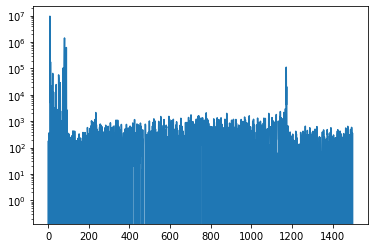

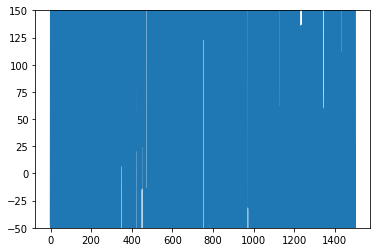


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=4.07131487315901e-10 and pval_i=6.60261962399571e-10
0 and 2 are DEPENDENT with pval_d=1.2615012989642115e-08 and pval_i=1.2877662069738888e-09
0 and 3 are independent with pval_d=6.734170541452446e-10 and pval_i=6.214949813942083e-08
0 and 4 are DEPENDENT with pval_d=3.98050075594969e-09 and pval_i=2.0072782003727542e-10
0 and 5 are independent with pval_d=1.0567782578895818e-10 and pval_i=1.4989464960063706e-08
0 and 6 are independent with pval_d=4.771705103318192e-09 and pval_i=1.4186842130423305e-08
0 and 7 are DEPENDENT with pval_d=9.662937315520173e-11 and pval_i=3.245880317176036e-11
1 and 2 are independent with pval_d=6.359368745599661e-11 and pval_i=1.388288849650666e-10
1 and 3 are independent with pval_d=4.879179449651773e-12 and pval_i=1.459533052938338e-09
1 and 4 are DEPENDENT with pval_d=4.2272348522450166e-10 and pval_i=2.997677007298005e-10
1 and 5 

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/student/nfivae_irm_student.py:287: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  x = torch.FloatTensor(all_states).to(self.device)


generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:38,  1.60s/it]

0 75.6522097736597


  2%|▏         | 2/100 [00:03<02:36,  1.60s/it]

1 61.64748667925596


  3%|▎         | 3/100 [00:04<02:33,  1.58s/it]

2 59.840948566794395


  4%|▍         | 4/100 [00:06<02:32,  1.58s/it]

3 58.88456726074219


  5%|▌         | 5/100 [00:07<02:30,  1.58s/it]

4 58.74372533708811


  6%|▌         | 6/100 [00:09<02:28,  1.58s/it]

5 58.203293189406395


  7%|▋         | 7/100 [00:11<02:26,  1.58s/it]

6 58.056711085140705


  8%|▊         | 8/100 [00:12<02:25,  1.58s/it]

7 57.65347225219011


  9%|▉         | 9/100 [00:14<02:23,  1.58s/it]

8 57.55260523408651


 10%|█         | 10/100 [00:15<02:22,  1.59s/it]

9 57.5568403750658


 11%|█         | 11/100 [00:17<02:20,  1.57s/it]

10 57.24727366119623


 12%|█▏        | 12/100 [00:18<02:19,  1.58s/it]

11 57.05857998132706


 13%|█▎        | 13/100 [00:20<02:16,  1.57s/it]

12 57.164654307067394


 14%|█▍        | 14/100 [00:22<02:14,  1.57s/it]

13 57.02473885565996


 15%|█▌        | 15/100 [00:23<02:14,  1.58s/it]

14 56.86672978103161


 16%|█▌        | 16/100 [00:25<02:11,  1.57s/it]

15 56.93796179443598


 17%|█▋        | 17/100 [00:26<02:10,  1.57s/it]

16 56.536361552774906


 18%|█▊        | 18/100 [00:28<02:08,  1.57s/it]

17 56.720430456101894


 19%|█▉        | 19/100 [00:29<02:06,  1.57s/it]

18 56.55622746795416


 20%|██        | 20/100 [00:31<02:05,  1.57s/it]

19 56.57624275237322


 21%|██        | 21/100 [00:33<02:04,  1.58s/it]

20 56.336689718067646


 22%|██▏       | 22/100 [00:34<02:04,  1.59s/it]

21 56.37231273204088


 23%|██▎       | 23/100 [00:36<02:02,  1.59s/it]

22 56.24967233091593


 24%|██▍       | 24/100 [00:37<02:00,  1.59s/it]

23 56.20000632107258


 25%|██▌       | 25/100 [00:39<01:58,  1.59s/it]

24 56.215984992682934


 26%|██▌       | 26/100 [00:41<01:57,  1.59s/it]

25 56.1649312004447


 27%|██▋       | 27/100 [00:42<01:55,  1.58s/it]

26 56.03941261768341


 28%|██▊       | 28/100 [00:44<01:53,  1.58s/it]

27 56.15273005515337


 29%|██▉       | 29/100 [00:45<01:51,  1.58s/it]

28 56.12657669186592


 30%|███       | 30/100 [00:47<01:50,  1.58s/it]

29 56.216366954147816


 31%|███       | 31/100 [00:48<01:49,  1.58s/it]

30 55.991566367447376


 32%|███▏      | 32/100 [00:50<01:47,  1.58s/it]

31 56.06458339840174


 33%|███▎      | 33/100 [00:52<01:45,  1.57s/it]

32 56.00654733926058


 34%|███▍      | 34/100 [00:53<01:43,  1.56s/it]

33 56.08576054126024


 35%|███▌      | 35/100 [00:55<01:42,  1.58s/it]

34 55.85878414660692


 36%|███▌      | 36/100 [00:56<01:41,  1.58s/it]

35 55.962195955216885


 37%|███▋      | 37/100 [00:58<01:39,  1.57s/it]

36 55.82974352687597


 38%|███▊      | 38/100 [01:00<01:37,  1.58s/it]

37 55.785811111330986


 39%|███▉      | 39/100 [01:01<01:36,  1.58s/it]

38 55.85152813792229


 40%|████      | 40/100 [01:03<01:35,  1.59s/it]

39 55.84532070159912


 41%|████      | 41/100 [01:04<01:33,  1.59s/it]

40 55.679029032588005


 42%|████▏     | 42/100 [01:06<01:31,  1.58s/it]

41 55.78814224898815


 43%|████▎     | 43/100 [01:07<01:29,  1.57s/it]

42 55.85536037385464


 44%|████▍     | 44/100 [01:09<01:29,  1.60s/it]

43 55.73765917122364


 45%|████▌     | 45/100 [01:11<01:27,  1.59s/it]

44 55.8125536814332


 46%|████▌     | 46/100 [01:12<01:25,  1.58s/it]

45 55.72784962505102


 47%|████▋     | 47/100 [01:14<01:24,  1.59s/it]

46 55.754225075244904


 48%|████▊     | 48/100 [01:15<01:22,  1.59s/it]

47 55.57403792440891


 49%|████▉     | 49/100 [01:17<01:21,  1.59s/it]

48 55.58532363176346


 50%|█████     | 50/100 [01:19<01:20,  1.60s/it]

49 55.70288509130478


 51%|█████     | 51/100 [01:20<01:18,  1.59s/it]

50 55.76648386567831


 52%|█████▏    | 52/100 [01:22<01:16,  1.59s/it]

51 55.51488488167524


 53%|█████▎    | 53/100 [01:23<01:14,  1.58s/it]

52 55.67861670255661


 54%|█████▍    | 54/100 [01:25<01:13,  1.59s/it]

53 55.47582791745663


 55%|█████▌    | 55/100 [01:27<01:11,  1.58s/it]

54 55.67104013264179


 56%|█████▌    | 56/100 [01:28<01:09,  1.57s/it]

55 55.513054102659225


 57%|█████▋    | 57/100 [01:30<01:07,  1.58s/it]

56 55.41468745470047


 58%|█████▊    | 58/100 [01:31<01:06,  1.59s/it]

57 55.50185076147318


 59%|█████▉    | 59/100 [01:33<01:05,  1.60s/it]

58 55.61819974333048


 60%|██████    | 60/100 [01:34<01:03,  1.60s/it]

59 55.546189695596695


 61%|██████    | 61/100 [01:36<01:02,  1.60s/it]

60 55.483969278633595


 62%|██████▏   | 62/100 [01:38<01:00,  1.59s/it]

61 55.5054687410593


 63%|██████▎   | 63/100 [01:39<00:58,  1.59s/it]

62 55.527325324714184


 64%|██████▍   | 64/100 [01:41<00:57,  1.59s/it]

63 55.577848955988884


 65%|██████▌   | 65/100 [01:42<00:55,  1.58s/it]

64 55.410288505256176


 66%|██████▌   | 66/100 [01:44<00:53,  1.58s/it]

65 55.47119375318289


 67%|██████▋   | 67/100 [01:46<00:52,  1.58s/it]

66 55.47997038811445


 68%|██████▊   | 68/100 [01:47<00:50,  1.59s/it]

67 55.363617554306984


 69%|██████▉   | 69/100 [01:49<00:49,  1.60s/it]

68 55.45969555526972


 70%|███████   | 70/100 [01:50<00:47,  1.59s/it]

69 55.516250252723694


 71%|███████   | 71/100 [01:52<00:45,  1.58s/it]

70 55.370590560138226


 72%|███████▏  | 72/100 [01:53<00:44,  1.58s/it]

71 55.476931400597095


 73%|███████▎  | 73/100 [01:55<00:42,  1.58s/it]

72 55.372341088950634


 74%|███████▍  | 74/100 [01:57<00:41,  1.58s/it]

73 55.43306605517864


 75%|███████▌  | 75/100 [01:58<00:39,  1.60s/it]

74 55.411163829267025


 76%|███████▌  | 76/100 [02:00<00:38,  1.60s/it]

75 55.31469988822937


 77%|███████▋  | 77/100 [02:01<00:36,  1.59s/it]

76 55.42851973325014


 78%|███████▊  | 78/100 [02:03<00:34,  1.58s/it]

77 55.40099007636309


 79%|███████▉  | 79/100 [02:05<00:33,  1.59s/it]

78 55.31400280445814


 80%|████████  | 80/100 [02:06<00:31,  1.58s/it]

79 55.39243806153536


 81%|████████  | 81/100 [02:08<00:30,  1.59s/it]

80 55.568093717098236


 82%|████████▏ | 82/100 [02:09<00:28,  1.60s/it]

81 55.3332152441144


 83%|████████▎ | 83/100 [02:11<00:27,  1.59s/it]

82 55.27181138843298


 84%|████████▍ | 84/100 [02:13<00:25,  1.59s/it]

83 55.32290907204151


 85%|████████▌ | 85/100 [02:14<00:23,  1.59s/it]

84 55.414860777556896


 86%|████████▌ | 86/100 [02:16<00:22,  1.58s/it]

85 55.3260937333107


 87%|████████▋ | 87/100 [02:17<00:20,  1.57s/it]

86 55.34718904644251


 88%|████████▊ | 88/100 [02:19<00:18,  1.58s/it]

87 55.35472743213177


 89%|████████▉ | 89/100 [02:20<00:17,  1.59s/it]

88 55.31171166151762


 90%|█████████ | 90/100 [02:22<00:15,  1.59s/it]

89 55.26373516023159


 91%|█████████ | 91/100 [02:24<00:14,  1.60s/it]

90 55.25948739051819


 92%|█████████▏| 92/100 [02:25<00:12,  1.59s/it]

91 55.34103213995695


 93%|█████████▎| 93/100 [02:27<00:11,  1.59s/it]

92 55.36066124588251


 94%|█████████▍| 94/100 [02:28<00:09,  1.59s/it]

93 55.28739543259144


 95%|█████████▌| 95/100 [02:30<00:07,  1.59s/it]

94 55.40622216463089


 96%|█████████▌| 96/100 [02:32<00:06,  1.58s/it]

95 55.27796305716038


 97%|█████████▋| 97/100 [02:33<00:04,  1.60s/it]

96 55.281574949622154


 98%|█████████▊| 98/100 [02:35<00:03,  1.60s/it]

97 55.1981333643198


 99%|█████████▉| 99/100 [02:36<00:01,  1.60s/it]

98 55.30753803998232


100%|██████████| 100/100 [02:38<00:00,  1.59s/it]

99 55.30323000252247

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07464898377656937	

epoch 9000/10000, policy loss 0.0017300810432061553	
***** test student *****
epoch 0/100 return: 145.0
epoch 1/100 return: 500.0
epoch 2/100 return: 150.0
epoch 3/100 return: 412.0
epoch 4/100 return: 144.0
epoch 5/100 return: 137.0
epoch 6/100 return: 135.0
epoch 7/100 return: 143.0
epoch 8/100 return: 152.0
epoch 9/100 return: 150.0
epoch 10/100 return: 147.0
epoch 11/100 return: 139.0
epoch 12/100 return: 148.0
epoch 13/100 return: 456.0
epoch 14/100 return: 143.0
epoch 15/100 return: 157.0
epoch 16/100 return: 140.0
epoch 17/100 return: 494.0
epoch 18/100 return: 488.0
epoch 19/100 return: 154.0
epoch 20/100 return: 396.0
epoch 21/100 return: 145.0
epoch 22/100 return: 142.0
epoch 23/100 return: 164.0
epoch 24/100 return: 410.0
epoch 25/100 return: 139.0
epoch 26/100 return: 139.0
epoch 27/100 return: 439.0
epoch 28/100 return: 145.0
epoch 29/100 return: 147.0
epoch 30/100 return: 136.0
epoch 31/100 return: 500.0
epoch 32/100 return: 136.0
epoch 33/100 return: 476.0
epoch 34/100 r

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 31.5073299407959best loss model loaded, stored at update # 933


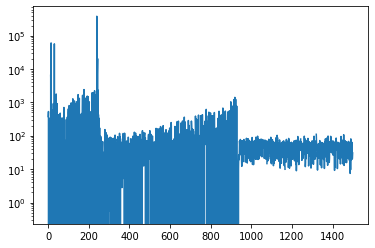

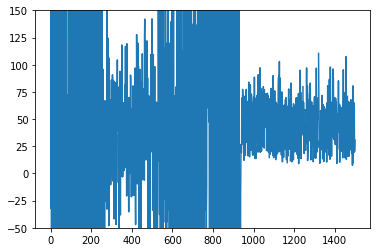


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:37,  1.59s/it]

0 198.83413210511208


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

1 168.24114775657654


  3%|▎         | 3/100 [00:04<02:32,  1.57s/it]

2 167.15408581495285


  4%|▍         | 4/100 [00:06<02:32,  1.59s/it]

3 166.08518102765083


  5%|▌         | 5/100 [00:07<02:30,  1.58s/it]

4 165.70181539654732


  6%|▌         | 6/100 [00:09<02:29,  1.59s/it]

5 165.30436477065086


  7%|▋         | 7/100 [00:11<02:28,  1.59s/it]

6 165.18046563863754


  8%|▊         | 8/100 [00:12<02:26,  1.60s/it]

7 165.0938312113285


  9%|▉         | 9/100 [00:14<02:25,  1.59s/it]

8 164.93244951963425


 10%|█         | 10/100 [00:15<02:22,  1.59s/it]

9 164.9853981435299


 11%|█         | 11/100 [00:17<02:21,  1.59s/it]

10 164.78849440813065


 12%|█▏        | 12/100 [00:19<02:19,  1.59s/it]

11 164.59669288992882


 13%|█▎        | 13/100 [00:20<02:18,  1.59s/it]

12 164.85838916897774


 14%|█▍        | 14/100 [00:22<02:16,  1.59s/it]

13 164.78813469409943


 15%|█▌        | 15/100 [00:23<02:15,  1.59s/it]

14 164.54638266563416


 16%|█▌        | 16/100 [00:25<02:12,  1.58s/it]

15 164.63220250606537


 17%|█▋        | 17/100 [00:26<02:11,  1.58s/it]

16 164.49360930919647


 18%|█▊        | 18/100 [00:28<02:09,  1.58s/it]

17 164.54822754859924


 19%|█▉        | 19/100 [00:30<02:07,  1.58s/it]

18 164.41869667172432


 20%|██        | 20/100 [00:31<02:06,  1.58s/it]

19 164.19448149204254


 21%|██        | 21/100 [00:33<02:04,  1.57s/it]

20 164.40653324127197


 22%|██▏       | 22/100 [00:34<02:02,  1.57s/it]

21 164.2948994934559


 23%|██▎       | 23/100 [00:36<02:02,  1.59s/it]

22 164.16745176911354


 24%|██▍       | 24/100 [00:38<02:00,  1.59s/it]

23 164.0621938109398


 25%|██▌       | 25/100 [00:39<01:59,  1.59s/it]

24 164.11121690273285


 26%|██▌       | 26/100 [00:41<01:57,  1.59s/it]

25 164.15250968933105


 27%|██▋       | 27/100 [00:42<01:56,  1.60s/it]

26 164.11202663183212


 28%|██▊       | 28/100 [00:44<01:55,  1.61s/it]

27 164.12471896409988


 29%|██▉       | 29/100 [00:46<01:54,  1.62s/it]

28 164.21552523970604


 30%|███       | 30/100 [00:47<01:53,  1.61s/it]

29 164.12152257561684


 31%|███       | 31/100 [00:49<01:50,  1.60s/it]

30 164.04827144742012


 32%|███▏      | 32/100 [00:50<01:48,  1.60s/it]

31 163.95905390381813


 33%|███▎      | 33/100 [00:52<01:46,  1.59s/it]

32 164.02326625585556


 34%|███▍      | 34/100 [00:54<01:44,  1.58s/it]

33 164.1894628405571


 35%|███▌      | 35/100 [00:55<01:42,  1.58s/it]

34 163.7902195751667


 36%|███▌      | 36/100 [00:57<01:41,  1.58s/it]

35 164.01690569519997


 37%|███▋      | 37/100 [00:58<01:39,  1.58s/it]

36 163.86685705184937


 38%|███▊      | 38/100 [01:00<01:39,  1.61s/it]

37 163.83067750930786


 39%|███▉      | 39/100 [01:02<01:40,  1.65s/it]

38 164.0036698281765


 40%|████      | 40/100 [01:03<01:39,  1.66s/it]

39 163.87304213643074


 41%|████      | 41/100 [01:05<01:37,  1.65s/it]

40 163.8271630704403


 42%|████▏     | 42/100 [01:07<01:35,  1.64s/it]

41 163.82552993297577


 43%|████▎     | 43/100 [01:08<01:34,  1.65s/it]

42 163.6741545498371


 44%|████▍     | 44/100 [01:10<01:32,  1.65s/it]

43 163.80848667025566


 45%|████▌     | 45/100 [01:12<01:30,  1.64s/it]

44 163.75211960077286


 46%|████▌     | 46/100 [01:13<01:28,  1.63s/it]

45 163.67237481474876


 47%|████▋     | 47/100 [01:15<01:27,  1.66s/it]

46 163.78102323412895


 48%|████▊     | 48/100 [01:17<01:25,  1.65s/it]

47 163.74854657053947


 49%|████▉     | 49/100 [01:18<01:24,  1.65s/it]

48 163.69211041927338


 50%|█████     | 50/100 [01:20<01:22,  1.65s/it]

49 163.69324737787247


 51%|█████     | 51/100 [01:21<01:20,  1.64s/it]

50 163.94129556417465


 52%|█████▏    | 52/100 [01:23<01:18,  1.64s/it]

51 163.7222726047039


 53%|█████▎    | 53/100 [01:25<01:16,  1.64s/it]

52 163.8117574453354


 54%|█████▍    | 54/100 [01:26<01:15,  1.63s/it]

53 163.66593930125237


 55%|█████▌    | 55/100 [01:28<01:13,  1.63s/it]

54 163.59443870186806


 56%|█████▌    | 56/100 [01:30<01:11,  1.63s/it]

55 163.6758216023445


 57%|█████▋    | 57/100 [01:31<01:10,  1.64s/it]

56 163.66823706030846


 58%|█████▊    | 58/100 [01:33<01:08,  1.63s/it]

57 163.65782424807549


 59%|█████▉    | 59/100 [01:35<01:07,  1.64s/it]

58 163.63634851574898


 60%|██████    | 60/100 [01:36<01:06,  1.65s/it]

59 163.72122156620026


 61%|██████    | 61/100 [01:38<01:04,  1.66s/it]

60 163.6073139309883


 62%|██████▏   | 62/100 [01:40<01:03,  1.67s/it]

61 163.5830462872982


 63%|██████▎   | 63/100 [01:41<01:03,  1.71s/it]

62 163.59029135107994


 64%|██████▍   | 64/100 [01:43<01:02,  1.73s/it]

63 163.67812949419022


 65%|██████▌   | 65/100 [01:45<01:00,  1.74s/it]

64 163.60130456089973


 66%|██████▌   | 66/100 [01:47<00:59,  1.74s/it]

65 163.51540884375572


 67%|██████▋   | 67/100 [01:48<00:57,  1.73s/it]

66 163.58598950505257


 68%|██████▊   | 68/100 [01:50<00:55,  1.74s/it]

67 163.55262583494186


 69%|██████▉   | 69/100 [01:52<00:53,  1.74s/it]

68 163.66129302978516


 70%|███████   | 70/100 [01:54<00:51,  1.73s/it]

69 163.74757200479507


 71%|███████   | 71/100 [01:55<00:49,  1.72s/it]

70 163.53497377038002


 72%|███████▏  | 72/100 [01:57<00:48,  1.72s/it]

71 163.53884521126747


 73%|███████▎  | 73/100 [01:59<00:46,  1.71s/it]

72 163.63782104849815


 74%|███████▍  | 74/100 [02:00<00:44,  1.70s/it]

73 163.64796659350395


 75%|███████▌  | 75/100 [02:02<00:42,  1.70s/it]

74 163.4567288160324


 76%|███████▌  | 76/100 [02:04<00:41,  1.72s/it]

75 163.56994631886482


 77%|███████▋  | 77/100 [02:06<00:39,  1.72s/it]

76 163.59782275557518


 78%|███████▊  | 78/100 [02:07<00:37,  1.72s/it]

77 163.53663256764412


 79%|███████▉  | 79/100 [02:09<00:35,  1.70s/it]

78 163.66592234373093


 80%|████████  | 80/100 [02:11<00:34,  1.70s/it]

79 163.50203824043274


 81%|████████  | 81/100 [02:12<00:32,  1.71s/it]

80 163.50736090540886


 82%|████████▏ | 82/100 [02:14<00:30,  1.72s/it]

81 163.5618232190609


 83%|████████▎ | 83/100 [02:16<00:29,  1.72s/it]

82 163.50539562106133


 84%|████████▍ | 84/100 [02:17<00:27,  1.71s/it]

83 163.51525363326073


 85%|████████▌ | 85/100 [02:19<00:25,  1.71s/it]

84 163.55290642380714


 86%|████████▌ | 86/100 [02:21<00:24,  1.72s/it]

85 163.58012226223946


 87%|████████▋ | 87/100 [02:23<00:22,  1.72s/it]

86 163.60942190885544


 88%|████████▊ | 88/100 [02:24<00:20,  1.73s/it]

87 163.407602339983


 89%|████████▉ | 89/100 [02:26<00:18,  1.72s/it]

88 163.60221621394157


 90%|█████████ | 90/100 [02:28<00:16,  1.69s/it]

89 163.42902666330338


 91%|█████████ | 91/100 [02:29<00:14,  1.67s/it]

90 163.5602574646473


 92%|█████████▏| 92/100 [02:31<00:13,  1.65s/it]

91 163.5231736600399


 93%|█████████▎| 93/100 [02:33<00:11,  1.64s/it]

92 163.501302421093


 94%|█████████▍| 94/100 [02:34<00:09,  1.66s/it]

93 163.44341936707497


 95%|█████████▌| 95/100 [02:36<00:08,  1.68s/it]

94 163.55155593156815


 96%|█████████▌| 96/100 [02:38<00:06,  1.70s/it]

95 163.38044118881226


 97%|█████████▋| 97/100 [02:39<00:05,  1.71s/it]

96 163.50572809576988


 98%|█████████▊| 98/100 [02:41<00:03,  1.71s/it]

97 163.43726232647896


 99%|█████████▉| 99/100 [02:43<00:01,  1.71s/it]

98 163.50007358193398


100%|██████████| 100/100 [02:45<00:00,  1.65s/it]

99 163.55120518803596

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07415603846311569	

epoch 9000/10000, policy loss 0.0009309895685873926	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 14.023134231567383best loss model loaded, stored at update # 585


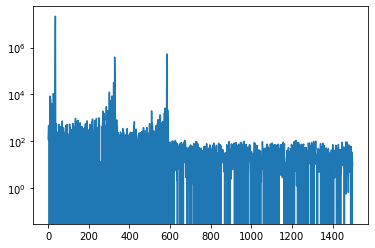

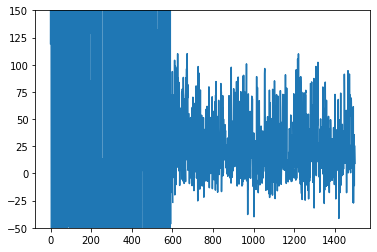


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=2.4409258501315534e-05 and pval_i=0.003451767608618647
0 and 2 are independent with pval_d=8.887540416191093e-08 and pval_i=7.087748627984423e-07
0 and 3 are independent with pval_d=9.936140906518235e-09 and pval_i=2.6772588836306684e-07
0 and 4 are DEPENDENT with pval_d=1.662151464648988e-07 and pval_i=1.0781134814115651e-08
0 and 5 are DEPENDENT with pval_d=1.294869693164694e-07 and pval_i=9.106487611152728e-08
0 and 6 are independent with pval_d=0.00017279686431175166 and pval_i=0.000197354576633519
0 and 7 are DEPENDENT with pval_d=0.0027948015707832397 and pval_i=1.6161530308880265e-06
1 and 2 are DEPENDENT with pval_d=5.194898803685236e-09 and pval_i=3.3552762263172746e-10
1 and 3 are independent with pval_d=6.442720123222309e-09 and pval_i=2.241605691242179e-08
1 and 4 are independent with pval_d=4.413959700298774e-08 and pval_i=2.2149760826837545e-07
1 and 5

  1%|          | 1/100 [00:01<02:40,  1.62s/it]

0 320.53782922029495


  2%|▏         | 2/100 [00:03<02:39,  1.63s/it]

1 297.68790340423584


  3%|▎         | 3/100 [00:04<02:38,  1.63s/it]

2 297.4430710077286


  4%|▍         | 4/100 [00:06<02:36,  1.63s/it]

3 297.24518597126007


  5%|▌         | 5/100 [00:08<02:35,  1.63s/it]

4 297.09680223464966


  6%|▌         | 6/100 [00:09<02:35,  1.65s/it]

5 297.1222979426384


  7%|▋         | 7/100 [00:11<02:33,  1.65s/it]

6 297.0648319721222


  8%|▊         | 8/100 [00:13<02:30,  1.63s/it]

7 296.93233835697174


  9%|▉         | 9/100 [00:14<02:30,  1.65s/it]

8 297.12257730960846


 10%|█         | 10/100 [00:16<02:28,  1.65s/it]

9 296.9879102110863


 11%|█         | 11/100 [00:18<02:26,  1.65s/it]

10 296.8144359588623


 12%|█▏        | 12/100 [00:19<02:25,  1.65s/it]

11 296.7723135948181


 13%|█▎        | 13/100 [00:21<02:22,  1.64s/it]

12 296.8502021431923


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

13 296.773088991642


 15%|█▌        | 15/100 [00:24<02:20,  1.65s/it]

14 296.78451704978943


 16%|█▌        | 16/100 [00:26<02:18,  1.64s/it]

15 296.7064989209175


 17%|█▋        | 17/100 [00:27<02:15,  1.64s/it]

16 296.71895802021027


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 296.6669954061508


 19%|█▉        | 19/100 [00:31<02:11,  1.62s/it]

18 296.7004716396332


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 296.6737292408943


 21%|██        | 21/100 [00:34<02:08,  1.63s/it]

20 296.6535733938217


 22%|██▏       | 22/100 [00:36<02:07,  1.64s/it]

21 296.6509096622467


 23%|██▎       | 23/100 [00:37<02:05,  1.63s/it]

22 296.64257472753525


 24%|██▍       | 24/100 [00:39<02:03,  1.63s/it]

23 296.6320341229439


 25%|██▌       | 25/100 [00:40<02:02,  1.63s/it]

24 296.6969144940376


 26%|██▌       | 26/100 [00:42<01:59,  1.62s/it]

25 296.6003416776657


 27%|██▋       | 27/100 [00:44<01:59,  1.63s/it]

26 296.55930387973785


 28%|██▊       | 28/100 [00:45<01:58,  1.64s/it]

27 296.5692489743233


 29%|██▉       | 29/100 [00:47<01:56,  1.64s/it]

28 296.52644842863083


 30%|███       | 30/100 [00:49<01:54,  1.64s/it]

29 296.61308258771896


 31%|███       | 31/100 [00:50<01:53,  1.65s/it]

30 296.5259081721306


 32%|███▏      | 32/100 [00:52<01:52,  1.65s/it]

31 296.55275428295135


 33%|███▎      | 33/100 [00:54<01:50,  1.64s/it]

32 296.56772315502167


 34%|███▍      | 34/100 [00:55<01:48,  1.65s/it]

33 296.5297828912735


 35%|███▌      | 35/100 [00:57<01:46,  1.64s/it]

34 296.5523013472557


 36%|███▌      | 36/100 [00:58<01:45,  1.64s/it]

35 296.5265799164772


 37%|███▋      | 37/100 [01:00<01:43,  1.64s/it]

36 296.50991600751877


 38%|███▊      | 38/100 [01:02<01:41,  1.64s/it]

37 296.4944844841957


 39%|███▉      | 39/100 [01:03<01:40,  1.64s/it]

38 296.5051860809326


 40%|████      | 40/100 [01:05<01:40,  1.68s/it]

39 296.4646311402321


 41%|████      | 41/100 [01:07<01:38,  1.67s/it]

40 296.53647619485855


 42%|████▏     | 42/100 [01:08<01:36,  1.67s/it]

41 296.52003610134125


 43%|████▎     | 43/100 [01:10<01:34,  1.67s/it]

42 296.4810455441475


 44%|████▍     | 44/100 [01:12<01:33,  1.67s/it]

43 296.507259786129


 45%|████▌     | 45/100 [01:13<01:31,  1.66s/it]

44 296.5186257362366


 46%|████▌     | 46/100 [01:15<01:29,  1.66s/it]

45 296.4942538738251


 47%|████▋     | 47/100 [01:17<01:27,  1.65s/it]

46 296.4920589327812


 48%|████▊     | 48/100 [01:18<01:25,  1.65s/it]

47 296.5089872479439


 49%|████▉     | 49/100 [01:20<01:23,  1.64s/it]

48 296.45270383358


 50%|█████     | 50/100 [01:22<01:21,  1.64s/it]

49 296.47264635562897


 51%|█████     | 51/100 [01:23<01:20,  1.64s/it]

50 296.4411705136299


 52%|█████▏    | 52/100 [01:25<01:18,  1.63s/it]

51 296.38731467723846


 53%|█████▎    | 53/100 [01:27<01:16,  1.63s/it]

52 296.4705771803856


 54%|█████▍    | 54/100 [01:28<01:15,  1.63s/it]

53 296.48161339759827


 55%|█████▌    | 55/100 [01:30<01:13,  1.63s/it]

54 296.44922971725464


 56%|█████▌    | 56/100 [01:31<01:11,  1.62s/it]

55 296.44634824991226


 57%|█████▋    | 57/100 [01:33<01:10,  1.64s/it]

56 296.3922703266144


 58%|█████▊    | 58/100 [01:35<01:08,  1.63s/it]

57 296.4599974155426


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 296.47909224033356


 60%|██████    | 60/100 [01:38<01:05,  1.63s/it]

59 296.4467924237251


 61%|██████    | 61/100 [01:40<01:03,  1.63s/it]

60 296.40255814790726


 62%|██████▏   | 62/100 [01:41<01:02,  1.64s/it]

61 296.4512429833412


 63%|██████▎   | 63/100 [01:43<01:01,  1.65s/it]

62 296.4694998264313


 64%|██████▍   | 64/100 [01:45<00:59,  1.64s/it]

63 296.43357187509537


 65%|██████▌   | 65/100 [01:46<00:57,  1.64s/it]

64 296.44626516103745


 66%|██████▌   | 66/100 [01:48<00:55,  1.64s/it]

65 296.39321970939636


 67%|██████▋   | 67/100 [01:49<00:53,  1.62s/it]

66 296.4447522163391


 68%|██████▊   | 68/100 [01:51<00:51,  1.62s/it]

67 296.3859722018242


 69%|██████▉   | 69/100 [01:53<00:50,  1.62s/it]

68 296.3503763079643


 70%|███████   | 70/100 [01:54<00:48,  1.62s/it]

69 296.4065012931824


 71%|███████   | 71/100 [01:56<00:46,  1.62s/it]

70 296.39767068624496


 72%|███████▏  | 72/100 [01:58<00:45,  1.62s/it]

71 296.4438901543617


 73%|███████▎  | 73/100 [01:59<00:43,  1.63s/it]

72 296.38043266534805


 74%|███████▍  | 74/100 [02:01<00:42,  1.62s/it]

73 296.34684509038925


 75%|███████▌  | 75/100 [02:02<00:40,  1.63s/it]

74 296.3802708387375


 76%|███████▌  | 76/100 [02:04<00:39,  1.63s/it]

75 296.41839730739594


 77%|███████▋  | 77/100 [02:06<00:37,  1.63s/it]

76 296.37285643815994


 78%|███████▊  | 78/100 [02:07<00:35,  1.63s/it]

77 296.3866314291954


 79%|███████▉  | 79/100 [02:09<00:34,  1.65s/it]

78 296.4266759753227


 80%|████████  | 80/100 [02:11<00:32,  1.64s/it]

79 296.39679074287415


 81%|████████  | 81/100 [02:12<00:31,  1.65s/it]

80 296.42598551511765


 82%|████████▏ | 82/100 [02:14<00:29,  1.64s/it]

81 296.4349806904793


 83%|████████▎ | 83/100 [02:16<00:27,  1.65s/it]

82 296.3883003592491


 84%|████████▍ | 84/100 [02:17<00:26,  1.65s/it]

83 296.4228728413582


 85%|████████▌ | 85/100 [02:19<00:24,  1.66s/it]

84 296.4196356534958


 86%|████████▌ | 86/100 [02:21<00:23,  1.65s/it]

85 296.4211867451668


 87%|████████▋ | 87/100 [02:22<00:21,  1.65s/it]

86 296.4069671034813


 88%|████████▊ | 88/100 [02:24<00:19,  1.66s/it]

87 296.34612959623337


 89%|████████▉ | 89/100 [02:25<00:18,  1.65s/it]

88 296.3985323905945


 90%|█████████ | 90/100 [02:27<00:16,  1.64s/it]

89 296.37305051088333


 91%|█████████ | 91/100 [02:29<00:14,  1.62s/it]

90 296.3746649622917


 92%|█████████▏| 92/100 [02:30<00:13,  1.63s/it]

91 296.4002292752266


 93%|█████████▎| 93/100 [02:32<00:11,  1.62s/it]

92 296.299627661705


 94%|█████████▍| 94/100 [02:34<00:09,  1.63s/it]

93 296.3670035600662


 95%|█████████▌| 95/100 [02:35<00:08,  1.63s/it]

94 296.33049404621124


 96%|█████████▌| 96/100 [02:37<00:06,  1.63s/it]

95 296.34250324964523


 97%|█████████▋| 97/100 [02:38<00:04,  1.64s/it]

96 296.3546742796898


 98%|█████████▊| 98/100 [02:40<00:03,  1.63s/it]

97 296.3171139359474


 99%|█████████▉| 99/100 [02:42<00:01,  1.63s/it]

98 296.40170907974243


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

99 296.32966309785843

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07950235903263092	

epoch 9000/10000, policy loss 0.03291148692369461	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 ret

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 352.0451354980469best loss model loaded, stored at update # 266


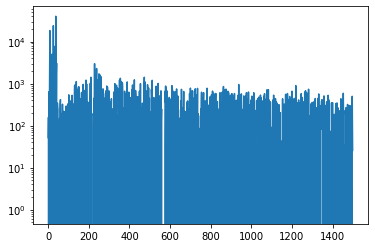

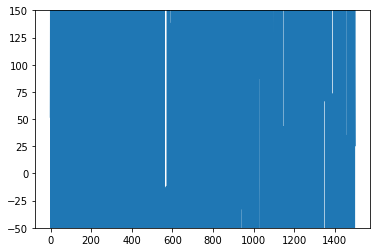


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=1.0055220915590533e-10 and pval_i=4.163429931631199e-10
0 and 2 are independent with pval_d=2.5661172124176453e-10 and pval_i=3.3685168781699014e-09
0 and 3 are independent with pval_d=1.0910856017431372e-12 and pval_i=2.475461507376413e-09
0 and 4 are DEPENDENT with pval_d=4.504981647050538e-09 and pval_i=4.026350302541292e-09
0 and 5 are DEPENDENT with pval_d=1.7923799350573318e-10 and pval_i=5.3953213460984297e-11
0 and 6 are DEPENDENT with pval_d=6.9005103109485005e-06 and pval_i=4.258934773289309e-06
0 and 7 are independent with pval_d=5.444017655454936e-10 and pval_i=2.0421989741466175e-09
1 and 2 are independent with pval_d=6.730513712589666e-11 and pval_i=1.0600476324739682e-09
1 and 3 are independent with pval_d=9.607741402679464e-13 and pval_i=5.4678176868988537e-11
1 and 4 are independent with pval_d=2.7393866866687877e-11 and pval_i=2.8653676092607508e-1

  1%|          | 1/100 [00:01<02:38,  1.60s/it]

0 59.08999279141426


  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

1 52.75457602739334


  3%|▎         | 3/100 [00:04<02:36,  1.61s/it]

2 52.26249700784683


  4%|▍         | 4/100 [00:06<02:35,  1.62s/it]

3 52.04935349524021


  5%|▌         | 5/100 [00:08<02:33,  1.62s/it]

4 51.86869642138481


  6%|▌         | 6/100 [00:09<02:32,  1.62s/it]

5 51.82093073427677


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 51.80452065169811


  8%|▊         | 8/100 [00:12<02:29,  1.63s/it]

7 51.74377483129501


  9%|▉         | 9/100 [00:14<02:28,  1.63s/it]

8 51.65515795350075


 10%|█         | 10/100 [00:16<02:27,  1.63s/it]

9 51.65108086913824


 11%|█         | 11/100 [00:17<02:25,  1.63s/it]

10 51.59926635026932


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 51.52841866016388


 13%|█▎        | 13/100 [00:21<02:21,  1.63s/it]

12 51.572076335549355


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

13 51.50792843103409


 15%|█▌        | 15/100 [00:24<02:17,  1.62s/it]

14 51.48732318729162


 16%|█▌        | 16/100 [00:25<02:15,  1.61s/it]

15 51.45057901740074


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 51.44001557677984


 18%|█▊        | 18/100 [00:29<02:12,  1.62s/it]

17 51.45718878507614


 19%|█▉        | 19/100 [00:30<02:11,  1.63s/it]

18 51.387934401631355


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 51.36176374554634


 21%|██        | 21/100 [00:34<02:08,  1.63s/it]

20 51.39050244539976


 22%|██▏       | 22/100 [00:35<02:06,  1.62s/it]

21 51.36251253634691


 23%|██▎       | 23/100 [00:37<02:04,  1.62s/it]

22 51.34127902984619


 24%|██▍       | 24/100 [00:39<02:04,  1.63s/it]

23 51.34679860621691


 25%|██▌       | 25/100 [00:40<02:03,  1.64s/it]

24 51.3545448705554


 26%|██▌       | 26/100 [00:42<02:01,  1.65s/it]

25 51.32386915385723


 27%|██▋       | 27/100 [00:43<02:00,  1.65s/it]

26 51.29303591698408


 28%|██▊       | 28/100 [00:45<01:58,  1.65s/it]

27 51.33894845098257


 29%|██▉       | 29/100 [00:47<01:57,  1.65s/it]

28 51.33278512209654


 30%|███       | 30/100 [00:48<01:55,  1.64s/it]

29 51.33035594969988


 31%|███       | 31/100 [00:50<01:52,  1.64s/it]

30 51.300233870744705


 32%|███▏      | 32/100 [00:52<01:51,  1.63s/it]

31 51.3100264146924


 33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

32 51.306491144001484


 34%|███▍      | 34/100 [00:55<01:47,  1.63s/it]

33 51.29431779682636


 35%|███▌      | 35/100 [00:56<01:45,  1.62s/it]

34 51.276551492512226


 36%|███▌      | 36/100 [00:58<01:44,  1.63s/it]

35 51.286670088768005


 37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

36 51.27121017128229


 38%|███▊      | 38/100 [01:01<01:40,  1.62s/it]

37 51.282247208058834


 39%|███▉      | 39/100 [01:03<01:39,  1.62s/it]

38 51.28493908792734


 40%|████      | 40/100 [01:05<01:38,  1.63s/it]

39 51.253267250955105


 41%|████      | 41/100 [01:06<01:36,  1.64s/it]

40 51.25528924912214


 42%|████▏     | 42/100 [01:08<01:35,  1.65s/it]

41 51.2785762026906


 43%|████▎     | 43/100 [01:10<01:34,  1.65s/it]

42 51.247460432350636


 44%|████▍     | 44/100 [01:11<01:32,  1.65s/it]

43 51.23727358877659


 45%|████▌     | 45/100 [01:13<01:31,  1.66s/it]

44 51.242128141224384


 46%|████▌     | 46/100 [01:15<01:29,  1.66s/it]

45 51.25983928889036


 47%|████▋     | 47/100 [01:16<01:27,  1.65s/it]

46 51.23686497658491


 48%|████▊     | 48/100 [01:18<01:25,  1.64s/it]

47 51.22522820532322


 49%|████▉     | 49/100 [01:20<01:23,  1.64s/it]

48 51.23194658756256


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 51.24266302585602


 51%|█████     | 51/100 [01:23<01:19,  1.62s/it]

50 51.258842036128044


 52%|█████▏    | 52/100 [01:24<01:17,  1.62s/it]

51 51.25231750309467


 53%|█████▎    | 53/100 [01:26<01:16,  1.63s/it]

52 51.21780413389206


 54%|█████▍    | 54/100 [01:28<01:15,  1.64s/it]

53 51.212064392864704


 55%|█████▌    | 55/100 [01:29<01:13,  1.64s/it]

54 51.197817876935005


 56%|█████▌    | 56/100 [01:31<01:12,  1.64s/it]

55 51.216292537748814


 57%|█████▋    | 57/100 [01:33<01:10,  1.64s/it]

56 51.19702731817961


 58%|█████▊    | 58/100 [01:34<01:10,  1.67s/it]

57 51.24202901870012


 59%|█████▉    | 59/100 [01:36<01:08,  1.68s/it]

58 51.23962187021971


 60%|██████    | 60/100 [01:38<01:06,  1.67s/it]

59 51.24221529811621


 61%|██████    | 61/100 [01:39<01:04,  1.65s/it]

60 51.19614193588495


 62%|██████▏   | 62/100 [01:41<01:02,  1.65s/it]

61 51.197417460381985


 63%|██████▎   | 63/100 [01:43<01:00,  1.63s/it]

62 51.201647490262985


 64%|██████▍   | 64/100 [01:44<00:58,  1.63s/it]

63 51.249474950134754


 65%|██████▌   | 65/100 [01:46<00:57,  1.63s/it]

64 51.196982733905315


 66%|██████▌   | 66/100 [01:47<00:55,  1.63s/it]

65 51.200116485357285


 67%|██████▋   | 67/100 [01:49<00:53,  1.62s/it]

66 51.20736190676689


 68%|██████▊   | 68/100 [01:51<00:51,  1.62s/it]

67 51.1953494399786


 69%|██████▉   | 69/100 [01:52<00:50,  1.62s/it]

68 51.20823044329882


 70%|███████   | 70/100 [01:54<00:48,  1.62s/it]

69 51.215995132923126


 71%|███████   | 71/100 [01:55<00:47,  1.62s/it]

70 51.19940193742514


 72%|███████▏  | 72/100 [01:57<00:45,  1.62s/it]

71 51.19070325046778


 73%|███████▎  | 73/100 [01:59<00:43,  1.63s/it]

72 51.222212463617325


 74%|███████▍  | 74/100 [02:00<00:42,  1.64s/it]

73 51.17606684565544


 75%|███████▌  | 75/100 [02:02<00:41,  1.65s/it]

74 51.201400347054005


 76%|███████▌  | 76/100 [02:04<00:39,  1.65s/it]

75 51.18799538165331


 77%|███████▋  | 77/100 [02:05<00:37,  1.65s/it]

76 51.17313266545534


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 51.18145673722029


 79%|███████▉  | 79/100 [02:09<00:34,  1.64s/it]

78 51.196017660200596


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 51.187557607889175


 81%|████████  | 81/100 [02:12<00:31,  1.64s/it]

80 51.188735119998455


 82%|████████▏ | 82/100 [02:14<00:29,  1.64s/it]

81 51.196067698299885


 83%|████████▎ | 83/100 [02:15<00:27,  1.64s/it]

82 51.18248303234577


 84%|████████▍ | 84/100 [02:17<00:26,  1.63s/it]

83 51.18588764220476


 85%|████████▌ | 85/100 [02:18<00:24,  1.63s/it]

84 51.186493553221226


 86%|████████▌ | 86/100 [02:20<00:22,  1.63s/it]

85 51.19219007343054


 87%|████████▋ | 87/100 [02:22<00:21,  1.63s/it]

86 51.16161609441042


 88%|████████▊ | 88/100 [02:23<00:19,  1.64s/it]

87 51.17840075492859


 89%|████████▉ | 89/100 [02:25<00:18,  1.69s/it]

88 51.188494592905045


 90%|█████████ | 90/100 [02:27<00:16,  1.66s/it]

89 51.18368964642286


 91%|█████████ | 91/100 [02:28<00:14,  1.65s/it]

90 51.176632791757584


 92%|█████████▏| 92/100 [02:30<00:13,  1.65s/it]

91 51.18963526934385


 93%|█████████▎| 93/100 [02:32<00:11,  1.64s/it]

92 51.17590145766735


 94%|█████████▍| 94/100 [02:33<00:09,  1.64s/it]

93 51.15652886778116


 95%|█████████▌| 95/100 [02:35<00:08,  1.63s/it]

94 51.18308913707733


 96%|█████████▌| 96/100 [02:37<00:06,  1.62s/it]

95 51.16572701185942


 97%|█████████▋| 97/100 [02:38<00:04,  1.62s/it]

96 51.19769226014614


 98%|█████████▊| 98/100 [02:40<00:03,  1.61s/it]

97 51.169024519622326


 99%|█████████▉| 99/100 [02:41<00:01,  1.61s/it]

98 51.15082038938999


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

99 51.18311021476984

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07383013516664505	

epoch 9000/10000, policy loss 0.004006363917142153	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 77.08068084716797best loss model loaded, stored at update # 233


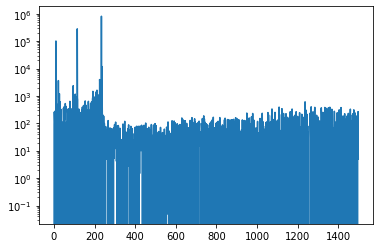

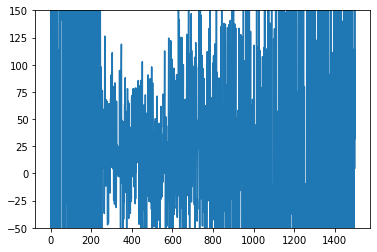


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=1.0088494643046754e-09 and pval_i=7.660707168998773e-08
0 and 2 are independent with pval_d=6.270204044278224e-10 and pval_i=1.4207590310654525e-09
0 and 3 are independent with pval_d=4.056255970254001e-08 and pval_i=5.594740762289098e-07
0 and 4 are independent with pval_d=6.94394002532974e-09 and pval_i=7.2268066055174555e-09
0 and 5 are DEPENDENT with pval_d=8.966455216244502e-07 and pval_i=7.687972110807738e-07
0 and 6 are DEPENDENT with pval_d=1.9481533612393496e-07 and pval_i=3.4902241936558504e-08
0 and 7 are independent with pval_d=1.4345470382499003e-05 and pval_i=0.00010157535939054123
1 and 2 are independent with pval_d=2.519957284900473e-10 and pval_i=2.6684125352538176e-09
1 and 3 are DEPENDENT with pval_d=1.1501959625157492e-06 and pval_i=1.9563070921201374e-09
1 and 4 are DEPENDENT with pval_d=4.163094871222508e-09 and pval_i=5.079441437741546e-12
1 a

  1%|          | 1/100 [00:01<02:41,  1.63s/it]

0 143.01576846837997


  2%|▏         | 2/100 [00:03<02:39,  1.63s/it]

1 135.72037875652313


  3%|▎         | 3/100 [00:04<02:37,  1.62s/it]

2 135.37367033958435


  4%|▍         | 4/100 [00:06<02:36,  1.63s/it]

3 135.20689395070076


  5%|▌         | 5/100 [00:08<02:35,  1.63s/it]

4 135.12001276016235


  6%|▌         | 6/100 [00:09<02:34,  1.64s/it]

5 135.04952773451805


  7%|▋         | 7/100 [00:11<02:33,  1.65s/it]

6 134.97403663396835


  8%|▊         | 8/100 [00:13<02:30,  1.63s/it]

7 134.89876332879066


  9%|▉         | 9/100 [00:14<02:30,  1.65s/it]

8 134.92435809969902


 10%|█         | 10/100 [00:16<02:28,  1.65s/it]

9 134.9858226776123


 11%|█         | 11/100 [00:18<02:26,  1.65s/it]

10 134.90601134300232


 12%|█▏        | 12/100 [00:19<02:25,  1.65s/it]

11 134.86430901288986


 13%|█▎        | 13/100 [00:21<02:23,  1.64s/it]

12 134.87497663497925


 14%|█▍        | 14/100 [00:22<02:21,  1.64s/it]

13 134.88549414277077


 15%|█▌        | 15/100 [00:24<02:20,  1.65s/it]

14 134.8664434850216


 16%|█▌        | 16/100 [00:26<02:18,  1.64s/it]

15 134.80058598518372


 17%|█▋        | 17/100 [00:27<02:16,  1.64s/it]

16 134.80270633101463


 18%|█▊        | 18/100 [00:29<02:14,  1.64s/it]

17 134.8349781036377


 19%|█▉        | 19/100 [00:31<02:13,  1.64s/it]

18 134.81693425774574


 20%|██        | 20/100 [00:32<02:11,  1.65s/it]

19 134.79028967022896


 21%|██        | 21/100 [00:34<02:09,  1.64s/it]

20 134.7881433069706


 22%|██▏       | 22/100 [00:36<02:07,  1.63s/it]

21 134.76657491922379


 23%|██▎       | 23/100 [00:37<02:05,  1.62s/it]

22 134.76094192266464


 24%|██▍       | 24/100 [00:39<02:03,  1.63s/it]

23 134.78331199288368


 25%|██▌       | 25/100 [00:40<02:01,  1.62s/it]

24 134.75113925337791


 26%|██▌       | 26/100 [00:42<02:00,  1.63s/it]

25 134.76532486081123


 27%|██▋       | 27/100 [00:44<01:58,  1.63s/it]

26 134.73116344213486


 28%|██▊       | 28/100 [00:45<01:57,  1.64s/it]

27 134.76815143227577


 29%|██▉       | 29/100 [00:47<01:56,  1.64s/it]

28 134.75610581040382


 30%|███       | 30/100 [00:49<01:54,  1.64s/it]

29 134.7528231739998


 31%|███       | 31/100 [00:50<01:52,  1.63s/it]

30 134.75151416659355


 32%|███▏      | 32/100 [00:52<01:51,  1.63s/it]

31 134.743412733078


 33%|███▎      | 33/100 [00:54<01:49,  1.63s/it]

32 134.76188576221466


 34%|███▍      | 34/100 [00:55<01:47,  1.63s/it]

33 134.71548649668694


 35%|███▌      | 35/100 [00:57<01:47,  1.65s/it]

34 134.7312524318695


 36%|███▌      | 36/100 [00:58<01:45,  1.64s/it]

35 134.71414083242416


 37%|███▋      | 37/100 [01:00<01:43,  1.65s/it]

36 134.72421073913574


 38%|███▊      | 38/100 [01:02<01:42,  1.65s/it]

37 134.708785623312


 39%|███▉      | 39/100 [01:03<01:40,  1.64s/it]

38 134.71659609675407


 40%|████      | 40/100 [01:05<01:38,  1.64s/it]

39 134.68340799212456


 41%|████      | 41/100 [01:07<01:36,  1.64s/it]

40 134.7135663330555


 42%|████▏     | 42/100 [01:08<01:35,  1.64s/it]

41 134.69572886824608


 43%|████▎     | 43/100 [01:10<01:33,  1.64s/it]

42 134.6831352710724


 44%|████▍     | 44/100 [01:12<01:31,  1.64s/it]

43 134.71063086390495


 45%|████▌     | 45/100 [01:13<01:29,  1.64s/it]

44 134.6637540459633


 46%|████▌     | 46/100 [01:15<01:28,  1.63s/it]

45 134.67393735051155


 47%|████▋     | 47/100 [01:17<01:26,  1.64s/it]

46 134.7089013159275


 48%|████▊     | 48/100 [01:18<01:25,  1.64s/it]

47 134.7075510621071


 49%|████▉     | 49/100 [01:20<01:23,  1.63s/it]

48 134.668928951025


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 134.68536496162415


 51%|█████     | 51/100 [01:23<01:20,  1.65s/it]

50 134.68930631875992


 52%|█████▏    | 52/100 [01:25<01:18,  1.64s/it]

51 134.6752112209797


 53%|█████▎    | 53/100 [01:26<01:17,  1.64s/it]

52 134.69799143075943


 54%|█████▍    | 54/100 [01:28<01:15,  1.64s/it]

53 134.68199482560158


 55%|█████▌    | 55/100 [01:30<01:13,  1.64s/it]

54 134.6715984940529


 56%|█████▌    | 56/100 [01:31<01:12,  1.64s/it]

55 134.68249827623367


 57%|█████▋    | 57/100 [01:33<01:10,  1.64s/it]

56 134.68694922327995


 58%|█████▊    | 58/100 [01:35<01:09,  1.64s/it]

57 134.67044678330421


 59%|█████▉    | 59/100 [01:36<01:07,  1.64s/it]

58 134.694869607687


 60%|██████    | 60/100 [01:38<01:05,  1.64s/it]

59 134.68084213137627


 61%|██████    | 61/100 [01:39<01:03,  1.63s/it]

60 134.65984737873077


 62%|██████▏   | 62/100 [01:41<01:01,  1.63s/it]

61 134.67310759425163


 63%|██████▎   | 63/100 [01:43<01:00,  1.64s/it]

62 134.65791246294975


 64%|██████▍   | 64/100 [01:44<00:59,  1.64s/it]

63 134.66868102550507


 65%|██████▌   | 65/100 [01:46<00:57,  1.64s/it]

64 134.70574608445168


 66%|██████▌   | 66/100 [01:48<00:56,  1.65s/it]

65 134.6508521437645


 67%|██████▋   | 67/100 [01:49<00:54,  1.64s/it]

66 134.67153471708298


 68%|██████▊   | 68/100 [01:51<00:52,  1.63s/it]

67 134.6693117916584


 69%|██████▉   | 69/100 [01:53<00:50,  1.63s/it]

68 134.6630818247795


 70%|███████   | 70/100 [01:54<00:49,  1.64s/it]

69 134.67551445960999


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 134.65168806910515


 72%|███████▏  | 72/100 [01:57<00:45,  1.63s/it]

71 134.67888405919075


 73%|███████▎  | 73/100 [01:59<00:44,  1.63s/it]

72 134.6615707576275


 74%|███████▍  | 74/100 [02:01<00:42,  1.65s/it]

73 134.6455979347229


 75%|███████▌  | 75/100 [02:03<00:41,  1.67s/it]

74 134.67523473501205


 76%|███████▌  | 76/100 [02:04<00:40,  1.70s/it]

75 134.6875065267086


 77%|███████▋  | 77/100 [02:06<00:38,  1.68s/it]

76 134.66182428598404


 78%|███████▊  | 78/100 [02:08<00:36,  1.67s/it]

77 134.66647797822952


 79%|███████▉  | 79/100 [02:09<00:34,  1.66s/it]

78 134.67238941788673


 80%|████████  | 80/100 [02:11<00:32,  1.65s/it]

79 134.65285304188728


 81%|████████  | 81/100 [02:12<00:31,  1.65s/it]

80 134.68142518401146


 82%|████████▏ | 82/100 [02:14<00:29,  1.64s/it]

81 134.70563080906868


 83%|████████▎ | 83/100 [02:16<00:27,  1.64s/it]

82 134.6579210460186


 84%|████████▍ | 84/100 [02:17<00:26,  1.65s/it]

83 134.68062180280685


 85%|████████▌ | 85/100 [02:19<00:24,  1.64s/it]

84 134.664375603199


 86%|████████▌ | 86/100 [02:21<00:22,  1.63s/it]

85 134.68853721022606


 87%|████████▋ | 87/100 [02:22<00:21,  1.63s/it]

86 134.646596878767


 88%|████████▊ | 88/100 [02:24<00:19,  1.64s/it]

87 134.63041034340858


 89%|████████▉ | 89/100 [02:26<00:17,  1.63s/it]

88 134.67941439151764


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 134.66355445981026


 91%|█████████ | 91/100 [02:29<00:14,  1.63s/it]

90 134.64238369464874


 92%|█████████▏| 92/100 [02:30<00:12,  1.62s/it]

91 134.64696103334427


 93%|█████████▎| 93/100 [02:32<00:11,  1.62s/it]

92 134.638231664896


 94%|█████████▍| 94/100 [02:34<00:09,  1.62s/it]

93 134.63305085897446


 95%|█████████▌| 95/100 [02:35<00:08,  1.62s/it]

94 134.6586276590824


 96%|█████████▌| 96/100 [02:37<00:06,  1.62s/it]

95 134.6525319814682


 97%|█████████▋| 97/100 [02:38<00:04,  1.61s/it]

96 134.66157564520836


 98%|█████████▊| 98/100 [02:40<00:03,  1.61s/it]

97 134.66894882917404


 99%|█████████▉| 99/100 [02:42<00:01,  1.63s/it]

98 134.66957819461823


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

99 134.62738659977913

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07647829502820969	

epoch 9000/10000, policy loss 0.012916422449052334	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 561.59228515625best loss model loaded, stored at update # 109


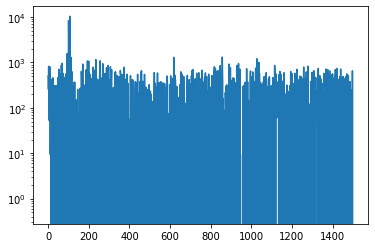

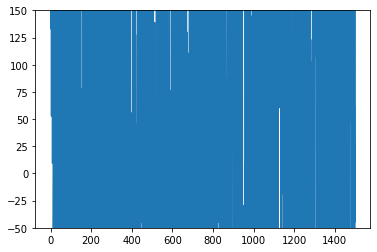


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=8.407112324185163e-09 and pval_i=1.491230675884032e-08
0 and 2 are DEPENDENT with pval_d=1.3318540743436338e-08 and pval_i=5.705910927515638e-10
0 and 3 are independent with pval_d=4.3288319028227925e-11 and pval_i=4.070800335917023e-10
0 and 4 are DEPENDENT with pval_d=4.117746257443076e-10 and pval_i=2.0005053622507512e-10
0 and 5 are DEPENDENT with pval_d=1.783664673793998e-10 and pval_i=1.1837146711191363e-10
0 and 6 are independent with pval_d=3.043089451445426e-10 and pval_i=2.442976680353536e-08
0 and 7 are DEPENDENT with pval_d=2.9141650847825905e-09 and pval_i=7.89868080516732e-10
1 and 2 are DEPENDENT with pval_d=2.3350779247003535e-07 and pval_i=4.05407672073534e-08
1 and 3 are independent with pval_d=8.503165049745069e-11 and pval_i=6.480673739312976e-09
1 and 4 are independent with pval_d=2.402998486957066e-10 and pval_i=1.409012803917424e-09
1 and 5 ar

  1%|          | 1/100 [00:01<02:40,  1.62s/it]

0 100.30047130584717


  2%|▏         | 2/100 [00:03<02:39,  1.63s/it]

1 90.16901022195816


  3%|▎         | 3/100 [00:04<02:41,  1.67s/it]

2 89.87177693843842


  4%|▍         | 4/100 [00:06<02:39,  1.66s/it]

3 89.54108092188835


  5%|▌         | 5/100 [00:08<02:35,  1.64s/it]

4 89.41175392270088


  6%|▌         | 6/100 [00:09<02:33,  1.64s/it]

5 89.3669805675745


  7%|▋         | 7/100 [00:11<02:31,  1.62s/it]

6 89.2914162427187


  8%|▊         | 8/100 [00:13<02:29,  1.62s/it]

7 89.19936303794384


  9%|▉         | 9/100 [00:14<02:27,  1.63s/it]

8 89.21265132725239


 10%|█         | 10/100 [00:16<02:26,  1.62s/it]

9 89.11268278956413


 11%|█         | 11/100 [00:17<02:24,  1.63s/it]

10 89.1074189543724


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 88.99883322417736


 13%|█▎        | 13/100 [00:21<02:21,  1.63s/it]

12 89.09130227565765


 14%|█▍        | 14/100 [00:22<02:20,  1.64s/it]

13 89.00770777463913


 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]

14 89.01239268481731


 16%|█▌        | 16/100 [00:26<02:17,  1.64s/it]

15 89.0092027336359


 17%|█▋        | 17/100 [00:27<02:16,  1.65s/it]

16 88.94655746221542


 18%|█▊        | 18/100 [00:29<02:14,  1.64s/it]

17 88.95924045145512


 19%|█▉        | 19/100 [00:31<02:12,  1.64s/it]

18 88.90393906831741


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 88.90690930187702


 21%|██        | 21/100 [00:34<02:09,  1.63s/it]

20 88.90139099955559


 22%|██▏       | 22/100 [00:35<02:07,  1.64s/it]

21 88.8594200015068


 23%|██▎       | 23/100 [00:37<02:06,  1.64s/it]

22 88.84867879748344


 24%|██▍       | 24/100 [00:39<02:04,  1.64s/it]

23 88.8394750803709


 25%|██▌       | 25/100 [00:40<02:04,  1.66s/it]

24 88.83981578052044


 26%|██▌       | 26/100 [00:42<02:02,  1.65s/it]

25 88.78893512487411


 27%|██▋       | 27/100 [00:44<02:01,  1.66s/it]

26 88.82517166435719


 28%|██▊       | 28/100 [00:45<01:58,  1.64s/it]

27 88.84894335269928


 29%|██▉       | 29/100 [00:47<01:55,  1.63s/it]

28 88.82859586179256


 30%|███       | 30/100 [00:49<01:55,  1.64s/it]

29 88.87208576500416


 31%|███       | 31/100 [00:50<01:52,  1.64s/it]

30 88.77068209648132


 32%|███▏      | 32/100 [00:52<01:51,  1.64s/it]

31 88.79768367111683


 33%|███▎      | 33/100 [00:54<01:49,  1.63s/it]

32 88.77956722676754


 34%|███▍      | 34/100 [00:55<01:48,  1.64s/it]

33 88.77833123505116


 35%|███▌      | 35/100 [00:57<01:46,  1.64s/it]

34 88.76788140833378


 36%|███▌      | 36/100 [00:58<01:44,  1.64s/it]

35 88.76645682752132


 37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

36 88.7319337874651


 38%|███▊      | 38/100 [01:02<01:40,  1.63s/it]

37 88.76663888990879


 39%|███▉      | 39/100 [01:03<01:39,  1.64s/it]

38 88.74802769720554


 40%|████      | 40/100 [01:05<01:38,  1.64s/it]

39 88.74940568208694


 41%|████      | 41/100 [01:07<01:36,  1.64s/it]

40 88.72266557812691


 42%|████▏     | 42/100 [01:08<01:35,  1.65s/it]

41 88.77181032299995


 43%|████▎     | 43/100 [01:10<01:33,  1.65s/it]

42 88.74271818995476


 44%|████▍     | 44/100 [01:12<01:32,  1.65s/it]

43 88.74509146809578


 45%|████▌     | 45/100 [01:13<01:30,  1.64s/it]

44 88.7348952293396


 46%|████▌     | 46/100 [01:15<01:28,  1.63s/it]

45 88.70366524159908


 47%|████▋     | 47/100 [01:17<01:26,  1.64s/it]

46 88.70860394835472


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 88.70198026299477


 49%|████▉     | 49/100 [01:20<01:23,  1.63s/it]

48 88.68335926532745


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 88.69787307083607


 51%|█████     | 51/100 [01:23<01:19,  1.62s/it]

50 88.74869906902313


 52%|█████▏    | 52/100 [01:25<01:18,  1.63s/it]

51 88.73276576399803


 53%|█████▎    | 53/100 [01:26<01:16,  1.63s/it]

52 88.70930080115795


 54%|█████▍    | 54/100 [01:28<01:14,  1.63s/it]

53 88.68768176436424


 55%|█████▌    | 55/100 [01:30<01:13,  1.64s/it]

54 88.67071986198425


 56%|█████▌    | 56/100 [01:31<01:11,  1.63s/it]

55 88.7133880853653


 57%|█████▋    | 57/100 [01:33<01:10,  1.63s/it]

56 88.6674484461546


 58%|█████▊    | 58/100 [01:34<01:08,  1.64s/it]

57 88.70085334777832


 59%|█████▉    | 59/100 [01:36<01:07,  1.63s/it]

58 88.69492207467556


 60%|██████    | 60/100 [01:38<01:05,  1.63s/it]

59 88.67149336636066


 61%|██████    | 61/100 [01:39<01:03,  1.63s/it]

60 88.67949022352695


 62%|██████▏   | 62/100 [01:41<01:01,  1.63s/it]

61 88.66626878082752


 63%|██████▎   | 63/100 [01:43<01:00,  1.63s/it]

62 88.71473777294159


 64%|██████▍   | 64/100 [01:44<00:59,  1.64s/it]

63 88.68362767994404


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 88.68629036843777


 66%|██████▌   | 66/100 [01:48<00:55,  1.64s/it]

65 88.68020594120026


 67%|██████▋   | 67/100 [01:49<00:54,  1.66s/it]

66 88.64441692829132


 68%|██████▊   | 68/100 [01:51<00:53,  1.66s/it]

67 88.69780008494854


 69%|██████▉   | 69/100 [01:53<00:51,  1.66s/it]

68 88.68810470402241


 70%|███████   | 70/100 [01:54<00:49,  1.65s/it]

69 88.65302604436874


 71%|███████   | 71/100 [01:56<00:47,  1.65s/it]

70 88.66304205358028


 72%|███████▏  | 72/100 [01:57<00:46,  1.65s/it]

71 88.64097899198532


 73%|███████▎  | 73/100 [01:59<00:44,  1.64s/it]

72 88.69617438316345


 74%|███████▍  | 74/100 [02:01<00:42,  1.62s/it]

73 88.7072429060936


 75%|███████▌  | 75/100 [02:02<00:40,  1.63s/it]

74 88.65354296565056


 76%|███████▌  | 76/100 [02:04<00:39,  1.64s/it]

75 88.67110988497734


 77%|███████▋  | 77/100 [02:06<00:37,  1.65s/it]

76 88.67812059819698


 78%|███████▊  | 78/100 [02:07<00:36,  1.65s/it]

77 88.62830579280853


 79%|███████▉  | 79/100 [02:09<00:34,  1.64s/it]

78 88.69748817384243


 80%|████████  | 80/100 [02:11<00:32,  1.64s/it]

79 88.65371327102184


 81%|████████  | 81/100 [02:12<00:31,  1.63s/it]

80 88.63474632799625


 82%|████████▏ | 82/100 [02:14<00:29,  1.64s/it]

81 88.69648872315884


 83%|████████▎ | 83/100 [02:15<00:27,  1.64s/it]

82 88.67015308141708


 84%|████████▍ | 84/100 [02:17<00:26,  1.63s/it]

83 88.6333281993866


 85%|████████▌ | 85/100 [02:19<00:24,  1.64s/it]

84 88.67464211583138


 86%|████████▌ | 86/100 [02:20<00:22,  1.62s/it]

85 88.69057694077492


 87%|████████▋ | 87/100 [02:22<00:20,  1.60s/it]

86 88.65489867329597


 88%|████████▊ | 88/100 [02:24<00:19,  1.62s/it]

87 88.65875770151615


 89%|████████▉ | 89/100 [02:25<00:18,  1.64s/it]

88 88.66528041660786


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 88.63511589169502


 91%|█████████ | 91/100 [02:28<00:14,  1.63s/it]

90 88.64610107243061


 92%|█████████▏| 92/100 [02:30<00:12,  1.60s/it]

91 88.66408893465996


 93%|█████████▎| 93/100 [02:32<00:11,  1.59s/it]

92 88.64340862631798


 94%|█████████▍| 94/100 [02:33<00:09,  1.58s/it]

93 88.6508129388094


 95%|█████████▌| 95/100 [02:35<00:07,  1.58s/it]

94 88.66904988884926


 96%|█████████▌| 96/100 [02:36<00:06,  1.59s/it]

95 88.65113374590874


 97%|█████████▋| 97/100 [02:38<00:04,  1.59s/it]

96 88.65362434089184


 98%|█████████▊| 98/100 [02:40<00:03,  1.60s/it]

97 88.64070917665958


 99%|█████████▉| 99/100 [02:41<00:01,  1.60s/it]

98 88.65337005257607


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

99 88.64456306397915

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07939078658819199	

epoch 9000/10000, policy loss 0.003281497163698077	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -276.625244140625best loss model loaded, stored at update # 647


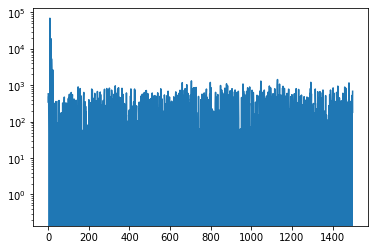

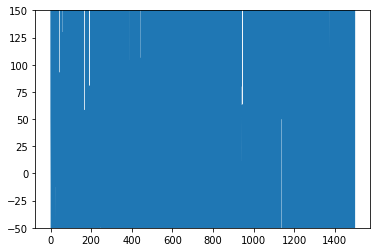


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=1.86772394237858e-09 and pval_i=1.43962214701592e-07
0 and 2 are DEPENDENT with pval_d=1.7063321290252235e-09 and pval_i=8.364542308122807e-11
0 and 3 are DEPENDENT with pval_d=1.1649439391752548e-06 and pval_i=1.494625684495451e-07
0 and 4 are independent with pval_d=1.5540677317308625e-10 and pval_i=2.4999612426838308e-09
0 and 5 are independent with pval_d=9.43398037598476e-09 and pval_i=5.678434388574083e-07
0 and 6 are independent with pval_d=4.148674819688594e-09 and pval_i=5.760844387838548e-09
0 and 7 are independent with pval_d=1.742538925923215e-09 and pval_i=1.1536930649696863e-07
1 and 2 are independent with pval_d=7.507619876130265e-11 and pval_i=5.984190838191227e-10
1 and 3 are independent with pval_d=1.295460078998222e-06 and pval_i=9.893810837398248e-06
1 and 4 are independent with pval_d=1.0790137460079484e-11 and pval_i=1.4611056557607507e-09
1 an

  1%|          | 1/100 [00:01<02:38,  1.60s/it]

0 27.594480887055397


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

1 22.40040624514222


  3%|▎         | 3/100 [00:04<02:34,  1.59s/it]

2 21.42393908277154


  4%|▍         | 4/100 [00:06<02:31,  1.58s/it]

3 20.919631712138653


  5%|▌         | 5/100 [00:07<02:30,  1.59s/it]

4 20.612935934215784


  6%|▌         | 6/100 [00:09<02:30,  1.60s/it]

5 20.517496660351753


  7%|▋         | 7/100 [00:11<02:29,  1.61s/it]

6 20.322697807103395


  8%|▊         | 8/100 [00:12<02:28,  1.62s/it]

7 20.156703796237707


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 20.09625256806612


 10%|█         | 10/100 [00:15<02:23,  1.60s/it]

9 19.95606577768922


 11%|█         | 11/100 [00:17<02:21,  1.58s/it]

10 19.938701670616865


 12%|█▏        | 12/100 [00:19<02:19,  1.59s/it]

11 19.908321142196655


 13%|█▎        | 13/100 [00:20<02:19,  1.60s/it]

12 19.866600442677736


 14%|█▍        | 14/100 [00:22<02:19,  1.62s/it]

13 19.763799093663692


 15%|█▌        | 15/100 [00:24<02:16,  1.61s/it]

14 19.781624108552933


 16%|█▌        | 16/100 [00:25<02:16,  1.62s/it]

15 19.72924866899848


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 19.719498932361603


 18%|█▊        | 18/100 [00:28<02:12,  1.62s/it]

17 19.678341038525105


 19%|█▉        | 19/100 [00:30<02:10,  1.62s/it]

18 19.631488647311926


 20%|██        | 20/100 [00:32<02:09,  1.62s/it]

19 19.6141562089324


 21%|██        | 21/100 [00:33<02:08,  1.63s/it]

20 19.652095582336187


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 19.61889860779047


 23%|██▎       | 23/100 [00:37<02:08,  1.67s/it]

22 19.61465471982956


 24%|██▍       | 24/100 [00:38<02:05,  1.66s/it]

23 19.586316667497158


 25%|██▌       | 25/100 [00:40<02:03,  1.65s/it]

24 19.59059312939644


 26%|██▌       | 26/100 [00:42<02:01,  1.65s/it]

25 19.597424492239952


 27%|██▋       | 27/100 [00:43<02:00,  1.64s/it]

26 19.54213611036539


 28%|██▊       | 28/100 [00:45<01:57,  1.63s/it]

27 19.58455103635788


 29%|██▉       | 29/100 [00:46<01:55,  1.63s/it]

28 19.545273955911398


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 19.548604603856802


 31%|███       | 31/100 [00:50<01:52,  1.62s/it]

30 19.557567361742258


 32%|███▏      | 32/100 [00:51<01:50,  1.62s/it]

31 19.5463807284832


 33%|███▎      | 33/100 [00:53<01:48,  1.62s/it]

32 19.518194515258074


 34%|███▍      | 34/100 [00:55<01:46,  1.61s/it]

33 19.529835782945156


 35%|███▌      | 35/100 [00:56<01:44,  1.61s/it]

34 19.525318630039692


 36%|███▌      | 36/100 [00:58<01:42,  1.60s/it]

35 19.517282776534557


 37%|███▋      | 37/100 [00:59<01:40,  1.60s/it]

36 19.49892858043313


 38%|███▊      | 38/100 [01:01<01:40,  1.62s/it]

37 19.507632546126842


 39%|███▉      | 39/100 [01:03<01:39,  1.63s/it]

38 19.482572991400957


 40%|████      | 40/100 [01:04<01:37,  1.63s/it]

39 19.514139223843813


 41%|████      | 41/100 [01:06<01:36,  1.63s/it]

40 19.51102726906538


 42%|████▏     | 42/100 [01:08<01:34,  1.64s/it]

41 19.447047028690577


 43%|████▎     | 43/100 [01:09<01:32,  1.62s/it]

42 19.481103260070086


 44%|████▍     | 44/100 [01:11<01:32,  1.64s/it]

43 19.453720446676016


 45%|████▌     | 45/100 [01:12<01:30,  1.64s/it]

44 19.462752174586058


 46%|████▌     | 46/100 [01:14<01:29,  1.65s/it]

45 19.450559370219707


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 19.433418326079845


 48%|████▊     | 48/100 [01:17<01:24,  1.63s/it]

47 19.4780367128551


 49%|████▉     | 49/100 [01:19<01:23,  1.63s/it]

48 19.532058712095022


 50%|█████     | 50/100 [01:21<01:21,  1.62s/it]

49 19.403869844973087


 51%|█████     | 51/100 [01:22<01:19,  1.62s/it]

50 19.455914050340652


 52%|█████▏    | 52/100 [01:24<01:17,  1.61s/it]

51 19.425011359155178


 53%|█████▎    | 53/100 [01:25<01:14,  1.59s/it]

52 19.449356593191624


 54%|█████▍    | 54/100 [01:27<01:13,  1.60s/it]

53 19.41442145779729


 55%|█████▌    | 55/100 [01:29<01:12,  1.61s/it]

54 19.472325414419174


 56%|█████▌    | 56/100 [01:30<01:09,  1.59s/it]

55 19.455370903015137


 57%|█████▋    | 57/100 [01:32<01:08,  1.60s/it]

56 20.057661451399326


 58%|█████▊    | 58/100 [01:33<01:07,  1.61s/it]

57 19.454063341021538


 59%|█████▉    | 59/100 [01:35<01:06,  1.61s/it]

58 19.388487808406353


 60%|██████    | 60/100 [01:37<01:04,  1.61s/it]

59 19.419572230428457


 61%|██████    | 61/100 [01:38<01:03,  1.62s/it]

60 19.40317603945732


 62%|██████▏   | 62/100 [01:40<01:01,  1.62s/it]

61 19.384626496583223


 63%|██████▎   | 63/100 [01:41<00:59,  1.60s/it]

62 19.40767016634345


 64%|██████▍   | 64/100 [01:43<00:57,  1.61s/it]

63 19.39862798526883


 65%|██████▌   | 65/100 [01:45<00:56,  1.61s/it]

64 19.42443100735545


 66%|██████▌   | 66/100 [01:46<00:54,  1.61s/it]

65 19.409592114388943


 67%|██████▋   | 67/100 [01:48<00:52,  1.60s/it]

66 19.381059255450964


 68%|██████▊   | 68/100 [01:49<00:51,  1.60s/it]

67 19.382844291627407


 69%|██████▉   | 69/100 [01:51<00:50,  1.62s/it]

68 19.413997650146484


 70%|███████   | 70/100 [01:53<00:48,  1.60s/it]

69 19.38106894120574


 71%|███████   | 71/100 [01:54<00:46,  1.60s/it]

70 19.41499262675643


 72%|███████▏  | 72/100 [01:56<00:44,  1.60s/it]

71 19.382940273731947


 73%|███████▎  | 73/100 [01:57<00:43,  1.61s/it]

72 19.871669359505177


 74%|███████▍  | 74/100 [01:59<00:41,  1.61s/it]

73 19.34671063348651


 75%|███████▌  | 75/100 [02:01<00:40,  1.61s/it]

74 19.357279431074858


 76%|███████▌  | 76/100 [02:02<00:38,  1.61s/it]

75 19.382463969290257


 77%|███████▋  | 77/100 [02:04<00:36,  1.59s/it]

76 19.389658343046904


 78%|███████▊  | 78/100 [02:05<00:35,  1.60s/it]

77 19.399212196469307


 79%|███████▉  | 79/100 [02:07<00:33,  1.60s/it]

78 19.368262998759747


 80%|████████  | 80/100 [02:09<00:31,  1.59s/it]

79 19.39157196506858


 81%|████████  | 81/100 [02:10<00:30,  1.60s/it]

80 19.38740500807762


 82%|████████▏ | 82/100 [02:12<00:28,  1.60s/it]

81 19.377883784472942


 83%|████████▎ | 83/100 [02:13<00:27,  1.59s/it]

82 19.379296768456697


 84%|████████▍ | 84/100 [02:15<00:25,  1.59s/it]

83 19.424443371593952


 85%|████████▌ | 85/100 [02:17<00:23,  1.59s/it]

84 19.35671804100275


 86%|████████▌ | 86/100 [02:18<00:22,  1.59s/it]

85 19.357577331364155


 87%|████████▋ | 87/100 [02:20<00:20,  1.59s/it]

86 19.374408341944218


 88%|████████▊ | 88/100 [02:21<00:19,  1.59s/it]

87 20.042508896440268


 89%|████████▉ | 89/100 [02:23<00:17,  1.59s/it]

88 19.326007265597582


 90%|█████████ | 90/100 [02:25<00:15,  1.60s/it]

89 19.30410223081708


 91%|█████████ | 91/100 [02:26<00:14,  1.59s/it]

90 19.35237829014659


 92%|█████████▏| 92/100 [02:28<00:12,  1.58s/it]

91 19.359252993017435


 93%|█████████▎| 93/100 [02:29<00:11,  1.59s/it]

92 19.316057972609997


 94%|█████████▍| 94/100 [02:31<00:09,  1.61s/it]

93 19.34819584339857


 95%|█████████▌| 95/100 [02:33<00:08,  1.63s/it]

94 19.395522076636553


 96%|█████████▌| 96/100 [02:34<00:06,  1.62s/it]

95 19.3498259447515


 97%|█████████▋| 97/100 [02:36<00:04,  1.62s/it]

96 19.34396531432867


 98%|█████████▊| 98/100 [02:38<00:03,  1.62s/it]

97 20.665606003254652


 99%|█████████▉| 99/100 [02:39<00:01,  1.63s/it]

98 19.371426351368427


100%|██████████| 100/100 [02:41<00:00,  1.61s/it]

99 19.321206115186214

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07401030510663986	

epoch 9000/10000, policy loss 0.0025633997283875942	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -552.5459594726562best loss model loaded, stored at update # 1294


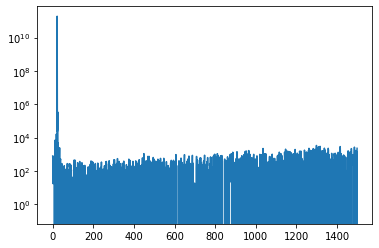

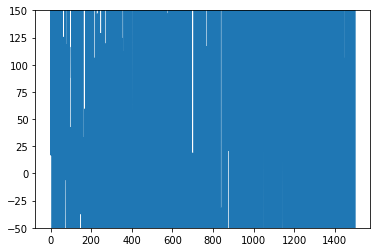


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=0.0002969112461289289 and pval_i=0.5517231374039591
0 and 2 are independent with pval_d=2.0645935651760738e-10 and pval_i=2.7651148137224347e-09
0 and 3 are DEPENDENT with pval_d=7.0153018850664275e-09 and pval_i=7.312658320401092e-10
0 and 4 are independent with pval_d=7.063182626202024e-11 and pval_i=3.6709753989173e-09
0 and 5 are independent with pval_d=3.4961892538763754e-06 and pval_i=1.2411983309058193e-05
0 and 6 are DEPENDENT with pval_d=1.358706016537765e-08 and pval_i=5.800283402617581e-09
0 and 7 are DEPENDENT with pval_d=1.0983503548775563e-05 and pval_i=1.484248898892177e-07
1 and 2 are DEPENDENT with pval_d=2.6244904650904306e-10 and pval_i=6.161898507853745e-12
1 and 3 are DEPENDENT with pval_d=5.312571441748115e-09 and pval_i=5.199359251229373e-11
1 and 4 are independent with pval_d=2.7961768900951867e-09 and pval_i=2.9748942620878302e-08
1 and 5 ar

  1%|          | 1/100 [00:01<02:43,  1.65s/it]

0 171.89093798398972


  2%|▏         | 2/100 [00:03<02:41,  1.65s/it]

1 167.18159592151642


  3%|▎         | 3/100 [00:04<02:37,  1.63s/it]

2 166.96051877737045


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

3 166.73041012883186


  5%|▌         | 5/100 [00:08<02:32,  1.61s/it]

4 166.68631446361542


  6%|▌         | 6/100 [00:09<02:32,  1.62s/it]

5 166.5750805735588


  7%|▋         | 7/100 [00:11<02:29,  1.61s/it]

6 166.54533311724663


  8%|▊         | 8/100 [00:12<02:28,  1.61s/it]

7 166.52040040493011


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 166.4439666569233


 10%|█         | 10/100 [00:16<02:25,  1.62s/it]

9 166.44110396504402


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]

10 166.42292657494545


 12%|█▏        | 12/100 [00:19<02:20,  1.60s/it]

11 166.35217493772507


 13%|█▎        | 13/100 [00:20<02:20,  1.61s/it]

12 166.39828896522522


 14%|█▍        | 14/100 [00:22<02:19,  1.62s/it]

13 166.3595142364502


 15%|█▌        | 15/100 [00:24<02:16,  1.61s/it]

14 166.33840531110764


 16%|█▌        | 16/100 [00:25<02:16,  1.62s/it]

15 166.35015136003494


 17%|█▋        | 17/100 [00:27<02:12,  1.60s/it]

16 166.27414518594742


 18%|█▊        | 18/100 [00:29<02:12,  1.61s/it]

17 166.35304036736488


 19%|█▉        | 19/100 [00:30<02:10,  1.61s/it]

18 166.27839946746826


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 166.28347742557526


 21%|██        | 21/100 [00:33<02:06,  1.61s/it]

20 166.30787977576256


 22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]

21 166.28325912356377


 23%|██▎       | 23/100 [00:37<02:04,  1.61s/it]

22 166.25100454688072


 24%|██▍       | 24/100 [00:38<02:02,  1.61s/it]

23 166.29200127720833


 25%|██▌       | 25/100 [00:40<02:01,  1.62s/it]

24 166.27891954779625


 26%|██▌       | 26/100 [00:41<01:59,  1.61s/it]

25 166.24705836176872


 27%|██▋       | 27/100 [00:43<01:57,  1.62s/it]

26 166.2399301826954


 28%|██▊       | 28/100 [00:45<01:55,  1.60s/it]

27 166.23654717206955


 29%|██▉       | 29/100 [00:46<01:53,  1.60s/it]

28 166.2552668452263


 30%|███       | 30/100 [00:48<01:51,  1.60s/it]

29 166.24020504951477


 31%|███       | 31/100 [00:49<01:49,  1.59s/it]

30 166.23472654819489


 32%|███▏      | 32/100 [00:51<01:48,  1.59s/it]

31 166.22448390722275


 33%|███▎      | 33/100 [00:53<01:46,  1.59s/it]

32 166.25518617033958


 34%|███▍      | 34/100 [00:54<01:44,  1.59s/it]

33 166.21328020095825


 35%|███▌      | 35/100 [00:56<01:43,  1.59s/it]

34 166.22122925519943


 36%|███▌      | 36/100 [00:57<01:42,  1.60s/it]

35 166.21001720428467


 37%|███▋      | 37/100 [00:59<01:41,  1.61s/it]

36 166.18994638323784


 38%|███▊      | 38/100 [01:01<01:39,  1.61s/it]

37 166.1861714720726


 39%|███▉      | 39/100 [01:02<01:38,  1.62s/it]

38 166.210903942585


 40%|████      | 40/100 [01:04<01:38,  1.65s/it]

39 166.17918914556503


 41%|████      | 41/100 [01:06<01:36,  1.63s/it]

40 166.18280586600304


 42%|████▏     | 42/100 [01:07<01:34,  1.63s/it]

41 166.19478887319565


 43%|████▎     | 43/100 [01:09<01:33,  1.64s/it]

42 166.17523503303528


 44%|████▍     | 44/100 [01:11<01:32,  1.66s/it]

43 166.19903963804245


 45%|████▌     | 45/100 [01:12<01:30,  1.64s/it]

44 166.18320393562317


 46%|████▌     | 46/100 [01:14<01:28,  1.64s/it]

45 166.18452689051628


 47%|████▋     | 47/100 [01:15<01:27,  1.64s/it]

46 166.20246517658234


 48%|████▊     | 48/100 [01:17<01:25,  1.64s/it]

47 166.1663323044777


 49%|████▉     | 49/100 [01:19<01:23,  1.64s/it]

48 166.16638460755348


 50%|█████     | 50/100 [01:20<01:21,  1.63s/it]

49 166.20554634928703


 51%|█████     | 51/100 [01:22<01:20,  1.63s/it]

50 166.19283029437065


 52%|█████▏    | 52/100 [01:24<01:17,  1.62s/it]

51 166.1473234295845


 53%|█████▎    | 53/100 [01:25<01:16,  1.63s/it]

52 166.2004483640194


 54%|█████▍    | 54/100 [01:27<01:14,  1.62s/it]

53 166.1677052974701


 55%|█████▌    | 55/100 [01:28<01:12,  1.60s/it]

54 166.1566544175148


 56%|█████▌    | 56/100 [01:30<01:10,  1.61s/it]

55 166.16277328133583


 57%|█████▋    | 57/100 [01:32<01:09,  1.62s/it]

56 166.12890276312828


 58%|█████▊    | 58/100 [01:33<01:08,  1.63s/it]

57 166.1769564449787


 59%|█████▉    | 59/100 [01:35<01:06,  1.63s/it]

58 166.14293786883354


 60%|██████    | 60/100 [01:36<01:04,  1.61s/it]

59 166.18932765722275


 61%|██████    | 61/100 [01:38<01:02,  1.62s/it]

60 166.13553297519684


 62%|██████▏   | 62/100 [01:40<01:01,  1.61s/it]

61 166.13084775209427


 63%|██████▎   | 63/100 [01:41<00:59,  1.61s/it]

62 166.15392524003983


 64%|██████▍   | 64/100 [01:43<00:57,  1.60s/it]

63 166.13122963905334


 65%|██████▌   | 65/100 [01:44<00:55,  1.60s/it]

64 166.16108345985413


 66%|██████▌   | 66/100 [01:46<00:54,  1.60s/it]

65 166.14076906442642


 67%|██████▋   | 67/100 [01:48<00:52,  1.59s/it]

66 166.13480082154274


 68%|██████▊   | 68/100 [01:49<00:50,  1.59s/it]

67 166.16701039671898


 69%|██████▉   | 69/100 [01:51<00:49,  1.59s/it]

68 166.146813839674


 70%|███████   | 70/100 [01:53<00:48,  1.62s/it]

69 166.19217121601105


 71%|███████   | 71/100 [01:54<00:46,  1.61s/it]

70 166.16294139623642


 72%|███████▏  | 72/100 [01:56<00:45,  1.62s/it]

71 166.13053119182587


 73%|███████▎  | 73/100 [01:57<00:43,  1.62s/it]

72 166.15766510367393


 74%|███████▍  | 74/100 [01:59<00:42,  1.62s/it]

73 166.13956373929977


 75%|███████▌  | 75/100 [02:01<00:40,  1.61s/it]

74 166.12281748652458


 76%|███████▌  | 76/100 [02:02<00:38,  1.60s/it]

75 166.16105687618256


 77%|███████▋  | 77/100 [02:04<00:37,  1.62s/it]

76 166.16492387652397


 78%|███████▊  | 78/100 [02:05<00:35,  1.61s/it]

77 166.10749945044518


 79%|███████▉  | 79/100 [02:07<00:33,  1.61s/it]

78 166.1400367617607


 80%|████████  | 80/100 [02:09<00:32,  1.60s/it]

79 166.12689769268036


 81%|████████  | 81/100 [02:10<00:30,  1.60s/it]

80 166.1327869296074


 82%|████████▏ | 82/100 [02:12<00:28,  1.59s/it]

81 166.20473298430443


 83%|████████▎ | 83/100 [02:13<00:27,  1.59s/it]

82 166.102532684803


 84%|████████▍ | 84/100 [02:15<00:25,  1.59s/it]

83 166.11734223365784


 85%|████████▌ | 85/100 [02:17<00:23,  1.59s/it]

84 166.14675995707512


 86%|████████▌ | 86/100 [02:18<00:22,  1.58s/it]

85 166.15640977025032


 87%|████████▋ | 87/100 [02:20<00:20,  1.59s/it]

86 166.1092804670334


 88%|████████▊ | 88/100 [02:21<00:19,  1.59s/it]

87 166.09934759140015


 89%|████████▉ | 89/100 [02:23<00:17,  1.59s/it]

88 166.17055198550224


 90%|█████████ | 90/100 [02:25<00:15,  1.59s/it]

89 166.12265810370445


 91%|█████████ | 91/100 [02:26<00:14,  1.60s/it]

90 166.10679405927658


 92%|█████████▏| 92/100 [02:28<00:12,  1.59s/it]

91 166.1444312632084


 93%|█████████▎| 93/100 [02:29<00:11,  1.59s/it]

92 166.09564492106438


 94%|█████████▍| 94/100 [02:31<00:09,  1.60s/it]

93 166.13966271281242


 95%|█████████▌| 95/100 [02:32<00:07,  1.59s/it]

94 166.13678658008575


 96%|█████████▌| 96/100 [02:34<00:06,  1.59s/it]

95 166.12265181541443


 97%|█████████▋| 97/100 [02:36<00:04,  1.59s/it]

96 166.13786780834198


 98%|█████████▊| 98/100 [02:37<00:03,  1.62s/it]

97 166.10583299398422


 99%|█████████▉| 99/100 [02:39<00:01,  1.64s/it]

98 166.1359803378582


100%|██████████| 100/100 [02:41<00:00,  1.61s/it]

99 166.1319114267826

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.0732003003358841	

epoch 9000/10000, policy loss 0.00837925635278225	
***** test student *****
epoch 0/100 return: 123.0
epoch 1/100 return: 127.0
epoch 2/100 return: 118.0
epoch 3/100 return: 123.0
epoch 4/100 return: 121.0
epoch 5/100 return: 118.0
epoch 6/100 return: 122.0
epoch 7/100 return: 121.0
epoch 8/100 return: 121.0
epoch 9/100 return: 127.0
epoch 10/100 return: 127.0
epoch 11/100 return: 120.0
epoch 12/100 return: 126.0
epoch 13/100 return: 125.0
epoch 14/100 return: 115.0
epoch 15/100 return: 116.0
epoch 16/100 return: 126.0
epoch 17/100 return: 118.0
epoch 18/100 return: 126.0
epoch 19/100 return: 112.0
epoch 20/100 return: 118.0
epoch 21/100 return: 113.0
epoch 22/100 return: 126.0
epoch 23/100 return: 116.0
epoch 24/100 return: 117.0
epoch 25/100 return: 125.0
epoch 26/100 return: 115.0
epoch 27/100 return: 113.0
epoch 28/100 return: 118.0
epoch 29/100 return: 117.0
epoch 30/100 return: 125.0
epoch 31/100 return: 124.0
epoch 32/100 return: 115.0
epoch 33/100 return: 124.0
epoch 34/100 ret

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: 286.9698486328125best loss model loaded, stored at update # 379


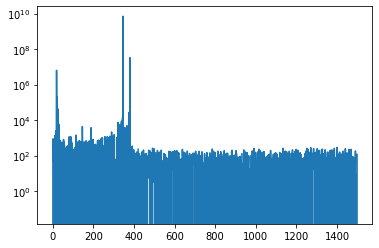

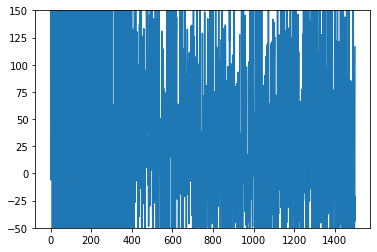


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=1.565877087127322e-10 and pval_i=1.7231406429323084e-09
0 and 2 are DEPENDENT with pval_d=1.0403880817405108e-06 and pval_i=1.4434562681635803e-07
0 and 3 are independent with pval_d=8.37367928513993e-12 and pval_i=6.550782591429427e-10
0 and 4 are independent with pval_d=1.9525443720832223e-07 and pval_i=0.0009627394915838461
0 and 5 are DEPENDENT with pval_d=2.4738894971532163e-08 and pval_i=6.116873706475564e-10
0 and 6 are independent with pval_d=7.066500763105841e-07 and pval_i=1.3321513920325283e-05
0 and 7 are DEPENDENT with pval_d=0.00011957078110501954 and pval_i=6.900509433561289e-08
1 and 2 are DEPENDENT with pval_d=2.1026402323121687e-08 and pval_i=2.4896264175773563e-09
1 and 3 are independent with pval_d=4.741165869057301e-10 and pval_i=1.019057350651162e-08
1 and 4 are independent with pval_d=2.7749634208206856e-10 and pval_i=4.66238883815029e-09
1 an

  1%|          | 1/100 [00:01<02:36,  1.58s/it]

0 232.67721211910248


  2%|▏         | 2/100 [00:03<02:37,  1.61s/it]

1 216.37474238872528


  3%|▎         | 3/100 [00:04<02:36,  1.61s/it]

2 215.31196776032448


  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]

3 214.87338918447495


  5%|▌         | 5/100 [00:08<02:35,  1.64s/it]

4 214.3257439136505


  6%|▌         | 6/100 [00:09<02:32,  1.62s/it]

5 214.39371025562286


  7%|▋         | 7/100 [00:11<02:30,  1.62s/it]

6 214.21955460309982


  8%|▊         | 8/100 [00:12<02:29,  1.62s/it]

7 214.0000572502613


  9%|▉         | 9/100 [00:14<02:29,  1.64s/it]

8 214.07793712615967


 10%|█         | 10/100 [00:16<02:27,  1.64s/it]

9 213.9426241517067


 11%|█         | 11/100 [00:17<02:24,  1.63s/it]

10 213.92733162641525


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 213.76358199119568


 13%|█▎        | 13/100 [00:21<02:19,  1.61s/it]

12 213.8138137459755


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

13 213.77178144454956


 15%|█▌        | 15/100 [00:24<02:16,  1.60s/it]

14 213.72055205702782


 16%|█▌        | 16/100 [00:25<02:14,  1.60s/it]

15 213.65800201892853


 17%|█▋        | 17/100 [00:27<02:12,  1.60s/it]

16 213.64306351542473


 18%|█▊        | 18/100 [00:29<02:13,  1.62s/it]

17 213.62602922320366


 19%|█▉        | 19/100 [00:30<02:12,  1.64s/it]

18 213.53443789482117


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 213.51412439346313


 21%|██        | 21/100 [00:34<02:08,  1.62s/it]

20 213.51986786723137


 22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]

21 213.54201993346214


 23%|██▎       | 23/100 [00:37<02:03,  1.61s/it]

22 213.52416244149208


 24%|██▍       | 24/100 [00:38<02:03,  1.63s/it]

23 213.464909106493


 25%|██▌       | 25/100 [00:40<02:03,  1.64s/it]

24 213.54598945379257


 26%|██▌       | 26/100 [00:42<02:01,  1.64s/it]

25 213.47692972421646


 27%|██▋       | 27/100 [00:43<01:58,  1.62s/it]

26 213.4216360449791


 28%|██▊       | 28/100 [00:45<01:55,  1.60s/it]

27 213.42816784977913


 29%|██▉       | 29/100 [00:46<01:54,  1.62s/it]

28 213.44542184472084


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 213.49021449685097


 31%|███       | 31/100 [00:50<01:51,  1.61s/it]

30 213.37660405039787


 32%|███▏      | 32/100 [00:51<01:48,  1.60s/it]

31 213.40162935853004


 33%|███▎      | 33/100 [00:53<01:49,  1.64s/it]

32 213.45779648423195


 34%|███▍      | 34/100 [00:55<01:48,  1.64s/it]

33 213.39432841539383


 35%|███▌      | 35/100 [00:56<01:46,  1.63s/it]

34 213.36843290925026


 36%|███▌      | 36/100 [00:58<01:44,  1.63s/it]

35 213.36226266622543


 37%|███▋      | 37/100 [00:59<01:42,  1.62s/it]

36 213.38435783982277


 38%|███▊      | 38/100 [01:01<01:39,  1.61s/it]

37 213.30646261572838


 39%|███▉      | 39/100 [01:03<01:38,  1.61s/it]

38 213.3843790590763


 40%|████      | 40/100 [01:04<01:36,  1.61s/it]

39 213.28777253627777


 41%|████      | 41/100 [01:06<01:35,  1.61s/it]

40 213.2892018854618


 42%|████▏     | 42/100 [01:08<01:33,  1.60s/it]

41 213.305071413517


 43%|████▎     | 43/100 [01:09<01:31,  1.61s/it]

42 213.32167369127274


 44%|████▍     | 44/100 [01:11<01:29,  1.60s/it]

43 213.23168125748634


 45%|████▌     | 45/100 [01:12<01:28,  1.61s/it]

44 213.26665279269218


 46%|████▌     | 46/100 [01:14<01:26,  1.59s/it]

45 213.29705142974854


 47%|████▋     | 47/100 [01:16<01:25,  1.61s/it]

46 213.28258568048477


 48%|████▊     | 48/100 [01:17<01:23,  1.61s/it]

47 213.25644448399544


 49%|████▉     | 49/100 [01:19<01:21,  1.60s/it]

48 213.23041766881943


 50%|█████     | 50/100 [01:20<01:21,  1.64s/it]

49 213.29810500144958


 51%|█████     | 51/100 [01:22<01:20,  1.64s/it]

50 213.25957357883453


 52%|█████▏    | 52/100 [01:24<01:19,  1.65s/it]

51 213.2640535235405


 53%|█████▎    | 53/100 [01:25<01:17,  1.66s/it]

52 213.23423087596893


 54%|█████▍    | 54/100 [01:27<01:15,  1.65s/it]

53 213.20728093385696


 55%|█████▌    | 55/100 [01:29<01:13,  1.64s/it]

54 213.2316398024559


 56%|█████▌    | 56/100 [01:30<01:12,  1.64s/it]

55 213.23664373159409


 57%|█████▋    | 57/100 [01:32<01:10,  1.64s/it]

56 213.19647532701492


 58%|█████▊    | 58/100 [01:34<01:08,  1.62s/it]

57 213.25892359018326


 59%|█████▉    | 59/100 [01:35<01:06,  1.61s/it]

58 213.2559231519699


 60%|██████    | 60/100 [01:37<01:04,  1.61s/it]

59 213.23052921891212


 61%|██████    | 61/100 [01:38<01:02,  1.60s/it]

60 213.19285544753075


 62%|██████▏   | 62/100 [01:40<01:00,  1.60s/it]

61 213.21268087625504


 63%|██████▎   | 63/100 [01:41<00:58,  1.59s/it]

62 213.24511188268661


 64%|██████▍   | 64/100 [01:43<00:57,  1.59s/it]

63 213.26735845208168


 65%|██████▌   | 65/100 [01:45<00:55,  1.59s/it]

64 213.18244728446007


 66%|██████▌   | 66/100 [01:46<00:54,  1.59s/it]

65 213.15995153784752


 67%|██████▋   | 67/100 [01:48<00:52,  1.61s/it]

66 213.1576441526413


 68%|██████▊   | 68/100 [01:50<00:51,  1.61s/it]

67 213.19947856664658


 69%|██████▉   | 69/100 [01:51<00:49,  1.60s/it]

68 213.19727638363838


 70%|███████   | 70/100 [01:53<00:48,  1.61s/it]

69 213.18852600455284


 71%|███████   | 71/100 [01:54<00:46,  1.62s/it]

70 213.1717693209648


 72%|███████▏  | 72/100 [01:56<00:44,  1.60s/it]

71 213.18090227246284


 73%|███████▎  | 73/100 [01:58<00:43,  1.61s/it]

72 213.1966353058815


 74%|███████▍  | 74/100 [01:59<00:41,  1.60s/it]

73 213.1520951986313


 75%|███████▌  | 75/100 [02:01<00:39,  1.59s/it]

74 213.15913489460945


 76%|███████▌  | 76/100 [02:02<00:38,  1.60s/it]

75 213.19317397475243


 77%|███████▋  | 77/100 [02:04<00:37,  1.62s/it]

76 213.19090312719345


 78%|███████▊  | 78/100 [02:06<00:36,  1.64s/it]

77 213.14046674966812


 79%|███████▉  | 79/100 [02:07<00:34,  1.64s/it]

78 213.19602185487747


 80%|████████  | 80/100 [02:09<00:33,  1.66s/it]

79 213.15818285942078


 81%|████████  | 81/100 [02:11<00:31,  1.65s/it]

80 213.17146170139313


 82%|████████▏ | 82/100 [02:12<00:29,  1.64s/it]

81 213.21336510777473


 83%|████████▎ | 83/100 [02:14<00:27,  1.64s/it]

82 213.1109763085842


 84%|████████▍ | 84/100 [02:16<00:26,  1.64s/it]

83 213.2136608660221


 85%|████████▌ | 85/100 [02:17<00:24,  1.64s/it]

84 213.23985841870308


 86%|████████▌ | 86/100 [02:19<00:22,  1.64s/it]

85 213.18089786171913


 87%|████████▋ | 87/100 [02:20<00:21,  1.63s/it]

86 213.19527399539948


 88%|████████▊ | 88/100 [02:22<00:19,  1.64s/it]

87 213.09453663229942


 89%|████████▉ | 89/100 [02:24<00:17,  1.62s/it]

88 213.1792704463005


 90%|█████████ | 90/100 [02:25<00:16,  1.62s/it]

89 213.1631656885147


 91%|█████████ | 91/100 [02:27<00:14,  1.61s/it]

90 213.1214805841446


 92%|█████████▏| 92/100 [02:29<00:12,  1.61s/it]

91 213.17422246932983


 93%|█████████▎| 93/100 [02:30<00:11,  1.61s/it]

92 213.10600605607033


 94%|█████████▍| 94/100 [02:32<00:09,  1.62s/it]

93 213.12774854898453


 95%|█████████▌| 95/100 [02:33<00:08,  1.62s/it]

94 213.15878230333328


 96%|█████████▌| 96/100 [02:35<00:06,  1.62s/it]

95 213.1163828074932


 97%|█████████▋| 97/100 [02:37<00:04,  1.60s/it]

96 213.13086339831352


 98%|█████████▊| 98/100 [02:38<00:03,  1.62s/it]

97 213.1216549873352


 99%|█████████▉| 99/100 [02:40<00:01,  1.61s/it]

98 213.14026173949242


100%|██████████| 100/100 [02:41<00:00,  1.62s/it]

99 213.16651743650436

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07562842220067978	

epoch 9000/10000, policy loss 0.00369982048869133	
***** test student *****
epoch 0/100 return: 112.0
epoch 1/100 return: 104.0
epoch 2/100 return: 114.0
epoch 3/100 return: 107.0
epoch 4/100 return: 108.0
epoch 5/100 return: 114.0
epoch 6/100 return: 105.0
epoch 7/100 return: 106.0
epoch 8/100 return: 113.0
epoch 9/100 return: 109.0
epoch 10/100 return: 110.0
epoch 11/100 return: 113.0
epoch 12/100 return: 108.0
epoch 13/100 return: 112.0
epoch 14/100 return: 112.0
epoch 15/100 return: 106.0
epoch 16/100 return: 110.0
epoch 17/100 return: 104.0
epoch 18/100 return: 112.0
epoch 19/100 return: 110.0
epoch 20/100 return: 109.0
epoch 21/100 return: 102.0
epoch 22/100 return: 106.0
epoch 23/100 return: 106.0
epoch 24/100 return: 112.0
epoch 25/100 return: 109.0
epoch 26/100 return: 106.0
epoch 27/100 return: 114.0
epoch 28/100 return: 110.0
epoch 29/100 return: 113.0
epoch 30/100 return: 111.0
epoch 31/100 return: 108.0
epoch 32/100 return: 106.0
epoch 33/100 return: 114.0
epoch 34/100 ret

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
epoch 1400/1500 	loss: -232.85757446289062best loss model loaded, stored at update # 879


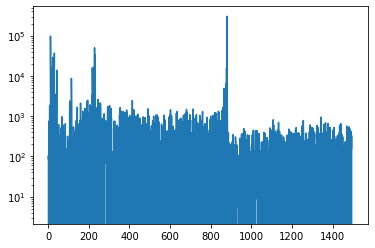

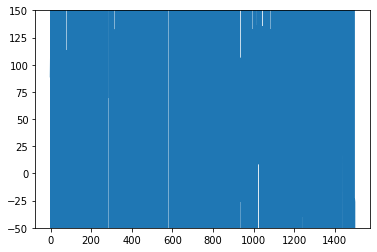


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are independent with pval_d=1.3745641880816607e-09 and pval_i=1.1247917598557433e-08
0 and 2 are independent with pval_d=1.0730075582889464e-10 and pval_i=7.068943519117554e-10
0 and 3 are DEPENDENT with pval_d=5.313357757819679e-08 and pval_i=4.803909165064253e-09
0 and 4 are independent with pval_d=1.8696563571121142e-09 and pval_i=1.5679476277663413e-08
0 and 5 are DEPENDENT with pval_d=4.089274737541154e-09 and pval_i=6.719950531612236e-10
0 and 6 are independent with pval_d=5.723913188709195e-10 and pval_i=1.409288760025061e-08
0 and 7 are independent with pval_d=5.107814628262721e-10 and pval_i=8.657492725558166e-10
1 and 2 are independent with pval_d=2.295106136403648e-12 and pval_i=5.076995229489158e-09
1 and 3 are independent with pval_d=6.088553145529806e-12 and pval_i=1.7210065164535347e-09
1 and 4 are independent with pval_d=2.4346052186485686e-11 and pval_i=2.5802876261996234e-10


  1%|          | 1/100 [00:01<02:39,  1.61s/it]

0 118.30994698405266


  2%|▏         | 2/100 [00:03<02:37,  1.61s/it]

1 97.4934464842081


  3%|▎         | 3/100 [00:04<02:32,  1.58s/it]

2 94.74819500744343


  4%|▍         | 4/100 [00:06<02:32,  1.59s/it]

3 93.33119182288647


  5%|▌         | 5/100 [00:07<02:30,  1.59s/it]

4 92.80878652632236


  6%|▌         | 6/100 [00:09<02:32,  1.62s/it]

5 92.31326933205128


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 92.02385641634464


  8%|▊         | 8/100 [00:12<02:28,  1.62s/it]

7 91.53981275856495


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 91.26700849831104


 10%|█         | 10/100 [00:16<02:26,  1.62s/it]

9 91.10646514594555


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 91.10399879515171


 12%|█▏        | 12/100 [00:19<02:22,  1.62s/it]

11 90.67527931928635


 13%|█▎        | 13/100 [00:20<02:20,  1.61s/it]

12 90.7460608035326


 14%|█▍        | 14/100 [00:22<02:19,  1.63s/it]

13 90.60611306130886


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 90.57451824843884


 16%|█▌        | 16/100 [00:25<02:16,  1.62s/it]

15 90.51106543838978


 17%|█▋        | 17/100 [00:27<02:15,  1.63s/it]

16 90.47705326974392


 18%|█▊        | 18/100 [00:29<02:14,  1.64s/it]

17 90.53171503543854


 19%|█▉        | 19/100 [00:30<02:12,  1.64s/it]

18 90.24064368009567


 20%|██        | 20/100 [00:32<02:11,  1.65s/it]

19 90.20006264746189


 21%|██        | 21/100 [00:34<02:08,  1.62s/it]

20 90.08953180909157


 22%|██▏       | 22/100 [00:35<02:06,  1.62s/it]

21 90.09484615921974


 23%|██▎       | 23/100 [00:37<02:03,  1.61s/it]

22 90.12033495306969


 24%|██▍       | 24/100 [00:38<02:02,  1.62s/it]

23 90.12089167535305


 25%|██▌       | 25/100 [00:40<02:01,  1.62s/it]

24 89.87575402855873


 26%|██▌       | 26/100 [00:42<01:58,  1.61s/it]

25 89.8873605877161


 27%|██▋       | 27/100 [00:43<01:57,  1.61s/it]

26 89.94587822258472


 28%|██▊       | 28/100 [00:45<01:56,  1.62s/it]

27 89.8473619222641


 29%|██▉       | 29/100 [00:46<01:55,  1.63s/it]

28 89.88420194387436


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 89.8363009095192


 31%|███       | 31/100 [00:50<01:53,  1.64s/it]

30 89.76770043373108


 32%|███▏      | 32/100 [00:51<01:51,  1.64s/it]

31 89.85218073427677


 33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

32 89.80369049310684


 34%|███▍      | 34/100 [00:55<01:46,  1.61s/it]

33 89.78113865852356


 35%|███▌      | 35/100 [00:56<01:44,  1.61s/it]

34 89.69034749269485


 36%|███▌      | 36/100 [00:58<01:42,  1.60s/it]

35 89.78296348452568


 37%|███▋      | 37/100 [00:59<01:40,  1.59s/it]

36 89.69533389806747


 38%|███▊      | 38/100 [01:01<01:38,  1.59s/it]

37 89.54285101592541


 39%|███▉      | 39/100 [01:02<01:36,  1.58s/it]

38 89.82489508390427


 40%|████      | 40/100 [01:04<01:34,  1.58s/it]

39 89.5359109044075


 41%|████      | 41/100 [01:06<01:34,  1.60s/it]

40 89.54993140697479


 42%|████▏     | 42/100 [01:07<01:34,  1.63s/it]

41 89.56081123650074


 43%|████▎     | 43/100 [01:09<01:32,  1.63s/it]

42 89.53916493058205


 44%|████▍     | 44/100 [01:11<01:31,  1.63s/it]

43 89.48659671843052


 45%|████▌     | 45/100 [01:12<01:29,  1.63s/it]

44 89.53286492824554


 46%|████▌     | 46/100 [01:14<01:27,  1.62s/it]

45 89.35022714734077


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 89.37244257330894


 48%|████▊     | 48/100 [01:17<01:25,  1.64s/it]

47 89.46302081644535


 49%|████▉     | 49/100 [01:19<01:23,  1.63s/it]

48 89.40145270526409


 50%|█████     | 50/100 [01:20<01:20,  1.61s/it]

49 89.35879629850388


 51%|█████     | 51/100 [01:22<01:19,  1.61s/it]

50 89.55175670981407


 52%|█████▏    | 52/100 [01:24<01:17,  1.62s/it]

51 89.44386798143387


 53%|█████▎    | 53/100 [01:25<01:15,  1.60s/it]

52 89.44633854925632


 54%|█████▍    | 54/100 [01:27<01:13,  1.60s/it]

53 89.29866871237755


 55%|█████▌    | 55/100 [01:28<01:11,  1.60s/it]

54 89.26554287970066


 56%|█████▌    | 56/100 [01:30<01:11,  1.62s/it]

55 89.20933726429939


 57%|█████▋    | 57/100 [01:32<01:09,  1.61s/it]

56 89.29956533014774


 58%|█████▊    | 58/100 [01:33<01:08,  1.62s/it]

57 89.44990186393261


 59%|█████▉    | 59/100 [01:35<01:06,  1.63s/it]

58 89.34916941821575


 60%|██████    | 60/100 [01:37<01:04,  1.62s/it]

59 89.32271802425385


 61%|██████    | 61/100 [01:38<01:02,  1.61s/it]

60 89.26673750579357


 62%|██████▏   | 62/100 [01:40<01:01,  1.63s/it]

61 89.28735540807247


 63%|██████▎   | 63/100 [01:41<01:00,  1.63s/it]

62 89.28554198145866


 64%|██████▍   | 64/100 [01:43<00:58,  1.62s/it]

63 89.32173833251


 65%|██████▌   | 65/100 [01:45<00:56,  1.62s/it]

64 89.18687054514885


 66%|██████▌   | 66/100 [01:46<00:55,  1.63s/it]

65 89.39662212133408


 67%|██████▋   | 67/100 [01:48<00:53,  1.62s/it]

66 89.22167232632637


 68%|██████▊   | 68/100 [01:50<00:51,  1.62s/it]

67 89.16443784534931


 69%|██████▉   | 69/100 [01:51<00:49,  1.60s/it]

68 89.19419232010841


 70%|███████   | 70/100 [01:53<00:48,  1.61s/it]

69 89.2430744022131


 71%|███████   | 71/100 [01:54<00:46,  1.60s/it]

70 89.18051125109196


 72%|███████▏  | 72/100 [01:56<00:45,  1.62s/it]

71 89.2771642357111


 73%|███████▎  | 73/100 [01:58<00:43,  1.60s/it]

72 89.12023977935314


 74%|███████▍  | 74/100 [01:59<00:41,  1.61s/it]

73 89.25315700471401


 75%|███████▌  | 75/100 [02:01<00:40,  1.60s/it]

74 89.18202684819698


 76%|███████▌  | 76/100 [02:02<00:38,  1.61s/it]

75 89.15930016338825


 77%|███████▋  | 77/100 [02:04<00:37,  1.62s/it]

76 89.15822234749794


 78%|███████▊  | 78/100 [02:06<00:35,  1.61s/it]

77 89.15029181540012


 79%|███████▉  | 79/100 [02:07<00:33,  1.62s/it]

78 89.27601809799671


 80%|████████  | 80/100 [02:09<00:32,  1.63s/it]

79 89.07894633710384


 81%|████████  | 81/100 [02:10<00:30,  1.62s/it]

80 89.14475312829018


 82%|████████▏ | 82/100 [02:12<00:29,  1.62s/it]

81 89.3236925303936


 83%|████████▎ | 83/100 [02:14<00:27,  1.60s/it]

82 89.10831955075264


 84%|████████▍ | 84/100 [02:15<00:25,  1.60s/it]

83 89.0792348086834


 85%|████████▌ | 85/100 [02:17<00:23,  1.59s/it]

84 89.17289312183857


 86%|████████▌ | 86/100 [02:18<00:22,  1.60s/it]

85 89.15081283450127


 87%|████████▋ | 87/100 [02:20<00:20,  1.59s/it]

86 88.98177210986614


 88%|████████▊ | 88/100 [02:22<00:19,  1.59s/it]

87 89.12191839516163


 89%|████████▉ | 89/100 [02:23<00:17,  1.59s/it]

88 89.15730802714825


 90%|█████████ | 90/100 [02:25<00:15,  1.59s/it]

89 89.06966261565685


 91%|█████████ | 91/100 [02:26<00:14,  1.60s/it]

90 89.05477386713028


 92%|█████████▏| 92/100 [02:28<00:12,  1.61s/it]

91 89.11268466711044


 93%|█████████▎| 93/100 [02:30<00:11,  1.62s/it]

92 89.10888069868088


 94%|█████████▍| 94/100 [02:31<00:09,  1.62s/it]

93 89.22488459944725


 95%|█████████▌| 95/100 [02:33<00:08,  1.64s/it]

94 89.20216384530067


 96%|█████████▌| 96/100 [02:35<00:06,  1.64s/it]

95 89.06377014517784


 97%|█████████▋| 97/100 [02:36<00:04,  1.65s/it]

96 89.0419529825449


 98%|█████████▊| 98/100 [02:38<00:03,  1.63s/it]

97 89.18579299747944


 99%|█████████▉| 99/100 [02:40<00:01,  1.64s/it]

98 88.94924318790436


100%|██████████| 100/100 [02:41<00:00,  1.62s/it]

99 89.08523431420326

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.09946341067552567	

epoch 9000/10000, policy loss 0.0036039247643202543	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [10]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test_th0_state8_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_neg1 = policy_loss_list

In [14]:
results_trial[2].mean(), results_trial[2].std()

(401.313, 165.38782166975494)

In [17]:
np.array([0.00360392, 0.00369,  0.00837, 0.00256, 0.003281, 0.0129, 0.004006, 0.032911, 0.0009309, 0.0017, ]).std()

0.009145634879991439

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = -1]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

batch size =  50000
Config: {'ALG': 'May1_test1_thneg1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

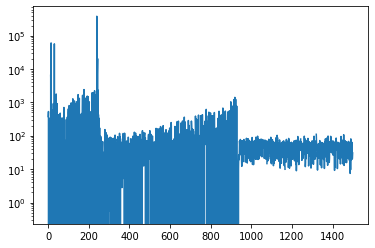

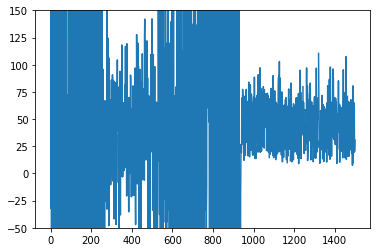


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:36,  1.58s/it]

0 198.83413210511208


  2%|▏         | 2/100 [00:03<02:35,  1.59s/it]

1 168.24114775657654


  3%|▎         | 3/100 [00:04<02:35,  1.61s/it]

2 167.15408581495285


  4%|▍         | 4/100 [00:06<02:33,  1.60s/it]

3 166.08518102765083


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 165.70181539654732


  6%|▌         | 6/100 [00:09<02:32,  1.63s/it]

5 165.30436477065086


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 165.18046563863754


  8%|▊         | 8/100 [00:13<02:30,  1.63s/it]

7 165.0938312113285


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 164.93244951963425


 10%|█         | 10/100 [00:16<02:24,  1.61s/it]

9 164.9853981435299


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 164.78849440813065


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 164.59669288992882


 13%|█▎        | 13/100 [00:21<02:20,  1.62s/it]

12 164.85838916897774


 14%|█▍        | 14/100 [00:22<02:19,  1.62s/it]

13 164.78813469409943


 15%|█▌        | 15/100 [00:24<02:16,  1.61s/it]

14 164.54638266563416


 16%|█▌        | 16/100 [00:25<02:15,  1.61s/it]

15 164.63220250606537


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 164.49360930919647


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 164.54822754859924


 19%|█▉        | 19/100 [00:30<02:13,  1.65s/it]

18 164.41869667172432


 20%|██        | 20/100 [00:32<02:13,  1.66s/it]

19 164.19448149204254


 21%|██        | 21/100 [00:34<02:11,  1.66s/it]

20 164.40653324127197


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 164.2948994934559


 23%|██▎       | 23/100 [00:37<02:05,  1.63s/it]

22 164.16745176911354


 24%|██▍       | 24/100 [00:39<02:05,  1.66s/it]

23 164.0621938109398


 25%|██▌       | 25/100 [00:40<02:05,  1.67s/it]

24 164.11121690273285


 26%|██▌       | 26/100 [00:42<02:01,  1.65s/it]

25 164.15250968933105


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 164.11202663183212


 28%|██▊       | 28/100 [00:45<01:56,  1.62s/it]

27 164.12471896409988


 29%|██▉       | 29/100 [00:47<01:55,  1.62s/it]

28 164.21552523970604


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 164.12152257561684


 31%|███       | 31/100 [00:50<01:51,  1.61s/it]

30 164.04827144742012


 32%|███▏      | 32/100 [00:52<01:50,  1.62s/it]

31 163.95905390381813


 33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

32 164.02326625585556


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 164.1894628405571


 35%|███▌      | 35/100 [00:57<01:46,  1.64s/it]

34 163.7902195751667


 36%|███▌      | 36/100 [00:58<01:45,  1.65s/it]

35 164.01690569519997


 37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

36 163.86685705184937


 38%|███▊      | 38/100 [01:01<01:41,  1.63s/it]

37 163.83067750930786


 39%|███▉      | 39/100 [01:03<01:39,  1.64s/it]

38 164.0036698281765


 40%|████      | 40/100 [01:05<01:37,  1.63s/it]

39 163.87304213643074


 41%|████      | 41/100 [01:06<01:36,  1.63s/it]

40 163.8271630704403


 42%|████▏     | 42/100 [01:08<01:35,  1.64s/it]

41 163.82552993297577


 43%|████▎     | 43/100 [01:10<01:34,  1.66s/it]

42 163.6741545498371


 44%|████▍     | 44/100 [01:11<01:33,  1.67s/it]

43 163.80848667025566


 45%|████▌     | 45/100 [01:13<01:31,  1.66s/it]

44 163.75211960077286


 46%|████▌     | 46/100 [01:15<01:28,  1.64s/it]

45 163.67237481474876


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 163.78102323412895


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 163.74854657053947


 49%|████▉     | 49/100 [01:19<01:22,  1.63s/it]

48 163.69211041927338


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 163.69324737787247


 51%|█████     | 51/100 [01:23<01:19,  1.63s/it]

50 163.94129556417465


 52%|█████▏    | 52/100 [01:24<01:17,  1.62s/it]

51 163.7222726047039


 53%|█████▎    | 53/100 [01:26<01:15,  1.62s/it]

52 163.8117574453354


 54%|█████▍    | 54/100 [01:28<01:15,  1.63s/it]

53 163.66593930125237


 55%|█████▌    | 55/100 [01:29<01:13,  1.63s/it]

54 163.59443870186806


 56%|█████▌    | 56/100 [01:31<01:11,  1.63s/it]

55 163.6758216023445


 57%|█████▋    | 57/100 [01:33<01:10,  1.64s/it]

56 163.66823706030846


 58%|█████▊    | 58/100 [01:34<01:09,  1.65s/it]

57 163.65782424807549


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 163.63634851574898


 60%|██████    | 60/100 [01:37<01:05,  1.63s/it]

59 163.72122156620026


 61%|██████    | 61/100 [01:39<01:03,  1.63s/it]

60 163.6073139309883


 62%|██████▏   | 62/100 [01:41<01:02,  1.65s/it]

61 163.5830462872982


 63%|██████▎   | 63/100 [01:42<01:01,  1.66s/it]

62 163.59029135107994


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 163.67812949419022


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 163.60130456089973


 66%|██████▌   | 66/100 [01:47<00:55,  1.64s/it]

65 163.51540884375572


 67%|██████▋   | 67/100 [01:49<00:54,  1.64s/it]

66 163.58598950505257


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 163.55262583494186


 69%|██████▉   | 69/100 [01:52<00:51,  1.65s/it]

68 163.66129302978516


 70%|███████   | 70/100 [01:54<00:49,  1.64s/it]

69 163.74757200479507


 71%|███████   | 71/100 [01:56<00:47,  1.63s/it]

70 163.53497377038002


 72%|███████▏  | 72/100 [01:57<00:45,  1.61s/it]

71 163.53884521126747


 73%|███████▎  | 73/100 [01:59<00:43,  1.63s/it]

72 163.63782104849815


 74%|███████▍  | 74/100 [02:00<00:42,  1.64s/it]

73 163.64796659350395


 75%|███████▌  | 75/100 [02:02<00:40,  1.64s/it]

74 163.4567288160324


 76%|███████▌  | 76/100 [02:04<00:39,  1.65s/it]

75 163.56994631886482


 77%|███████▋  | 77/100 [02:05<00:37,  1.64s/it]

76 163.59782275557518


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 163.53663256764412


 79%|███████▉  | 79/100 [02:09<00:34,  1.64s/it]

78 163.66592234373093


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 163.50203824043274


 81%|████████  | 81/100 [02:12<00:30,  1.62s/it]

80 163.50736090540886


 82%|████████▏ | 82/100 [02:14<00:30,  1.67s/it]

81 163.5618232190609


 83%|████████▎ | 83/100 [02:15<00:27,  1.64s/it]

82 163.50539562106133


 84%|████████▍ | 84/100 [02:17<00:26,  1.63s/it]

83 163.51525363326073


 85%|████████▌ | 85/100 [02:18<00:24,  1.63s/it]

84 163.55290642380714


 86%|████████▌ | 86/100 [02:20<00:22,  1.64s/it]

85 163.58012226223946


 87%|████████▋ | 87/100 [02:22<00:21,  1.66s/it]

86 163.60942190885544


 88%|████████▊ | 88/100 [02:23<00:19,  1.64s/it]

87 163.407602339983


 89%|████████▉ | 89/100 [02:25<00:17,  1.63s/it]

88 163.60221621394157


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 163.42902666330338


 91%|█████████ | 91/100 [02:28<00:14,  1.61s/it]

90 163.5602574646473


 92%|█████████▏| 92/100 [02:30<00:13,  1.63s/it]

91 163.5231736600399


 93%|█████████▎| 93/100 [02:31<00:11,  1.62s/it]

92 163.501302421093


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 163.44341936707497


 95%|█████████▌| 95/100 [02:35<00:08,  1.63s/it]

94 163.55155593156815


 96%|█████████▌| 96/100 [02:36<00:06,  1.62s/it]

95 163.38044118881226


 97%|█████████▋| 97/100 [02:38<00:04,  1.61s/it]

96 163.50572809576988


 98%|█████████▊| 98/100 [02:40<00:03,  1.61s/it]

97 163.43726232647896


 99%|█████████▉| 99/100 [02:41<00:01,  1.61s/it]

98 163.50007358193398


100%|██████████| 100/100 [02:43<00:00,  1.60s/it]

99 163.55120518803596

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07415603846311569	

epoch 9000/10000, policy loss 0.0009309895685873926	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_thneg1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_neg1 = policy_loss_list

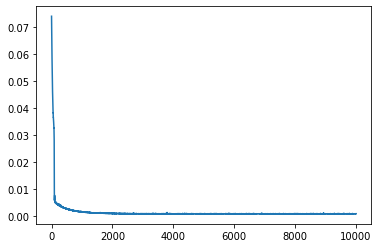

In [ ]:
import matplotlib.pyplot as plt
plt.plot(policy_loss_list_neg1)

In [ ]:
with open('policy_loss_list_neg1.npy', 'wb') as f:
    np.save(f, policy_loss_list_neg1)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 0]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 0

batch size =  50000
Config: {'ALG': 'May1_test1_th0_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 0, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

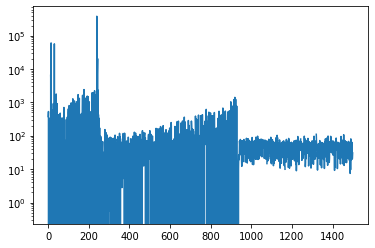

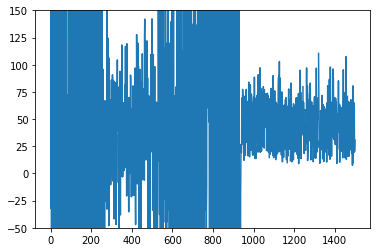


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:50,  1.72s/it]

0 198.83413210511208


  2%|▏         | 2/100 [00:03<02:48,  1.72s/it]

1 168.24114775657654


  3%|▎         | 3/100 [00:05<02:43,  1.69s/it]

2 167.15408581495285


  4%|▍         | 4/100 [00:06<02:40,  1.67s/it]

3 166.08518102765083


  5%|▌         | 5/100 [00:08<02:37,  1.66s/it]

4 165.70181539654732


  6%|▌         | 6/100 [00:09<02:34,  1.64s/it]

5 165.30436477065086


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 165.18046563863754


  8%|▊         | 8/100 [00:13<02:29,  1.62s/it]

7 165.0938312113285


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 164.93244951963425


 10%|█         | 10/100 [00:16<02:26,  1.63s/it]

9 164.9853981435299


 11%|█         | 11/100 [00:17<02:23,  1.62s/it]

10 164.78849440813065


 12%|█▏        | 12/100 [00:19<02:22,  1.62s/it]

11 164.59669288992882


 13%|█▎        | 13/100 [00:21<02:20,  1.61s/it]

12 164.85838916897774


 14%|█▍        | 14/100 [00:22<02:19,  1.63s/it]

13 164.78813469409943


 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]

14 164.54638266563416


 16%|█▌        | 16/100 [00:26<02:18,  1.64s/it]

15 164.63220250606537


 17%|█▋        | 17/100 [00:27<02:15,  1.64s/it]

16 164.49360930919647


 18%|█▊        | 18/100 [00:29<02:13,  1.62s/it]

17 164.54822754859924


 19%|█▉        | 19/100 [00:31<02:12,  1.64s/it]

18 164.41869667172432


 20%|██        | 20/100 [00:32<02:11,  1.64s/it]

19 164.19448149204254


 21%|██        | 21/100 [00:34<02:09,  1.64s/it]

20 164.40653324127197


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 164.2948994934559


 23%|██▎       | 23/100 [00:37<02:04,  1.62s/it]

22 164.16745176911354


 24%|██▍       | 24/100 [00:39<02:03,  1.62s/it]

23 164.0621938109398


 25%|██▌       | 25/100 [00:40<02:02,  1.64s/it]

24 164.11121690273285


 26%|██▌       | 26/100 [00:42<02:01,  1.64s/it]

25 164.15250968933105


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 164.11202663183212


 28%|██▊       | 28/100 [00:45<01:59,  1.66s/it]

27 164.12471896409988


 29%|██▉       | 29/100 [00:47<01:57,  1.65s/it]

28 164.21552523970604


 30%|███       | 30/100 [00:49<01:55,  1.65s/it]

29 164.12152257561684


 31%|███       | 31/100 [00:50<01:55,  1.68s/it]

30 164.04827144742012


 32%|███▏      | 32/100 [00:52<01:54,  1.68s/it]

31 163.95905390381813


 33%|███▎      | 33/100 [00:54<01:51,  1.66s/it]

32 164.02326625585556


 34%|███▍      | 34/100 [00:55<01:49,  1.66s/it]

33 164.1894628405571


 35%|███▌      | 35/100 [00:57<01:47,  1.66s/it]

34 163.7902195751667


 36%|███▌      | 36/100 [00:59<01:45,  1.65s/it]

35 164.01690569519997


 37%|███▋      | 37/100 [01:00<01:43,  1.65s/it]

36 163.86685705184937


 38%|███▊      | 38/100 [01:02<01:42,  1.66s/it]

37 163.83067750930786


 39%|███▉      | 39/100 [01:04<01:41,  1.67s/it]

38 164.0036698281765


 40%|████      | 40/100 [01:05<01:39,  1.65s/it]

39 163.87304213643074


 41%|████      | 41/100 [01:07<01:36,  1.64s/it]

40 163.8271630704403


 42%|████▏     | 42/100 [01:09<01:35,  1.65s/it]

41 163.82552993297577


 43%|████▎     | 43/100 [01:10<01:34,  1.65s/it]

42 163.6741545498371


 44%|████▍     | 44/100 [01:12<01:32,  1.65s/it]

43 163.80848667025566


 45%|████▌     | 45/100 [01:14<01:31,  1.67s/it]

44 163.75211960077286


 46%|████▌     | 46/100 [01:15<01:30,  1.68s/it]

45 163.67237481474876


 47%|████▋     | 47/100 [01:17<01:28,  1.66s/it]

46 163.78102323412895


 48%|████▊     | 48/100 [01:19<01:26,  1.66s/it]

47 163.74854657053947


 49%|████▉     | 49/100 [01:20<01:24,  1.67s/it]

48 163.69211041927338


 50%|█████     | 50/100 [01:22<01:25,  1.71s/it]

49 163.69324737787247


 51%|█████     | 51/100 [01:24<01:22,  1.68s/it]

50 163.94129556417465


 52%|█████▏    | 52/100 [01:25<01:19,  1.65s/it]

51 163.7222726047039


 53%|█████▎    | 53/100 [01:27<01:18,  1.67s/it]

52 163.8117574453354


 54%|█████▍    | 54/100 [01:29<01:15,  1.65s/it]

53 163.66593930125237


 55%|█████▌    | 55/100 [01:30<01:13,  1.63s/it]

54 163.59443870186806


 56%|█████▌    | 56/100 [01:32<01:11,  1.63s/it]

55 163.6758216023445


 57%|█████▋    | 57/100 [01:33<01:10,  1.63s/it]

56 163.66823706030846


 58%|█████▊    | 58/100 [01:35<01:08,  1.62s/it]

57 163.65782424807549


 59%|█████▉    | 59/100 [01:37<01:06,  1.61s/it]

58 163.63634851574898


 60%|██████    | 60/100 [01:38<01:04,  1.61s/it]

59 163.72122156620026


 61%|██████    | 61/100 [01:40<01:02,  1.61s/it]

60 163.6073139309883


 62%|██████▏   | 62/100 [01:41<01:00,  1.61s/it]

61 163.5830462872982


 63%|██████▎   | 63/100 [01:43<01:00,  1.64s/it]

62 163.59029135107994


 64%|██████▍   | 64/100 [01:45<00:58,  1.64s/it]

63 163.67812949419022


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 163.60130456089973


 66%|██████▌   | 66/100 [01:48<00:55,  1.63s/it]

65 163.51540884375572


 67%|██████▋   | 67/100 [01:50<00:53,  1.63s/it]

66 163.58598950505257


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 163.55262583494186


 69%|██████▉   | 69/100 [01:53<00:50,  1.64s/it]

68 163.66129302978516


 70%|███████   | 70/100 [01:55<00:49,  1.64s/it]

69 163.74757200479507


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 163.53497377038002


 72%|███████▏  | 72/100 [01:58<00:45,  1.64s/it]

71 163.53884521126747


 73%|███████▎  | 73/100 [02:00<00:44,  1.66s/it]

72 163.63782104849815


 74%|███████▍  | 74/100 [02:01<00:43,  1.66s/it]

73 163.64796659350395


 75%|███████▌  | 75/100 [02:03<00:41,  1.67s/it]

74 163.4567288160324


 76%|███████▌  | 76/100 [02:05<00:39,  1.66s/it]

75 163.56994631886482


 77%|███████▋  | 77/100 [02:06<00:37,  1.65s/it]

76 163.59782275557518


 78%|███████▊  | 78/100 [02:08<00:35,  1.64s/it]

77 163.53663256764412


 79%|███████▉  | 79/100 [02:09<00:34,  1.63s/it]

78 163.66592234373093


 80%|████████  | 80/100 [02:11<00:32,  1.62s/it]

79 163.50203824043274


 81%|████████  | 81/100 [02:13<00:31,  1.63s/it]

80 163.50736090540886


 82%|████████▏ | 82/100 [02:14<00:29,  1.66s/it]

81 163.5618232190609


 83%|████████▎ | 83/100 [02:16<00:28,  1.68s/it]

82 163.50539562106133


 84%|████████▍ | 84/100 [02:18<00:26,  1.66s/it]

83 163.51525363326073


 85%|████████▌ | 85/100 [02:19<00:24,  1.66s/it]

84 163.55290642380714


 86%|████████▌ | 86/100 [02:21<00:23,  1.66s/it]

85 163.58012226223946


 87%|████████▋ | 87/100 [02:23<00:21,  1.65s/it]

86 163.60942190885544


 88%|████████▊ | 88/100 [02:24<00:19,  1.65s/it]

87 163.407602339983


 89%|████████▉ | 89/100 [02:26<00:18,  1.67s/it]

88 163.60221621394157


 90%|█████████ | 90/100 [02:28<00:16,  1.67s/it]

89 163.42902666330338


 91%|█████████ | 91/100 [02:29<00:14,  1.67s/it]

90 163.5602574646473


 92%|█████████▏| 92/100 [02:31<00:13,  1.68s/it]

91 163.5231736600399


 93%|█████████▎| 93/100 [02:33<00:11,  1.67s/it]

92 163.501302421093


 94%|█████████▍| 94/100 [02:34<00:09,  1.67s/it]

93 163.44341936707497


 95%|█████████▌| 95/100 [02:36<00:08,  1.66s/it]

94 163.55155593156815


 96%|█████████▌| 96/100 [02:38<00:06,  1.65s/it]

95 163.38044118881226


 97%|█████████▋| 97/100 [02:39<00:04,  1.64s/it]

96 163.50572809576988


 98%|█████████▊| 98/100 [02:41<00:03,  1.65s/it]

97 163.43726232647896


 99%|█████████▉| 99/100 [02:43<00:01,  1.66s/it]

98 163.50007358193398


100%|██████████| 100/100 [02:44<00:00,  1.67s/it]

99 163.55120518803596

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07415603846311569	

epoch 9000/10000, policy loss 0.0009309895685873926	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th0_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        #for run_seed in range(config["NUM_REPETITIONS"]):
        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_0 = policy_loss_list

In [ ]:
with open('policy_loss_list_0.npy', 'wb') as f:
    np.save(f, policy_loss_list_0)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 1]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 1

batch size =  50000
Config: {'ALG': 'May1_test1_th1_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

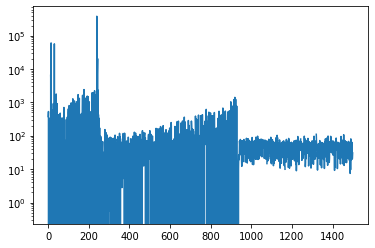

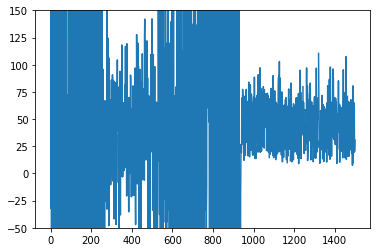


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:38,  1.60s/it]

0 173.48468151688576


  2%|▏         | 2/100 [00:03<02:36,  1.60s/it]

1 147.72795072197914


  3%|▎         | 3/100 [00:04<02:37,  1.62s/it]

2 146.03174817562103


  4%|▍         | 4/100 [00:06<02:35,  1.62s/it]

3 144.6511772274971


  5%|▌         | 5/100 [00:08<02:33,  1.62s/it]

4 144.21071165800095


  6%|▌         | 6/100 [00:09<02:31,  1.61s/it]

5 143.9515316784382


  7%|▋         | 7/100 [00:11<02:29,  1.60s/it]

6 143.39084860682487


  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]

7 143.4088019132614


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 143.22464799880981


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 143.04051831364632


 11%|█         | 11/100 [00:17<02:23,  1.62s/it]

10 142.87224128842354


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 142.85448510944843


 13%|█▎        | 13/100 [00:21<02:22,  1.64s/it]

12 142.95822994410992


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

13 142.8875399082899


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 142.72742387652397


 16%|█▌        | 16/100 [00:26<02:19,  1.66s/it]

15 142.66595178842545


 17%|█▋        | 17/100 [00:27<02:16,  1.64s/it]

16 142.67981265485287


 18%|█▊        | 18/100 [00:29<02:14,  1.64s/it]

17 142.5779106914997


 19%|█▉        | 19/100 [00:30<02:12,  1.63s/it]

18 142.53466802835464


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 142.32784405350685


 21%|██        | 21/100 [00:34<02:07,  1.62s/it]

20 142.48350608348846


 22%|██▏       | 22/100 [00:35<02:09,  1.65s/it]

21 142.3737137913704


 23%|██▎       | 23/100 [00:37<02:11,  1.71s/it]

22 142.2871055006981


 24%|██▍       | 24/100 [00:39<02:07,  1.68s/it]

23 142.2011902332306


 25%|██▌       | 25/100 [00:40<02:04,  1.66s/it]

24 142.29973801970482


 26%|██▌       | 26/100 [00:42<02:02,  1.66s/it]

25 142.2851139307022


 27%|██▋       | 27/100 [00:44<02:00,  1.65s/it]

26 142.15067201852798


 28%|██▊       | 28/100 [00:45<01:58,  1.65s/it]

27 142.26092115044594


 29%|██▉       | 29/100 [00:47<01:57,  1.65s/it]

28 142.19534794986248


 30%|███       | 30/100 [00:49<01:55,  1.65s/it]

29 142.336190238595


 31%|███       | 31/100 [00:50<01:54,  1.66s/it]

30 142.1312538087368


 32%|███▏      | 32/100 [00:52<01:53,  1.67s/it]

31 142.04886239767075


 33%|███▎      | 33/100 [00:54<01:51,  1.66s/it]

32 142.17832800745964


 34%|███▍      | 34/100 [00:55<01:49,  1.66s/it]

33 142.1948668062687


 35%|███▌      | 35/100 [00:57<01:48,  1.66s/it]

34 141.94075210392475


 36%|███▌      | 36/100 [00:59<01:47,  1.68s/it]

35 141.98756954073906


 37%|███▋      | 37/100 [01:00<01:44,  1.65s/it]

36 141.99865865707397


 38%|███▊      | 38/100 [01:02<01:41,  1.64s/it]

37 141.96826921403408


 39%|███▉      | 39/100 [01:03<01:38,  1.62s/it]

38 142.06269040703773


 40%|████      | 40/100 [01:05<01:38,  1.63s/it]

39 142.05796533823013


 41%|████      | 41/100 [01:07<01:35,  1.62s/it]

40 141.90473027527332


 42%|████▏     | 42/100 [01:08<01:35,  1.65s/it]

41 141.9539389014244


 43%|████▎     | 43/100 [01:10<01:33,  1.64s/it]

42 141.91789485514164


 44%|████▍     | 44/100 [01:12<01:30,  1.62s/it]

43 141.97578336298466


 45%|████▌     | 45/100 [01:13<01:29,  1.63s/it]

44 141.95500844717026


 46%|████▌     | 46/100 [01:15<01:27,  1.62s/it]

45 141.83824172616005


 47%|████▋     | 47/100 [01:16<01:25,  1.62s/it]

46 141.87401585280895


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 141.84159994125366


 49%|████▉     | 49/100 [01:20<01:22,  1.62s/it]

48 141.83182632923126


 50%|█████     | 50/100 [01:21<01:20,  1.62s/it]

49 141.8903431892395


 51%|█████     | 51/100 [01:23<01:19,  1.62s/it]

50 141.9774239808321


 52%|█████▏    | 52/100 [01:25<01:17,  1.62s/it]

51 141.92585642635822


 53%|█████▎    | 53/100 [01:26<01:16,  1.62s/it]

52 141.90286365151405


 54%|█████▍    | 54/100 [01:28<01:14,  1.62s/it]

53 141.6527271270752


 55%|█████▌    | 55/100 [01:29<01:13,  1.62s/it]

54 141.72266256809235


 56%|█████▌    | 56/100 [01:31<01:11,  1.62s/it]

55 141.81636033952236


 57%|█████▋    | 57/100 [01:33<01:09,  1.61s/it]

56 141.80914497375488


 58%|█████▊    | 58/100 [01:34<01:07,  1.61s/it]

57 141.81816405057907


 59%|█████▉    | 59/100 [01:36<01:06,  1.61s/it]

58 141.8234865218401


 60%|██████    | 60/100 [01:38<01:04,  1.62s/it]

59 141.7881373167038


 61%|██████    | 61/100 [01:39<01:04,  1.65s/it]

60 141.7731975018978


 62%|██████▏   | 62/100 [01:41<01:03,  1.66s/it]

61 141.8017753660679


 63%|██████▎   | 63/100 [01:43<01:00,  1.64s/it]

62 141.68875554203987


 64%|██████▍   | 64/100 [01:44<00:59,  1.64s/it]

63 141.75734663009644


 65%|██████▌   | 65/100 [01:46<00:57,  1.63s/it]

64 141.89097732305527


 66%|██████▌   | 66/100 [01:48<00:56,  1.65s/it]

65 141.6288635134697


 67%|██████▋   | 67/100 [01:49<00:55,  1.67s/it]

66 141.659940674901


 68%|██████▊   | 68/100 [01:51<00:53,  1.67s/it]

67 141.72191351652145


 69%|██████▉   | 69/100 [01:52<00:51,  1.65s/it]

68 141.76373142004013


 70%|███████   | 70/100 [01:54<00:49,  1.66s/it]

69 141.86020997166634


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 141.68974283337593


 72%|███████▏  | 72/100 [01:57<00:46,  1.66s/it]

71 141.8311131298542


 73%|███████▎  | 73/100 [01:59<00:45,  1.67s/it]

72 141.76859322190285


 74%|███████▍  | 74/100 [02:01<00:43,  1.66s/it]

73 141.74418288469315


 75%|███████▌  | 75/100 [02:02<00:41,  1.65s/it]

74 141.72872853279114


 76%|███████▌  | 76/100 [02:04<00:39,  1.63s/it]

75 141.7132216244936


 77%|███████▋  | 77/100 [02:06<00:37,  1.62s/it]

76 141.65201944112778


 78%|███████▊  | 78/100 [02:07<00:35,  1.63s/it]

77 141.69405549764633


 79%|███████▉  | 79/100 [02:09<00:34,  1.62s/it]

78 141.75324311852455


 80%|████████  | 80/100 [02:11<00:32,  1.65s/it]

79 141.70046338438988


 81%|████████  | 81/100 [02:12<00:31,  1.65s/it]

80 141.55046227574348


 82%|████████▏ | 82/100 [02:14<00:29,  1.63s/it]

81 141.77949894964695


 83%|████████▎ | 83/100 [02:15<00:27,  1.63s/it]

82 141.69786716997623


 84%|████████▍ | 84/100 [02:17<00:26,  1.64s/it]

83 141.73595371842384


 85%|████████▌ | 85/100 [02:19<00:24,  1.64s/it]

84 141.67204120755196


 86%|████████▌ | 86/100 [02:20<00:22,  1.64s/it]

85 141.70084902644157


 87%|████████▋ | 87/100 [02:22<00:21,  1.66s/it]

86 141.7158525288105


 88%|████████▊ | 88/100 [02:24<00:19,  1.64s/it]

87 141.6074246764183


 89%|████████▉ | 89/100 [02:25<00:17,  1.64s/it]

88 141.6108176857233


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 141.6674730181694


 91%|█████████ | 91/100 [02:29<00:14,  1.63s/it]

90 141.7377314865589


 92%|█████████▏| 92/100 [02:30<00:13,  1.63s/it]

91 141.60641238093376


 93%|█████████▎| 93/100 [02:32<00:11,  1.64s/it]

92 141.66148880124092


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 141.55813911557198


 95%|█████████▌| 95/100 [02:35<00:08,  1.63s/it]

94 141.65882486104965


 96%|█████████▌| 96/100 [02:37<00:06,  1.62s/it]

95 141.46812435984612


 97%|█████████▋| 97/100 [02:38<00:04,  1.62s/it]

96 141.68223389983177


 98%|█████████▊| 98/100 [02:40<00:03,  1.63s/it]

97 141.5583133995533


 99%|█████████▉| 99/100 [02:42<00:01,  1.63s/it]

98 141.57174889743328


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

99 141.65230774879456

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.073660708963871	

epoch 9000/10000, policy loss 0.0010546579724177718	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th1_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_1 = policy_loss_list

In [ ]:
with open('policy_loss_list_1.npy', 'wb') as f:
    np.save(f, policy_loss_list_1)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 2]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 2

batch size =  50000
Config: {'ALG': 'May1_test1_th2_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 2, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

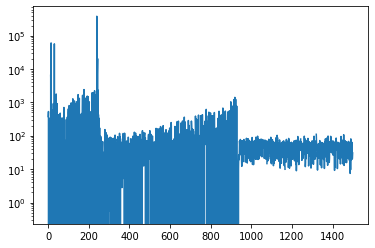

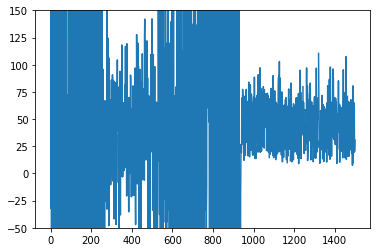


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:42,  1.65s/it]

0 223.2892910838127


  2%|▏         | 2/100 [00:03<02:41,  1.65s/it]

1 190.86424526572227


  3%|▎         | 3/100 [00:04<02:40,  1.66s/it]

2 189.83276018500328


  4%|▍         | 4/100 [00:06<02:37,  1.65s/it]

3 188.45459845662117


  5%|▌         | 5/100 [00:08<02:35,  1.64s/it]

4 187.85277324914932


  6%|▌         | 6/100 [00:09<02:33,  1.63s/it]

5 187.7192989885807


  7%|▋         | 7/100 [00:11<02:31,  1.63s/it]

6 187.34361284971237


  8%|▊         | 8/100 [00:13<02:28,  1.62s/it]

7 187.30750381946564


  9%|▉         | 9/100 [00:14<02:26,  1.61s/it]

8 186.8571950495243


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 187.09012207388878


 11%|█         | 11/100 [00:17<02:24,  1.63s/it]

10 186.63316264748573


 12%|█▏        | 12/100 [00:19<02:23,  1.63s/it]

11 186.71074962615967


 13%|█▎        | 13/100 [00:21<02:23,  1.65s/it]

12 186.7717032134533


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

13 186.7928744852543


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 186.49444988369942


 16%|█▌        | 16/100 [00:26<02:16,  1.62s/it]

15 186.56471702456474


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 186.51241973042488


 18%|█▊        | 18/100 [00:29<02:11,  1.61s/it]

17 186.40492498874664


 19%|█▉        | 19/100 [00:30<02:11,  1.62s/it]

18 186.3739876449108


 20%|██        | 20/100 [00:32<02:11,  1.65s/it]

19 186.13015151023865


 21%|██        | 21/100 [00:34<02:10,  1.65s/it]

20 186.4420903623104


 22%|██▏       | 22/100 [00:35<02:08,  1.65s/it]

21 186.01797914505005


 23%|██▎       | 23/100 [00:37<02:06,  1.64s/it]

22 186.1226080954075


 24%|██▍       | 24/100 [00:39<02:04,  1.64s/it]

23 186.00765866041183


 25%|██▌       | 25/100 [00:40<02:03,  1.64s/it]

24 185.90693926811218


 26%|██▌       | 26/100 [00:42<02:01,  1.65s/it]

25 186.01365131139755


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 185.87429150938988


 28%|██▊       | 28/100 [00:45<01:58,  1.64s/it]

27 185.91071313619614


 29%|██▉       | 29/100 [00:47<01:56,  1.64s/it]

28 185.89232182502747


 30%|███       | 30/100 [00:49<01:54,  1.64s/it]

29 186.1568884253502


 31%|███       | 31/100 [00:50<01:52,  1.64s/it]

30 185.88049280643463


 32%|███▏      | 32/100 [00:52<01:52,  1.65s/it]

31 185.7849758565426


 33%|███▎      | 33/100 [00:53<01:50,  1.65s/it]

32 185.96425804495811


 34%|███▍      | 34/100 [00:55<01:48,  1.64s/it]

33 185.98745784163475


 35%|███▌      | 35/100 [00:57<01:45,  1.62s/it]

34 185.72625583410263


 36%|███▌      | 36/100 [00:58<01:44,  1.63s/it]

35 185.77708917856216


 37%|███▋      | 37/100 [01:00<01:42,  1.63s/it]

36 185.8945066332817


 38%|███▊      | 38/100 [01:02<01:40,  1.62s/it]

37 185.63016599416733


 39%|███▉      | 39/100 [01:03<01:38,  1.62s/it]

38 185.92640191316605


 40%|████      | 40/100 [01:05<01:38,  1.65s/it]

39 185.7859444618225


 41%|████      | 41/100 [01:07<01:37,  1.65s/it]

40 185.65180572867393


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 185.64221921563148


 43%|████▎     | 43/100 [01:10<01:33,  1.63s/it]

42 185.5505010187626


 44%|████▍     | 44/100 [01:11<01:31,  1.64s/it]

43 185.6212317943573


 45%|████▌     | 45/100 [01:13<01:29,  1.63s/it]

44 185.64851582050323


 46%|████▌     | 46/100 [01:15<01:28,  1.63s/it]

45 185.57081761956215


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 185.48350685834885


 48%|████▊     | 48/100 [01:18<01:24,  1.62s/it]

47 185.5927678644657


 49%|████▉     | 49/100 [01:20<01:22,  1.62s/it]

48 185.6034722328186


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 185.54561886191368


 51%|█████     | 51/100 [01:23<01:20,  1.64s/it]

50 185.7311596274376


 52%|█████▏    | 52/100 [01:24<01:18,  1.64s/it]

51 185.6763395667076


 53%|█████▎    | 53/100 [01:26<01:16,  1.63s/it]

52 185.55066591501236


 54%|█████▍    | 54/100 [01:28<01:14,  1.62s/it]

53 185.34095266461372


 55%|█████▌    | 55/100 [01:29<01:12,  1.62s/it]

54 185.55099207162857


 56%|█████▌    | 56/100 [01:31<01:10,  1.61s/it]

55 185.47304672002792


 57%|█████▋    | 57/100 [01:32<01:09,  1.61s/it]

56 185.29896929860115


 58%|█████▊    | 58/100 [01:34<01:08,  1.63s/it]

57 185.5480798780918


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 185.42377680540085


 60%|██████    | 60/100 [01:37<01:05,  1.64s/it]

59 185.4587526023388


 61%|██████    | 61/100 [01:39<01:03,  1.63s/it]

60 185.31228232383728


 62%|██████▏   | 62/100 [01:41<01:02,  1.64s/it]

61 185.43431475758553


 63%|██████▎   | 63/100 [01:42<01:00,  1.64s/it]

62 185.3770859837532


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 185.36181235313416


 65%|██████▌   | 65/100 [01:46<00:58,  1.66s/it]

64 185.4603129029274


 66%|██████▌   | 66/100 [01:47<00:56,  1.66s/it]

65 185.07617008686066


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 185.39790657162666


 68%|██████▊   | 68/100 [01:51<00:52,  1.64s/it]

67 185.27060124278069


 69%|██████▉   | 69/100 [01:52<00:50,  1.63s/it]

68 185.31933906674385


 70%|███████   | 70/100 [01:54<00:49,  1.65s/it]

69 185.4543222784996


 71%|███████   | 71/100 [01:56<00:47,  1.64s/it]

70 185.37445494532585


 72%|███████▏  | 72/100 [01:57<00:45,  1.63s/it]

71 185.4899162054062


 73%|███████▎  | 73/100 [01:59<00:43,  1.62s/it]

72 185.4009444117546


 74%|███████▍  | 74/100 [02:00<00:41,  1.61s/it]

73 185.11696791648865


 75%|███████▌  | 75/100 [02:02<00:40,  1.61s/it]

74 185.41752728819847


 76%|███████▌  | 76/100 [02:04<00:39,  1.63s/it]

75 185.36312049627304


 77%|███████▋  | 77/100 [02:05<00:36,  1.61s/it]

76 185.33598411083221


 78%|███████▊  | 78/100 [02:07<00:35,  1.61s/it]

77 185.26896691322327


 79%|███████▉  | 79/100 [02:08<00:33,  1.60s/it]

78 185.46326300501823


 80%|████████  | 80/100 [02:10<00:32,  1.60s/it]

79 185.32718542218208


 81%|████████  | 81/100 [02:12<00:30,  1.59s/it]

80 185.1139039993286


 82%|████████▏ | 82/100 [02:13<00:28,  1.60s/it]

81 185.49988582730293


 83%|████████▎ | 83/100 [02:15<00:27,  1.60s/it]

82 185.17612195014954


 84%|████████▍ | 84/100 [02:16<00:25,  1.62s/it]

83 185.19824868440628


 85%|████████▌ | 85/100 [02:18<00:24,  1.61s/it]

84 185.30785992741585


 86%|████████▌ | 86/100 [02:20<00:22,  1.60s/it]

85 185.16383001208305


 87%|████████▋ | 87/100 [02:21<00:20,  1.61s/it]

86 185.29975670576096


 88%|████████▊ | 88/100 [02:23<00:19,  1.64s/it]

87 185.16308107972145


 89%|████████▉ | 89/100 [02:25<00:18,  1.65s/it]

88 185.33415803313255


 90%|█████████ | 90/100 [02:26<00:16,  1.64s/it]

89 185.27692666649818


 91%|█████████ | 91/100 [02:28<00:14,  1.65s/it]

90 185.21141001582146


 92%|█████████▏| 92/100 [02:29<00:13,  1.63s/it]

91 185.26757860183716


 93%|█████████▎| 93/100 [02:31<00:11,  1.64s/it]

92 185.17595487833023


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 185.33630123734474


 95%|█████████▌| 95/100 [02:34<00:08,  1.65s/it]

94 185.17711699008942


 96%|█████████▌| 96/100 [02:36<00:06,  1.64s/it]

95 184.93442958593369


 97%|█████████▋| 97/100 [02:38<00:04,  1.63s/it]

96 185.20353704690933


 98%|█████████▊| 98/100 [02:39<00:03,  1.62s/it]

97 185.35120877623558


 99%|█████████▉| 99/100 [02:41<00:01,  1.62s/it]

98 185.07706689834595


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

99 185.36947363615036

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07309768348932266	

epoch 9000/10000, policy loss 0.0011201589368283749	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 r

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th2_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_2 = policy_loss_list

In [ ]:
with open('policy_loss_list_2.npy', 'wb') as f:
    np.save(f, policy_loss_list_2)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 3]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 3

batch size =  50000
Config: {'ALG': 'May1_test1_th3_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 3, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

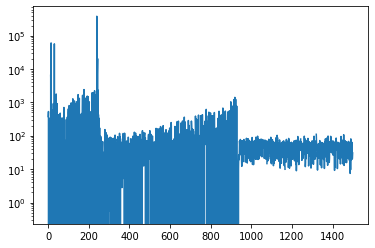

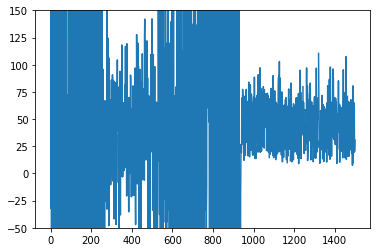


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:46,  1.68s/it]

0 331.1370737552643


  2%|▏         | 2/100 [00:03<02:43,  1.67s/it]

1 280.2598352730274


  3%|▎         | 3/100 [00:04<02:41,  1.67s/it]

2 278.9625595808029


  4%|▍         | 4/100 [00:06<02:38,  1.65s/it]

3 277.5366276204586


  5%|▌         | 5/100 [00:08<02:36,  1.65s/it]

4 276.2170387804508


  6%|▌         | 6/100 [00:09<02:33,  1.64s/it]

5 275.9663231372833


  7%|▋         | 7/100 [00:11<02:30,  1.62s/it]

6 276.14849931001663


  8%|▊         | 8/100 [00:13<02:29,  1.62s/it]

7 275.5466256439686


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 275.5074882209301


 10%|█         | 10/100 [00:16<02:25,  1.62s/it]

9 275.4225805103779


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 274.99415904283524


 12%|█▏        | 12/100 [00:19<02:21,  1.60s/it]

11 274.98768001794815


 13%|█▎        | 13/100 [00:21<02:19,  1.60s/it]

12 274.98843336105347


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

13 275.1361231505871


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

14 274.80184730887413


 16%|█▌        | 16/100 [00:25<02:16,  1.62s/it]

15 274.85611858963966


 17%|█▋        | 17/100 [00:27<02:15,  1.63s/it]

16 274.4100962281227


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 274.7122690975666


 19%|█▉        | 19/100 [00:30<02:11,  1.62s/it]

18 274.44699984788895


 20%|██        | 20/100 [00:32<02:12,  1.65s/it]

19 274.2395139336586


 21%|██        | 21/100 [00:34<02:11,  1.67s/it]

20 274.63301825523376


 22%|██▏       | 22/100 [00:35<02:08,  1.64s/it]

21 274.45681950449944


 23%|██▎       | 23/100 [00:37<02:06,  1.65s/it]

22 274.29103350639343


 24%|██▍       | 24/100 [00:39<02:04,  1.64s/it]

23 274.08579114079475


 25%|██▌       | 25/100 [00:40<02:03,  1.65s/it]

24 274.02194422483444


 26%|██▌       | 26/100 [00:42<02:00,  1.63s/it]

25 274.3318381309509


 27%|██▋       | 27/100 [00:44<01:58,  1.62s/it]

26 273.83103758096695


 28%|██▊       | 28/100 [00:45<01:57,  1.63s/it]

27 274.17993798851967


 29%|██▉       | 29/100 [00:47<01:55,  1.62s/it]

28 274.23418962955475


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 274.1642828285694


 31%|███       | 31/100 [00:50<01:52,  1.63s/it]

30 273.70837876200676


 32%|███▏      | 32/100 [00:52<01:51,  1.64s/it]

31 273.87390729784966


 33%|███▎      | 33/100 [00:53<01:49,  1.63s/it]

32 273.8703398704529


 34%|███▍      | 34/100 [00:55<01:48,  1.65s/it]

33 274.16256657242775


 35%|███▌      | 35/100 [00:57<01:46,  1.64s/it]

34 273.423868060112


 36%|███▌      | 36/100 [00:58<01:45,  1.65s/it]

35 274.00400826334953


 37%|███▋      | 37/100 [01:00<01:43,  1.65s/it]

36 273.85234636068344


 38%|███▊      | 38/100 [01:02<01:42,  1.66s/it]

37 273.5247763991356


 39%|███▉      | 39/100 [01:03<01:41,  1.66s/it]

38 273.91088250279427


 40%|████      | 40/100 [01:05<01:39,  1.66s/it]

39 273.7802450656891


 41%|████      | 41/100 [01:07<01:36,  1.64s/it]

40 273.4092101752758


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 273.8441425859928


 43%|████▎     | 43/100 [01:10<01:32,  1.63s/it]

42 273.5028932392597


 44%|████▍     | 44/100 [01:11<01:32,  1.64s/it]

43 273.2845428586006


 45%|████▌     | 45/100 [01:13<01:30,  1.65s/it]

44 273.3468194901943


 46%|████▌     | 46/100 [01:15<01:28,  1.63s/it]

45 273.4767259955406


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 273.4473971426487


 48%|████▊     | 48/100 [01:18<01:25,  1.65s/it]

47 273.57755744457245


 49%|████▉     | 49/100 [01:20<01:23,  1.63s/it]

48 273.49204018712044


 50%|█████     | 50/100 [01:21<01:21,  1.64s/it]

49 273.3232891857624


 51%|█████     | 51/100 [01:23<01:20,  1.65s/it]

50 273.61479690670967


 52%|█████▏    | 52/100 [01:25<01:18,  1.64s/it]

51 273.7128612399101


 53%|█████▎    | 53/100 [01:26<01:16,  1.64s/it]

52 273.6814542710781


 54%|█████▍    | 54/100 [01:28<01:15,  1.65s/it]

53 273.1243350505829


 55%|█████▌    | 55/100 [01:29<01:13,  1.63s/it]

54 273.3565848171711


 56%|█████▌    | 56/100 [01:31<01:11,  1.62s/it]

55 273.6353197991848


 57%|█████▋    | 57/100 [01:33<01:09,  1.62s/it]

56 273.112540602684


 58%|█████▊    | 58/100 [01:34<01:07,  1.62s/it]

57 273.2410719692707


 59%|█████▉    | 59/100 [01:36<01:06,  1.63s/it]

58 273.5548580288887


 60%|██████    | 60/100 [01:38<01:04,  1.62s/it]

59 273.191652148962


 61%|██████    | 61/100 [01:39<01:04,  1.64s/it]

60 273.25413849949837


 62%|██████▏   | 62/100 [01:41<01:02,  1.63s/it]

61 273.356076836586


 63%|██████▎   | 63/100 [01:43<01:00,  1.65s/it]

62 273.4614462554455


 64%|██████▍   | 64/100 [01:44<00:59,  1.65s/it]

63 273.3745560348034


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 272.99108216166496


 66%|██████▌   | 66/100 [01:48<00:56,  1.66s/it]

65 273.018123537302


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 273.21648198366165


 68%|██████▊   | 68/100 [01:51<00:52,  1.65s/it]

67 272.97126868367195


 69%|██████▉   | 69/100 [01:52<00:50,  1.64s/it]

68 273.2804522514343


 70%|███████   | 70/100 [01:54<00:49,  1.63s/it]

69 273.20512250065804


 71%|███████   | 71/100 [01:56<00:46,  1.62s/it]

70 273.3050141632557


 72%|███████▏  | 72/100 [01:57<00:46,  1.65s/it]

71 273.2083608210087


 73%|███████▎  | 73/100 [01:59<00:44,  1.63s/it]

72 273.1368930339813


 74%|███████▍  | 74/100 [02:01<00:42,  1.63s/it]

73 273.24853533506393


 75%|███████▌  | 75/100 [02:02<00:41,  1.64s/it]

74 273.34189823269844


 76%|███████▌  | 76/100 [02:04<00:39,  1.66s/it]

75 273.04744005203247


 77%|███████▋  | 77/100 [02:06<00:37,  1.64s/it]

76 272.93242159485817


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 272.8865285217762


 79%|███████▉  | 79/100 [02:09<00:34,  1.66s/it]

78 273.3119262754917


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 273.1531668007374


 81%|████████  | 81/100 [02:12<00:31,  1.67s/it]

80 272.8070638179779


 82%|████████▏ | 82/100 [02:14<00:30,  1.67s/it]

81 273.27856838703156


 83%|████████▎ | 83/100 [02:16<00:28,  1.66s/it]

82 273.20801573991776


 84%|████████▍ | 84/100 [02:17<00:26,  1.68s/it]

83 272.92715069651604


 85%|████████▌ | 85/100 [02:19<00:25,  1.67s/it]

84 273.00831389427185


 86%|████████▌ | 86/100 [02:20<00:23,  1.64s/it]

85 272.95148089528084


 87%|████████▋ | 87/100 [02:22<00:21,  1.64s/it]

86 273.42742761969566


 88%|████████▊ | 88/100 [02:24<00:19,  1.63s/it]

87 272.7301535010338


 89%|████████▉ | 89/100 [02:25<00:17,  1.63s/it]

88 273.3336791098118


 90%|█████████ | 90/100 [02:27<00:16,  1.62s/it]

89 273.0287007987499


 91%|█████████ | 91/100 [02:29<00:14,  1.61s/it]

90 273.2448498606682


 92%|█████████▏| 92/100 [02:30<00:12,  1.61s/it]

91 273.0912160873413


 93%|█████████▎| 93/100 [02:32<00:11,  1.61s/it]

92 272.88679111003876


 94%|█████████▍| 94/100 [02:33<00:09,  1.63s/it]

93 273.2870182096958


 95%|█████████▌| 95/100 [02:35<00:08,  1.62s/it]

94 272.88769924640656


 96%|█████████▌| 96/100 [02:37<00:06,  1.62s/it]

95 272.6806816458702


 97%|█████████▋| 97/100 [02:38<00:04,  1.64s/it]

96 272.9183651506901


 98%|█████████▊| 98/100 [02:40<00:03,  1.62s/it]

97 272.9765895307064


 99%|█████████▉| 99/100 [02:42<00:01,  1.63s/it]

98 272.68312284350395


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]

99 273.04564675688744

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.5826263427734375	

epoch 9000/10000, policy loss 0.001883620978333056	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 500.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th3_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_3 = policy_loss_list

In [ ]:
with open('policy_loss_list_3.npy', 'wb') as f:
    np.save(f, policy_loss_list_3)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 4]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 4

batch size =  50000
Config: {'ALG': 'May1_test1_th4_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 4, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

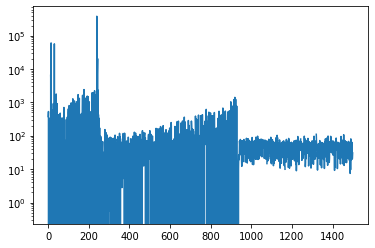

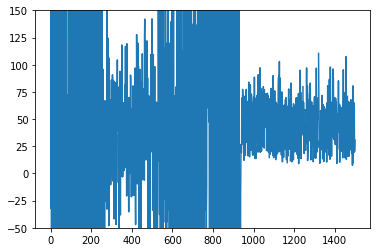


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  1%|          | 1/100 [00:01<02:39,  1.61s/it]

0 458.14095240831375


  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

1 385.53909945487976


  3%|▎         | 3/100 [00:04<02:36,  1.61s/it]

2 382.1601721048355


  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]

3 380.2224694490433


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 379.5685480237007


  6%|▌         | 6/100 [00:09<02:32,  1.62s/it]

5 378.52447777986526


  7%|▋         | 7/100 [00:11<02:30,  1.61s/it]

6 378.4989966750145


  8%|▊         | 8/100 [00:12<02:28,  1.61s/it]

7 377.95162189006805


  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

8 377.735186457634


 10%|█         | 10/100 [00:16<02:25,  1.61s/it]

9 377.8160279393196


 11%|█         | 11/100 [00:17<02:23,  1.61s/it]

10 377.1444729566574


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

11 376.85272789001465


 13%|█▎        | 13/100 [00:21<02:20,  1.61s/it]

12 377.10765236616135


 14%|█▍        | 14/100 [00:22<02:17,  1.60s/it]

13 377.159645318985


 15%|█▌        | 15/100 [00:24<02:17,  1.61s/it]

14 376.75308805704117


 16%|█▌        | 16/100 [00:25<02:15,  1.62s/it]

15 376.94828975200653


 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

16 376.78533178567886


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 376.730981528759


 19%|█▉        | 19/100 [00:30<02:11,  1.63s/it]

18 376.724601149559


 20%|██        | 20/100 [00:32<02:09,  1.62s/it]

19 376.32525008916855


 21%|██        | 21/100 [00:34<02:09,  1.63s/it]

20 376.78580194711685


 22%|██▏       | 22/100 [00:35<02:06,  1.62s/it]

21 376.3378132581711


 23%|██▎       | 23/100 [00:37<02:04,  1.62s/it]

22 376.5279993414879


 24%|██▍       | 24/100 [00:38<02:02,  1.61s/it]

23 376.0284957885742


 25%|██▌       | 25/100 [00:40<02:02,  1.63s/it]

24 375.9956703186035


 26%|██▌       | 26/100 [00:42<02:00,  1.63s/it]

25 376.22467935085297


 27%|██▋       | 27/100 [00:43<01:58,  1.63s/it]

26 375.7737295627594


 28%|██▊       | 28/100 [00:45<01:58,  1.64s/it]

27 375.99238216876984


 29%|██▉       | 29/100 [00:47<01:55,  1.63s/it]

28 376.12437492609024


 30%|███       | 30/100 [00:48<01:53,  1.62s/it]

29 376.42395532131195


 31%|███       | 31/100 [00:50<01:51,  1.62s/it]

30 375.82136833667755


 32%|███▏      | 32/100 [00:51<01:50,  1.62s/it]

31 375.7602673172951


 33%|███▎      | 33/100 [00:53<01:50,  1.64s/it]

32 376.07972556352615


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 376.10817378759384


 35%|███▌      | 35/100 [00:56<01:46,  1.63s/it]

34 375.3499831557274


 36%|███▌      | 36/100 [00:58<01:45,  1.64s/it]

35 376.005636036396


 37%|███▋      | 37/100 [01:00<01:43,  1.64s/it]

36 375.83478885889053


 38%|███▊      | 38/100 [01:01<01:41,  1.63s/it]

37 374.99941688776016


 39%|███▉      | 39/100 [01:03<01:39,  1.62s/it]

38 376.43352872133255


 40%|████      | 40/100 [01:04<01:37,  1.62s/it]

39 375.50174218416214


 41%|████      | 41/100 [01:06<01:34,  1.61s/it]

40 375.508504986763


 42%|████▏     | 42/100 [01:08<01:34,  1.63s/it]

41 375.7503463625908


 43%|████▎     | 43/100 [01:09<01:32,  1.63s/it]

42 375.54787516593933


 44%|████▍     | 44/100 [01:11<01:30,  1.62s/it]

43 375.0511623620987


 45%|████▌     | 45/100 [01:12<01:28,  1.61s/it]

44 375.8259227871895


 46%|████▌     | 46/100 [01:14<01:28,  1.63s/it]

45 375.4002010822296


 47%|████▋     | 47/100 [01:16<01:26,  1.63s/it]

46 375.19975984096527


 48%|████▊     | 48/100 [01:17<01:25,  1.63s/it]

47 375.29962438344955


 49%|████▉     | 49/100 [01:19<01:23,  1.64s/it]

48 375.3646755218506


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 375.53023594617844


 51%|█████     | 51/100 [01:22<01:19,  1.62s/it]

50 375.35339576005936


 52%|█████▏    | 52/100 [01:24<01:18,  1.63s/it]

51 375.4846222996712


 53%|█████▎    | 53/100 [01:26<01:16,  1.62s/it]

52 375.5020549893379


 54%|█████▍    | 54/100 [01:27<01:14,  1.62s/it]

53 375.22646266222


 55%|█████▌    | 55/100 [01:29<01:13,  1.62s/it]

54 375.26334977149963


 56%|█████▌    | 56/100 [01:30<01:10,  1.61s/it]

55 375.20898205041885


 57%|█████▋    | 57/100 [01:32<01:09,  1.61s/it]

56 375.1432646512985


 58%|█████▊    | 58/100 [01:34<01:07,  1.61s/it]

57 375.20448929071426


 59%|█████▉    | 59/100 [01:35<01:05,  1.60s/it]

58 375.2159181237221


 60%|██████    | 60/100 [01:37<01:04,  1.60s/it]

59 375.25027334690094


 61%|██████    | 61/100 [01:38<01:02,  1.59s/it]

60 375.0934066772461


 62%|██████▏   | 62/100 [01:40<01:00,  1.59s/it]

61 374.86243534088135


 63%|██████▎   | 63/100 [01:42<00:58,  1.59s/it]

62 375.11958891153336


 64%|██████▍   | 64/100 [01:43<00:57,  1.59s/it]

63 375.37538427114487


 65%|██████▌   | 65/100 [01:45<00:56,  1.63s/it]

64 375.1102687716484


 66%|██████▌   | 66/100 [01:46<00:55,  1.62s/it]

65 374.3982310295105


 67%|██████▋   | 67/100 [01:48<00:54,  1.64s/it]

66 375.28113359212875


 68%|██████▊   | 68/100 [01:50<00:52,  1.63s/it]

67 374.77266842126846


 69%|██████▉   | 69/100 [01:51<00:50,  1.61s/it]

68 375.43507170677185


 70%|███████   | 70/100 [01:53<00:48,  1.63s/it]

69 375.23262894153595


 71%|███████   | 71/100 [01:55<00:46,  1.61s/it]

70 374.8462089896202


 72%|███████▏  | 72/100 [01:56<00:45,  1.61s/it]

71 374.9030736088753


 73%|███████▎  | 73/100 [01:58<00:43,  1.63s/it]

72 375.07585632801056


 74%|███████▍  | 74/100 [02:00<00:42,  1.64s/it]

73 374.89128905534744


 75%|███████▌  | 75/100 [02:01<00:40,  1.64s/it]

74 374.74499183893204


 76%|███████▌  | 76/100 [02:03<00:39,  1.63s/it]

75 374.860904276371


 77%|███████▋  | 77/100 [02:04<00:37,  1.64s/it]

76 374.7465372681618


 78%|███████▊  | 78/100 [02:06<00:35,  1.63s/it]

77 374.9660003185272


 79%|███████▉  | 79/100 [02:08<00:34,  1.64s/it]

78 375.1763818860054


 80%|████████  | 80/100 [02:09<00:32,  1.65s/it]

79 375.19243413209915


 81%|████████  | 81/100 [02:11<00:31,  1.66s/it]

80 374.12847208976746


 82%|████████▏ | 82/100 [02:13<00:29,  1.65s/it]

81 374.77064579725266


 83%|████████▎ | 83/100 [02:14<00:27,  1.63s/it]

82 374.7438830733299


 84%|████████▍ | 84/100 [02:16<00:26,  1.63s/it]

83 374.48867785930634


 85%|████████▌ | 85/100 [02:18<00:24,  1.63s/it]

84 374.7136719226837


 86%|████████▌ | 86/100 [02:19<00:23,  1.66s/it]

85 374.8500249385834


 87%|████████▋ | 87/100 [02:21<00:21,  1.64s/it]

86 374.80240046977997


 88%|████████▊ | 88/100 [02:22<00:19,  1.63s/it]

87 374.32861137390137


 89%|████████▉ | 89/100 [02:24<00:17,  1.63s/it]

88 374.71640318632126


 90%|█████████ | 90/100 [02:26<00:16,  1.64s/it]

89 374.44784939289093


 91%|█████████ | 91/100 [02:27<00:14,  1.64s/it]

90 374.7888387441635


 92%|█████████▏| 92/100 [02:29<00:12,  1.62s/it]

91 374.6575449705124


 93%|█████████▎| 93/100 [02:31<00:11,  1.63s/it]

92 374.4447611570358


 94%|█████████▍| 94/100 [02:32<00:09,  1.62s/it]

93 374.8049605488777


 95%|█████████▌| 95/100 [02:34<00:08,  1.61s/it]

94 374.2784759402275


 96%|█████████▌| 96/100 [02:35<00:06,  1.61s/it]

95 374.16536086797714


 97%|█████████▋| 97/100 [02:37<00:04,  1.60s/it]

96 374.5168690085411


 98%|█████████▊| 98/100 [02:39<00:03,  1.59s/it]

97 374.3861135840416


 99%|█████████▉| 99/100 [02:40<00:01,  1.59s/it]

98 374.38456904888153


100%|██████████| 100/100 [02:42<00:00,  1.61s/it]

99 374.5071594119072

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.06912165135145187	

epoch 9000/10000, policy loss 0.006667280104011297	
***** test student *****
epoch 0/100 return: 162.0
epoch 1/100 return: 173.0
epoch 2/100 return: 174.0
epoch 3/100 return: 164.0
epoch 4/100 return: 152.0
epoch 5/100 return: 162.0
epoch 6/100 return: 144.0
epoch 7/100 return: 157.0
epoch 8/100 return: 173.0
epoch 9/100 return: 145.0
epoch 10/100 return: 190.0
epoch 11/100 return: 155.0
epoch 12/100 return: 168.0
epoch 13/100 return: 174.0
epoch 14/100 return: 156.0
epoch 15/100 return: 160.0
epoch 16/100 return: 213.0
epoch 17/100 return: 146.0
epoch 18/100 return: 169.0
epoch 19/100 return: 175.0
epoch 20/100 return: 157.0
epoch 21/100 return: 149.0
epoch 22/100 return: 167.0
epoch 23/100 return: 240.0
epoch 24/100 return: 157.0
epoch 25/100 return: 150.0
epoch 26/100 return: 169.0
epoch 27/100 return: 159.0
epoch 28/100 return: 164.0
epoch 29/100 return: 159.0
epoch 30/100 return: 142.0
epoch 31/100 return: 197.0
epoch 32/100 return: 161.0
epoch 33/100 return: 172.0
epoch 34/100 re

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th4_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_4 = policy_loss_list

In [ ]:
with open('policy_loss_list_4.npy', 'wb') as f:
    np.save(f, policy_loss_list_4)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 5]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 5

batch size =  50000
Config: {'ALG': 'May1_test1_th5_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 5, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

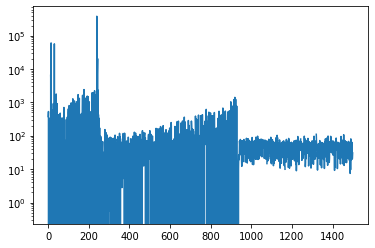

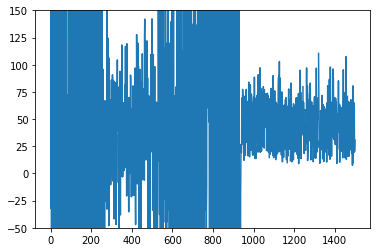


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

  0%|          | 0/100 [00:00<?, ?it/s]


***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:39,  1.61s/it]

0 31.430748090147972


  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

1 27.96618688106537


  3%|▎         | 3/100 [00:04<02:38,  1.63s/it]

2 27.539222944527864


  4%|▍         | 4/100 [00:06<02:36,  1.63s/it]

3 27.45961194112897


  5%|▌         | 5/100 [00:08<02:34,  1.63s/it]

4 27.380707565695047


  6%|▌         | 6/100 [00:09<02:34,  1.65s/it]

5 27.243543837219477


  7%|▋         | 7/100 [00:11<02:34,  1.67s/it]

6 27.19235296919942


  8%|▊         | 8/100 [00:13<02:32,  1.66s/it]

7 27.220689356327057


  9%|▉         | 9/100 [00:14<02:30,  1.66s/it]

8 27.271565042436123


 10%|█         | 10/100 [00:16<02:29,  1.66s/it]

9 27.16327530518174


 11%|█         | 11/100 [00:18<02:25,  1.64s/it]

10 27.125561982393265


 12%|█▏        | 12/100 [00:19<02:25,  1.66s/it]

11 27.192689336836338


 13%|█▎        | 13/100 [00:21<02:25,  1.68s/it]

12 27.162919532507658


 14%|█▍        | 14/100 [00:23<02:21,  1.64s/it]

13 27.08353278040886


 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]

14 27.09537871554494


 16%|█▌        | 16/100 [00:26<02:19,  1.65s/it]

15 27.111227978020906


 17%|█▋        | 17/100 [00:28<02:15,  1.64s/it]

16 27.105205971747637


 18%|█▊        | 18/100 [00:29<02:13,  1.63s/it]

17 27.100356720387936


 19%|█▉        | 19/100 [00:31<02:12,  1.64s/it]

18 27.049072679132223


 20%|██        | 20/100 [00:32<02:10,  1.63s/it]

19 27.036110039800406


 21%|██        | 21/100 [00:34<02:09,  1.63s/it]

20 27.026373986154795


 22%|██▏       | 22/100 [00:36<02:06,  1.62s/it]

21 27.399547427892685


 23%|██▎       | 23/100 [00:37<02:05,  1.63s/it]

22 26.96771239489317


 24%|██▍       | 24/100 [00:39<02:03,  1.63s/it]

23 26.98185132816434


 25%|██▌       | 25/100 [00:41<02:03,  1.65s/it]

24 27.015547025948763


 26%|██▌       | 26/100 [00:42<02:02,  1.66s/it]

25 27.032600659877062


 27%|██▋       | 27/100 [00:44<01:59,  1.64s/it]

26 27.011740375310183


 28%|██▊       | 28/100 [00:45<01:57,  1.63s/it]

27 26.98699000477791


 29%|██▉       | 29/100 [00:47<01:56,  1.64s/it]

28 26.98887737840414


 30%|███       | 30/100 [00:49<01:53,  1.62s/it]

29 26.986677836626768


 31%|███       | 31/100 [00:50<01:53,  1.64s/it]

30 26.994559302926064


 32%|███▏      | 32/100 [00:52<01:51,  1.63s/it]

31 26.988013707101345


 33%|███▎      | 33/100 [00:54<01:49,  1.63s/it]

32 26.974317986518145


 34%|███▍      | 34/100 [00:55<01:47,  1.62s/it]

33 27.019695691764355


 35%|███▌      | 35/100 [00:57<01:45,  1.62s/it]

34 26.991749484091997


 36%|███▌      | 36/100 [00:58<01:43,  1.61s/it]

35 26.949822064489126


 37%|███▋      | 37/100 [01:00<01:40,  1.60s/it]

36 27.01940482482314


 38%|███▊      | 38/100 [01:02<01:39,  1.61s/it]

37 26.98875590786338


 39%|███▉      | 39/100 [01:03<01:37,  1.61s/it]

38 26.96767470613122


 40%|████      | 40/100 [01:05<01:36,  1.61s/it]

39 26.979380387812853


 41%|████      | 41/100 [01:07<01:35,  1.62s/it]

40 26.95222719758749


 42%|████▏     | 42/100 [01:08<01:35,  1.65s/it]

41 26.939196288585663


 43%|████▎     | 43/100 [01:10<01:35,  1.67s/it]

42 26.94247369468212


 44%|████▍     | 44/100 [01:12<01:34,  1.68s/it]

43 27.455670565366745


 45%|████▌     | 45/100 [01:13<01:31,  1.66s/it]

44 26.92575139924884


 46%|████▌     | 46/100 [01:15<01:29,  1.65s/it]

45 26.953996051102877


 47%|████▋     | 47/100 [01:17<01:26,  1.64s/it]

46 26.93560580909252


 48%|████▊     | 48/100 [01:18<01:24,  1.63s/it]

47 26.915674339979887


 49%|████▉     | 49/100 [01:20<01:22,  1.63s/it]

48 26.950653821229935


 50%|█████     | 50/100 [01:21<01:21,  1.63s/it]

49 26.972627002745867


 51%|█████     | 51/100 [01:23<01:20,  1.64s/it]

50 26.971100453287363


 52%|█████▏    | 52/100 [01:25<01:18,  1.63s/it]

51 26.933019619435072


 53%|█████▎    | 53/100 [01:26<01:16,  1.63s/it]

52 26.97305813804269


 54%|█████▍    | 54/100 [01:28<01:15,  1.63s/it]

53 26.929980773478746


 55%|█████▌    | 55/100 [01:30<01:13,  1.62s/it]

54 26.936838429421186


 56%|█████▌    | 56/100 [01:31<01:10,  1.61s/it]

55 26.936962489038706


 57%|█████▋    | 57/100 [01:33<01:09,  1.61s/it]

56 27.002780862152576


 58%|█████▊    | 58/100 [01:34<01:07,  1.62s/it]

57 26.919540729373693


 59%|█████▉    | 59/100 [01:36<01:06,  1.62s/it]

58 26.946787927299738


 60%|██████    | 60/100 [01:38<01:04,  1.61s/it]

59 27.209279868751764


 61%|██████    | 61/100 [01:39<01:02,  1.61s/it]

60 26.881166711449623


 62%|██████▏   | 62/100 [01:41<01:01,  1.62s/it]

61 26.891642529517412


 63%|██████▎   | 63/100 [01:42<01:00,  1.63s/it]

62 26.91507249325514


 64%|██████▍   | 64/100 [01:44<00:58,  1.64s/it]

63 26.94960942491889


 65%|██████▌   | 65/100 [01:46<00:57,  1.65s/it]

64 26.928269557654858


 66%|██████▌   | 66/100 [01:47<00:56,  1.65s/it]

65 26.970831405371428


 67%|██████▋   | 67/100 [01:49<00:54,  1.65s/it]

66 26.89310609549284


 68%|██████▊   | 68/100 [01:51<00:53,  1.66s/it]

67 26.9091114141047


 69%|██████▉   | 69/100 [01:52<00:51,  1.66s/it]

68 26.931326020509005


 70%|███████   | 70/100 [01:54<00:49,  1.64s/it]

69 26.933834496885538


 71%|███████   | 71/100 [01:56<00:47,  1.63s/it]

70 26.92482865974307


 72%|███████▏  | 72/100 [01:57<00:45,  1.63s/it]

71 26.938866320997477


 73%|███████▎  | 73/100 [01:59<00:44,  1.65s/it]

72 26.915178529918194


 74%|███████▍  | 74/100 [02:01<00:42,  1.65s/it]

73 26.92467650398612


 75%|███████▌  | 75/100 [02:02<00:40,  1.63s/it]

74 26.932261258363724


 76%|███████▌  | 76/100 [02:04<00:39,  1.64s/it]

75 26.951839823275805


 77%|███████▋  | 77/100 [02:06<00:37,  1.65s/it]

76 26.90616011992097


 78%|███████▊  | 78/100 [02:07<00:36,  1.64s/it]

77 26.89730279147625


 79%|███████▉  | 79/100 [02:09<00:34,  1.64s/it]

78 26.980937507003546


 80%|████████  | 80/100 [02:10<00:32,  1.64s/it]

79 26.900748923420906


 81%|████████  | 81/100 [02:12<00:31,  1.64s/it]

80 26.911502316594124


 82%|████████▏ | 82/100 [02:14<00:29,  1.65s/it]

81 27.82052929699421


 83%|████████▎ | 83/100 [02:15<00:28,  1.65s/it]

82 26.924732640385628


 84%|████████▍ | 84/100 [02:17<00:26,  1.63s/it]

83 26.898652832955122


 85%|████████▌ | 85/100 [02:19<00:24,  1.63s/it]

84 26.900322750210762


 86%|████████▌ | 86/100 [02:20<00:22,  1.63s/it]

85 26.906231209635735


 87%|████████▋ | 87/100 [02:22<00:20,  1.61s/it]

86 26.89153379201889


 88%|████████▊ | 88/100 [02:23<00:19,  1.60s/it]

87 26.897764336317778


 89%|████████▉ | 89/100 [02:25<00:17,  1.60s/it]

88 26.923490338027477


 90%|█████████ | 90/100 [02:27<00:16,  1.61s/it]

89 26.88942576944828


 91%|█████████ | 91/100 [02:28<00:14,  1.62s/it]

90 26.95996391400695


 92%|█████████▏| 92/100 [02:30<00:13,  1.64s/it]

91 26.9106907248497


 93%|█████████▎| 93/100 [02:32<00:11,  1.64s/it]

92 26.91302650421858


 94%|█████████▍| 94/100 [02:33<00:09,  1.62s/it]

93 26.926015503704548


 95%|█████████▌| 95/100 [02:35<00:08,  1.62s/it]

94 26.947490096092224


 96%|█████████▌| 96/100 [02:36<00:06,  1.62s/it]

95 26.9219216927886


 97%|█████████▋| 97/100 [02:38<00:04,  1.63s/it]

96 26.915202870965004


 98%|█████████▊| 98/100 [02:40<00:03,  1.64s/it]

97 26.881365317851305


 99%|█████████▉| 99/100 [02:41<00:01,  1.63s/it]

98 26.94829571992159


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

99 26.920965041965246

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 0.07600545138120651	

epoch 9000/10000, policy loss 0.058518052101135254	
***** test student *****
epoch 0/100 return: 500.0
epoch 1/100 return: 453.0
epoch 2/100 return: 500.0
epoch 3/100 return: 500.0
epoch 4/100 return: 500.0
epoch 5/100 return: 500.0
epoch 6/100 return: 500.0
epoch 7/100 return: 500.0
epoch 8/100 return: 500.0
epoch 9/100 return: 500.0
epoch 10/100 return: 500.0
epoch 11/100 return: 500.0
epoch 12/100 return: 500.0
epoch 13/100 return: 500.0
epoch 14/100 return: 500.0
epoch 15/100 return: 500.0
epoch 16/100 return: 500.0
epoch 17/100 return: 500.0
epoch 18/100 return: 500.0
epoch 19/100 return: 500.0
epoch 20/100 return: 500.0
epoch 21/100 return: 500.0
epoch 22/100 return: 500.0
epoch 23/100 return: 500.0
epoch 24/100 return: 500.0
epoch 25/100 return: 500.0
epoch 26/100 return: 500.0
epoch 27/100 return: 500.0
epoch 28/100 return: 500.0
epoch 29/100 return: 500.0
epoch 30/100 return: 500.0
epoch 31/100 return: 500.0
epoch 32/100 return: 500.0
epoch 33/100 return: 500.0
epoch 34/100 re

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th5_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_5 = policy_loss_list

In [ ]:
with open('policy_loss_list_5.npy', 'wb') as f:
    np.save(f, policy_loss_list_5)

#10 Trails -- iVAE IRM 5 traj_num loss [threshold = 6]

In [ ]:
config["NUM_REPETITIONS"] = 1
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = 6

batch size =  50000
Config: {'ALG': 'May1_test1_th6_NFiVAEStudent_replicatedata_trajnum5', 'NUM_TRAJS_GIVEN': 5, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 5, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 1, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 6, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 8, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1
Run 2 out of 1

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  8
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (989, 8)
part1 & 2 =  -215.62387 159.5997 93.61987
epoch 0/1500 	loss: 375.22357177734375part1 & 2 =  -200.85034 330.228 94.21149
part1 & 2 =  -193.97115 -226.02452 93.80848
part1 & 2 =  -171.1798 -169.7078 92.89492
part1 & 2 =  -170.471 152.99612 91.403854
part1 & 2 =  -157.96094 -412.57224 90.63407
part1 & 2 =  -150.61269 183.1942 89.949234
part1 & 2 =  -144.02838 -1410.7355 88.244316
part1 & 2 =  -137.73952 64.480286 90.48191
part1 & 2 =  -128.36786 -9551.89 90.554886
part1 & 2 =  -121.83461 -70740.7 88.869644
part1 & 2 =  -115.56012 -27621.627 89.43836
part1 & 2 =  -110.55096 6641.6704 88.29433
part1 & 2 =  -106.531494 2755.807 88.10245
part1 & 2 =  -94.81823 60189.145 87.951744
part1 & 2 =  -100.669365 -23235.535 88.29583
part1 & 2 =  -93.18701 92.8683 8

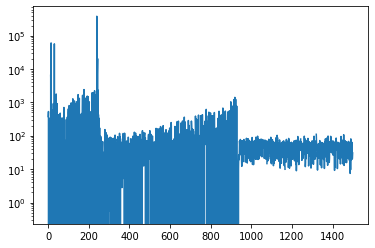

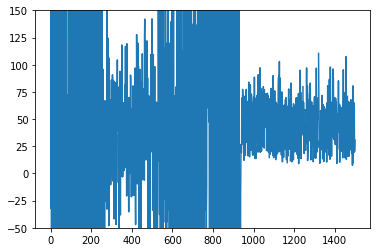


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  25000
0 and 1 are DEPENDENT with pval_d=6.425295111249316e-10 and pval_i=5.182072879626635e-10
0 and 2 are DEPENDENT with pval_d=3.9604800336634075e-09 and pval_i=6.140742395756274e-13
0 and 3 are DEPENDENT with pval_d=1.550244231072565e-09 and pval_i=1.014926715602201e-10
0 and 4 are DEPENDENT with pval_d=2.03369610229834e-09 and pval_i=1.4956277322099654e-09
0 and 5 are DEPENDENT with pval_d=2.118412255448369e-09 and pval_i=1.2201942440936366e-09
0 and 6 are independent with pval_d=1.303197052909519e-10 and pval_i=7.584529135359981e-10
0 and 7 are DEPENDENT with pval_d=9.839906283345884e-09 and pval_i=1.377964590611898e-10
1 and 2 are independent with pval_d=9.832460819794393e-10 and pval_i=1.5627866306918206e-09
1 and 3 are DEPENDENT with pval_d=7.861781549342967e-10 and pval_i=2.9161281117918153e-10
1 and 4 are independent with pval_d=2.3737074838716087e-11 and pval_i=4.878478378493917e-11
1 and 5 are i

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


generating stored samples using both a and e
using all data to generate stored data (499000, 8)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:01<02:25,  1.47s/it]

0 nan


  2%|▏         | 2/100 [00:02<02:25,  1.49s/it]

1 nan


  3%|▎         | 3/100 [00:04<02:25,  1.50s/it]

2 nan


  4%|▍         | 4/100 [00:06<02:25,  1.51s/it]

3 nan


  5%|▌         | 5/100 [00:07<02:24,  1.52s/it]

4 nan


  6%|▌         | 6/100 [00:09<02:22,  1.52s/it]

5 nan


  7%|▋         | 7/100 [00:10<02:22,  1.54s/it]

6 nan


  8%|▊         | 8/100 [00:12<02:19,  1.52s/it]

7 nan


  9%|▉         | 9/100 [00:13<02:18,  1.52s/it]

8 nan


 10%|█         | 10/100 [00:15<02:15,  1.51s/it]

9 nan


 11%|█         | 11/100 [00:16<02:13,  1.50s/it]

10 nan


 12%|█▏        | 12/100 [00:18<02:11,  1.50s/it]

11 nan


 13%|█▎        | 13/100 [00:19<02:11,  1.51s/it]

12 nan


 14%|█▍        | 14/100 [00:21<02:09,  1.50s/it]

13 nan


 15%|█▌        | 15/100 [00:22<02:10,  1.53s/it]

14 nan


 16%|█▌        | 16/100 [00:24<02:09,  1.54s/it]

15 nan


 17%|█▋        | 17/100 [00:25<02:10,  1.57s/it]

16 nan


 18%|█▊        | 18/100 [00:27<02:09,  1.58s/it]

17 nan


 19%|█▉        | 19/100 [00:29<02:05,  1.55s/it]

18 nan


 20%|██        | 20/100 [00:30<02:05,  1.56s/it]

19 nan


 21%|██        | 21/100 [00:32<02:03,  1.56s/it]

20 nan


 22%|██▏       | 22/100 [00:33<02:00,  1.54s/it]

21 nan


 23%|██▎       | 23/100 [00:35<01:58,  1.53s/it]

22 nan


 24%|██▍       | 24/100 [00:36<01:57,  1.55s/it]

23 nan


 25%|██▌       | 25/100 [00:38<01:57,  1.57s/it]

24 nan


 26%|██▌       | 26/100 [00:39<01:55,  1.56s/it]

25 nan


 27%|██▋       | 27/100 [00:41<01:52,  1.54s/it]

26 nan


 28%|██▊       | 28/100 [00:42<01:49,  1.52s/it]

27 nan


 29%|██▉       | 29/100 [00:44<01:47,  1.52s/it]

28 nan


 30%|███       | 30/100 [00:45<01:46,  1.52s/it]

29 nan


 31%|███       | 31/100 [00:47<01:45,  1.53s/it]

30 nan


 32%|███▏      | 32/100 [00:48<01:43,  1.51s/it]

31 nan


 33%|███▎      | 33/100 [00:50<01:42,  1.52s/it]

32 nan


 34%|███▍      | 34/100 [00:52<01:40,  1.52s/it]

33 nan


 35%|███▌      | 35/100 [00:53<01:39,  1.52s/it]

34 nan


 36%|███▌      | 36/100 [00:55<01:37,  1.53s/it]

35 nan


 37%|███▋      | 37/100 [00:56<01:36,  1.53s/it]

36 nan


 38%|███▊      | 38/100 [00:58<01:34,  1.53s/it]

37 nan


 39%|███▉      | 39/100 [00:59<01:32,  1.52s/it]

38 nan


 40%|████      | 40/100 [01:01<01:30,  1.51s/it]

39 nan


 41%|████      | 41/100 [01:02<01:28,  1.50s/it]

40 nan


 42%|████▏     | 42/100 [01:04<01:26,  1.49s/it]

41 nan


 43%|████▎     | 43/100 [01:05<01:25,  1.50s/it]

42 nan


 44%|████▍     | 44/100 [01:07<01:23,  1.49s/it]

43 nan


 45%|████▌     | 45/100 [01:08<01:22,  1.50s/it]

44 nan


 46%|████▌     | 46/100 [01:10<01:20,  1.50s/it]

45 nan


 47%|████▋     | 47/100 [01:11<01:20,  1.52s/it]

46 nan


 48%|████▊     | 48/100 [01:13<01:18,  1.51s/it]

47 nan


 49%|████▉     | 49/100 [01:14<01:18,  1.53s/it]

48 nan


 50%|█████     | 50/100 [01:16<01:17,  1.54s/it]

49 nan


 51%|█████     | 51/100 [01:17<01:15,  1.54s/it]

50 nan


 52%|█████▏    | 52/100 [01:19<01:14,  1.54s/it]

51 nan


 53%|█████▎    | 53/100 [01:20<01:12,  1.53s/it]

52 nan


 54%|█████▍    | 54/100 [01:22<01:10,  1.54s/it]

53 nan


 55%|█████▌    | 55/100 [01:23<01:08,  1.53s/it]

54 nan


 56%|█████▌    | 56/100 [01:25<01:07,  1.54s/it]

55 nan


 57%|█████▋    | 57/100 [01:27<01:07,  1.56s/it]

56 nan


 58%|█████▊    | 58/100 [01:28<01:04,  1.55s/it]

57 nan


 59%|█████▉    | 59/100 [01:30<01:02,  1.53s/it]

58 nan


 60%|██████    | 60/100 [01:31<01:00,  1.52s/it]

59 nan


 61%|██████    | 61/100 [01:33<00:58,  1.51s/it]

60 nan


 62%|██████▏   | 62/100 [01:34<00:57,  1.51s/it]

61 nan


 63%|██████▎   | 63/100 [01:36<00:56,  1.52s/it]

62 nan


 64%|██████▍   | 64/100 [01:37<00:54,  1.52s/it]

63 nan


 65%|██████▌   | 65/100 [01:39<00:53,  1.54s/it]

64 nan


 66%|██████▌   | 66/100 [01:40<00:52,  1.53s/it]

65 nan


 67%|██████▋   | 67/100 [01:42<00:50,  1.53s/it]

66 nan


 68%|██████▊   | 68/100 [01:43<00:48,  1.53s/it]

67 nan


 69%|██████▉   | 69/100 [01:45<00:47,  1.52s/it]

68 nan


 70%|███████   | 70/100 [01:46<00:45,  1.53s/it]

69 nan


 71%|███████   | 71/100 [01:48<00:43,  1.52s/it]

70 nan


 72%|███████▏  | 72/100 [01:49<00:42,  1.52s/it]

71 nan


 73%|███████▎  | 73/100 [01:51<00:41,  1.52s/it]

72 nan


 74%|███████▍  | 74/100 [01:53<00:39,  1.53s/it]

73 nan


 75%|███████▌  | 75/100 [01:54<00:38,  1.53s/it]

74 nan


 76%|███████▌  | 76/100 [01:56<00:36,  1.53s/it]

75 nan


 77%|███████▋  | 77/100 [01:57<00:35,  1.55s/it]

76 nan


 78%|███████▊  | 78/100 [01:59<00:34,  1.56s/it]

77 nan


 79%|███████▉  | 79/100 [02:00<00:32,  1.55s/it]

78 nan


 80%|████████  | 80/100 [02:02<00:30,  1.53s/it]

79 nan


 81%|████████  | 81/100 [02:03<00:29,  1.54s/it]

80 nan


 82%|████████▏ | 82/100 [02:05<00:27,  1.55s/it]

81 nan


 83%|████████▎ | 83/100 [02:06<00:25,  1.53s/it]

82 nan


 84%|████████▍ | 84/100 [02:08<00:24,  1.55s/it]

83 nan


 85%|████████▌ | 85/100 [02:10<00:23,  1.58s/it]

84 nan


 86%|████████▌ | 86/100 [02:11<00:21,  1.55s/it]

85 nan


 87%|████████▋ | 87/100 [02:13<00:20,  1.54s/it]

86 nan


 88%|████████▊ | 88/100 [02:14<00:18,  1.53s/it]

87 nan


 89%|████████▉ | 89/100 [02:16<00:16,  1.53s/it]

88 nan


 90%|█████████ | 90/100 [02:17<00:15,  1.56s/it]

89 nan


 91%|█████████ | 91/100 [02:19<00:13,  1.55s/it]

90 nan


 92%|█████████▏| 92/100 [02:20<00:12,  1.52s/it]

91 nan


 93%|█████████▎| 93/100 [02:22<00:10,  1.51s/it]

92 nan


 94%|█████████▍| 94/100 [02:23<00:09,  1.51s/it]

93 nan


 95%|█████████▌| 95/100 [02:25<00:07,  1.50s/it]

94 nan


 96%|█████████▌| 96/100 [02:26<00:06,  1.51s/it]

95 nan


 97%|█████████▋| 97/100 [02:28<00:04,  1.50s/it]

96 nan


 98%|█████████▊| 98/100 [02:29<00:03,  1.51s/it]

97 nan


 99%|█████████▉| 99/100 [02:31<00:01,  1.52s/it]

98 nan


100%|██████████| 100/100 [02:32<00:00,  1.51s/it]

99 nan

***** train student policy network *****
train in NFiVAE



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/linear.py:103: UserWarning: An output with one or more elements was resized since it had shape [989, 64], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  return F.linear(input, self.weight, self.bias)


RuntimeError: ignored

In [ ]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [5]: #[50, 40, 30, 20, 10, 5, 2, 1]:  # 
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "May1_test1_th6_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in [1]: #range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            policy_loss_list = student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [ ]:
policy_loss_list_6 = policy_loss_list

In [ ]:
with open('policy_loss_list_6.npy', 'wb') as f:
    np.save(f, policy_loss_list_6)

In [ ]:
plt.plot(policy_loss_list_neg1, labels='Threshold >=0')
plt.plot(policy_loss_list_0, labels='Threshold >=1')
plt.plot(policy_loss_list_1, labels='Threshold >=2')
plt.plot(policy_loss_list_2, labels='Threshold >=3')
plt.plot(policy_loss_list_3, labels='Threshold >=4')
plt.plot(policy_loss_list_4, labels='Threshold >=5')
plt.plot(policy_loss_list_5, labels='Threshold >=6')
plt.plot(policy_loss_list_6, labels='Threshold >=7')



In [ ]:
with open('policy_loss_list_neg1.npy', 'rb') as f:
    policy_loss_list_neg1 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_0.npy', 'rb') as f:
    policy_loss_list_0 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_1.npy', 'rb') as f:
    policy_loss_list_1 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_2.npy', 'rb') as f:
    policy_loss_list_2 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_3.npy', 'rb') as f:
    policy_loss_list_3 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_4.npy', 'rb') as f:
    policy_loss_list_4 = np.load(f, allow_pickle = True)

In [ ]:
with open('policy_loss_list_5.npy', 'rb') as f:
    policy_loss_list_5 = np.load(f, allow_pickle = True)

In [ ]:
policy_loss_list_neg1 = np.stack([policy_loss_list_neg1[i].cpu().numpy() for i in range(len(policy_loss_list_neg1))])

AttributeError: ignored

In [ ]:
policy_loss_list_0 = np.stack([policy_loss_list_0[i].cpu().numpy() for i in range(len(policy_loss_list_0))])

AttributeError: ignored

In [ ]:
policy_loss_list_1 = np.stack([policy_loss_list_1[i].cpu().numpy() for i in range(len(policy_loss_list_1))])

AttributeError: ignored

In [ ]:
policy_loss_list_2 = np.stack([policy_loss_list_2[i].cpu().numpy() for i in range(len(policy_loss_list_2))])

AttributeError: ignored

In [ ]:
policy_loss_list_3 = np.stack([policy_loss_list_3[i].cpu().numpy() for i in range(len(policy_loss_list_3))])

In [ ]:
policy_loss_list_4 = np.stack([policy_loss_list_4[i].cpu().numpy() for i in range(len(policy_loss_list_4))])

In [ ]:
policy_loss_list_5 = np.stack([policy_loss_list_5[i].cpu().numpy() for i in range(len(policy_loss_list_5))])

In [ ]:
result = np.zeros((6, 10000))

In [ ]:
result[0] = policy_loss_list_neg1
result[1] = policy_loss_list_1
result[2] = policy_loss_list_2
result[3] = policy_loss_list_3
result[4] = policy_loss_list_4
result[5] = policy_loss_list_5

with open('phase3loss.npy', 'wb') as f:
    np.save(f, result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


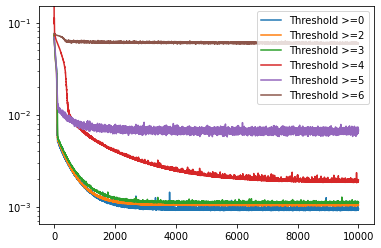

In [ ]:
import matplotlib.pyplot as plt
plt.plot(policy_loss_list_neg1, label='Threshold >=0')
#plt.plot(policy_loss_list_0, label='Threshold >=1')
plt.plot(policy_loss_list_1, label='Threshold >=2')
plt.plot(policy_loss_list_2, label='Threshold >=3')
plt.plot(policy_loss_list_3, label='Threshold >=4')
plt.plot(policy_loss_list_4, label='Threshold >=5')
plt.plot(policy_loss_list_5, label='Threshold >=6')
plt.yscale("log")
plt.ylim(0,0.15)

plt.legend()
